# Проект для «Стальной птицы»

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали.   
Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать.   
Заказчик хочет использовать разработанную модель для имитации технологического процесса.

**План работы**
* Шаг 1. Загрузка данных
* Шаг 2. Исследовательский анализ и предобработка данных
* Шаг 3. Объединение данных
* Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма
* Шаг 5. Подготовка данных
* Шаг 6. Обучение моделей машинного обучения
* Шаг 7. Выбор лучшей модели
* Шаг 8. Общий вывод и рекомендации заказчику

Импорт необходимых библиотек

In [1]:

%pip install scikit-learn -q
%pip install numpy -q
%pip install shap -q
%pip install phik -q
%matplotlib inline
%pip install catboost -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns



from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR

from sklearn.model_selection import (cross_val_score,
                                     RandomizedSearchCV,
                                     train_test_split)
from sklearn.metrics import mean_absolute_error

import shap
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import (SelectKBest,
                                       f_regression,
                                       mutual_info_regression)
from shap import KernelExplainer

RANDOM_STATE=250325

## Загрузка данных

In [3]:
# Список файлов
files = [
    'data_arc_new.csv', 
    'data_bulk_new.csv', 
    'data_bulk_time_new.csv', 
    'data_gas_new.csv', 
    'data_temp_new.csv', 
    'data_wire_new.csv',
    'data_wire_time_new.csv'
]

# Пути для загрузки
server_path = '/datasets/'
local_path = '/Users/polina.piskovatskova/Documents/YP/datasets/industry/'

# Загружаем все датафреймы в словарь
def load_data(file_list, server_path, local_path):
    dataframes = {}
    
    for file in file_list:
        df_name = file.replace('.csv', '')
        server_file = os.path.join(server_path, file)
        local_file = os.path.join(local_path, file)
        
        try:
            # Пробуем загрузить с сервера
            dataframes[df_name] = pd.read_csv(server_file)
            print(f"Файл {file} загружен с сервера")
        except FileNotFoundError:
            try:
                # Пробуем загрузить локально
                dataframes[df_name] = pd.read_csv(local_file)
                print(f"Файл {file} загружен из локальной директории")
            except FileNotFoundError:
                # Если файла нет
                print(f"Файл {file} не найден ни на сервере, ни локально")
                dataframes[df_name] = None
    
    return dataframes

# Загружаем все датафреймы
dfs = load_data(files, server_path, local_path)
for name, df in dfs.items():
    globals()[name] = df

Файл data_arc_new.csv загружен из локальной директории
Файл data_bulk_new.csv загружен из локальной директории
Файл data_bulk_time_new.csv загружен из локальной директории
Файл data_gas_new.csv загружен из локальной директории
Файл data_temp_new.csv загружен из локальной директории
Файл data_wire_new.csv загружен из локальной директории
Файл data_wire_time_new.csv загружен из локальной директории


Загружены 7 датасетов, представленных ниже.
Изучим данные, проверим наличие пропусков, дубликатов, баланс классов. Проведем анализ отдельно каждого датафрейма для удобства.   

- data_arc_new — данные об электродах;
- data_bulk_new — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new — данные о подаче сыпучих материалов (время);
- data_gas_new — данные о продувке сплава газом;
- data_temp_new — результаты измерения температуры;
- data_wire_new — данные о проволочных материалах (объём);
- data_wire_time_new — данные о проволочных материалах (время).

## Исследовательский анализ и предобработка данных

### Данные об электродах data_arc_new

In [4]:
 # Используем функцию для исследовательского анализа количественных признаков
def profiling(dataframe, param, bins=20, color='violet', figsize=(10, 6)):
    if not np.issubdtype(dataframe[param].dtype, np.number):
        print(f"Столбец '{param}' не числовой. Пропускаем анализ.")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    plt.subplots_adjust(wspace=0.4)  
    
   # Гистограмма с кривой распределения
    plt.subplot(1, 2, 1)
    sns.histplot(dataframe[param], bins=bins, kde=True, color=color)
    plt.title(f'Гистограмма {param}')
    plt.xlabel('Значение')
    plt.ylabel('Частота')
    
    # Ящик с усами
    plt.subplot(1, 2, 2)
    sns.boxplot(x=dataframe[param], color=color)
    plt.title(f'Ящик с усами {param}')
    plt.xlabel('')
    
    plt.tight_layout()
    plt.show()
   
    print(f'Анализ параметра: {param}')
    print()
    display(pd.DataFrame(dataframe[param].describe()).T)
    print(f'Пропущенные значения: {dataframe[param].isna().sum()} ({dataframe[param].isna().mean()*100:.2f}%)')
    print(f'Уникальных значений: {dataframe[param].nunique()}')


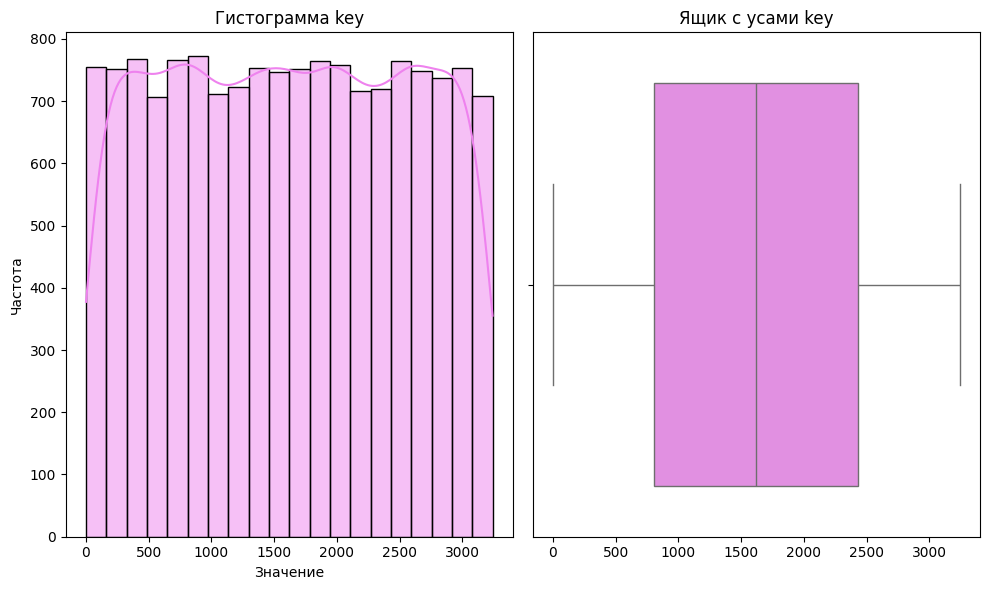

Анализ параметра: key



count         mean         std  min    25%     50%     75%     max
key  14876.0  1615.220422  934.571502  1.0  806.0  1617.0  2429.0  3241.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 3214
Столбец 'Начало нагрева дугой' не числовой. Пропускаем анализ.
Столбец 'Конец нагрева дугой' не числовой. Пропускаем анализ.


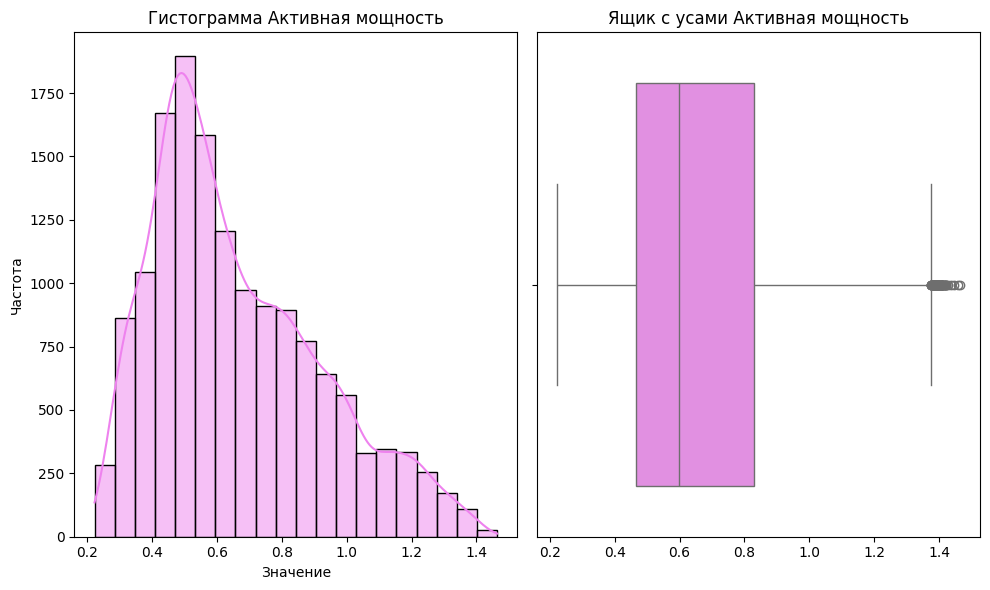

Анализ параметра: Активная мощность



count      mean       std      min       25%       50%  \
Активная мощность  14876.0  0.662752  0.258885  0.22312  0.467115  0.599587   

                       75%       max  
Активная мощность  0.83007  1.463773

Пропущенные значения: 0 (0.00%)
Уникальных значений: 13846


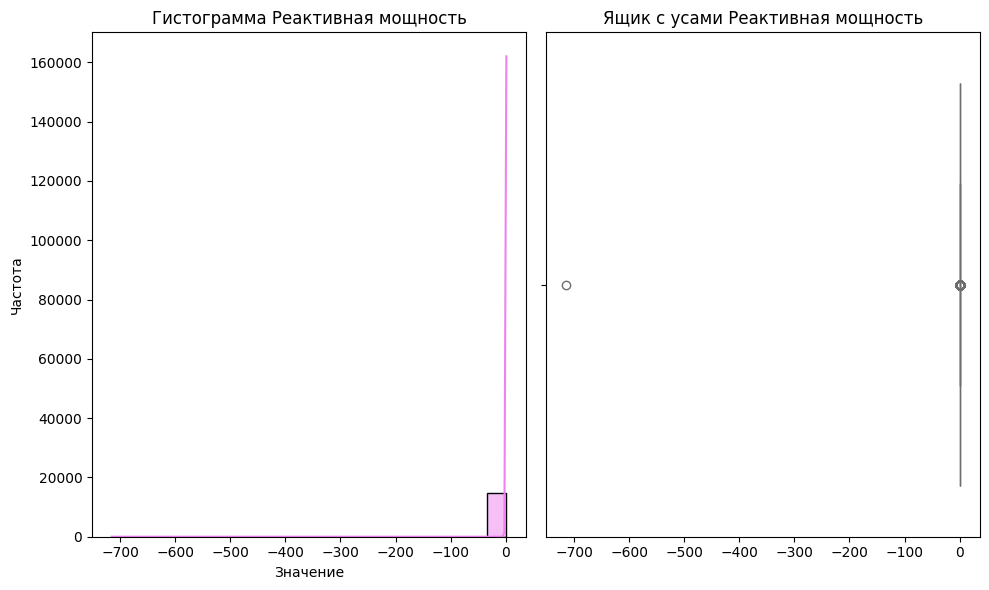

Анализ параметра: Реактивная мощность



count      mean       std         min       25%  \
Реактивная мощность  14876.0  0.438986  5.873485 -715.479924  0.337175   

                          50%       75%       max  
Реактивная мощность  0.441639  0.608201  1.270284

Пропущенные значения: 0 (0.00%)
Уникальных значений: 14707


In [5]:
for parameter in data_arc_new.columns.to_list():
        profiling(data_arc_new, parameter)



В data_arc_new представлены данные о нагреве электродов, где:   
- key — номер партии;  
- Начало нагрева дугой — время начала нагрева;  
- Конец нагрева дугой — время окончания нагрева;  
- Активная мощность — значение активной мощности;  
- Реактивная мощность — значение реактивной мощности.  

Реактивная мощность имеет очень большое по модулю значение - обычно реактивная мощность должна стремиться к нулю (так как это потери мощности). Исключим аномальные значения.
Пропусков нет, дубликатов тоже. 
В датасете представлены данные, начиная с 3 мая 2019 11:06 до 6 сентября 2019 17:26.
Возможно, имеет смысл превратить даты в параметр длительности нагрева дугой для одного ковша, так как длительность позволяяет оценить время нагрева и, следовательно, суммарно затраченную для нагрева энергию.
Активная и реактивная мощность коррелируют с коэффициентом 0.971. Объединим эти признаки во избежание мультиколлинеарности в один: полную мощность, равную геометрической сумме активной и реактивной мощностей. Полная мощность = sqrt(Активная мощность² + Реактивная мощность²). Добавим также новые признаки энергии - активной и реактивной, которые лучше описывают примененную в течении времени мощность.

Исключим аномальные значения реактивной мощности для всего объекта моделирования - ковша.

In [6]:
# Находим ключи ковшей, где есть аномальные значения реактивной мощности
odd_keys = []
odd_keys.append(data_arc_new.loc[data_arc_new['Реактивная мощность'] <= -1.5, 'key'].unique())

# Удаляем все записи этих ковшей из датафрейма
data_arc_new = data_arc_new[~data_arc_new['key'].isin(odd_keys)]

print(f"Удалено ковшей: {len(odd_keys)}")
display(data_arc_new.info())

Удалено ковшей: 1
<class 'pandas.core.frame.DataFrame'>
Index: 14872 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14872 non-null  int64  
 1   Начало нагрева дугой  14872 non-null  object 
 2   Конец нагрева дугой   14872 non-null  object 
 3   Активная мощность     14872 non-null  float64
 4   Реактивная мощность   14872 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 697.1+ KB


None

После исключения аномальной реактивной мощности убрали 4 строки с информацией о ковше, для которого реактивная мощность принимала аномальное значение.

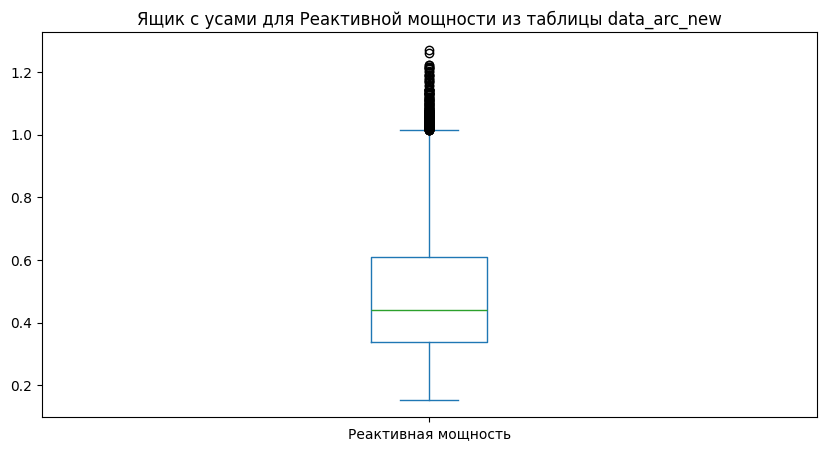

In [7]:
# Ящик с усами
plt.figure(figsize=(10, 5))
data_arc_new['Реактивная мощность'].plot.box(title=f'Ящик с усами для Реактивной мощности из таблицы data_arc_new')
plt.show()

In [8]:
# Вычисляем полную мощность по формуле Полная мощность = sqrt(Активная мощность² + Реактивная мощность²) и создаем отдельный столбец apparent_power
data_arc_new['apparent_power'] = np.sqrt(
    data_arc_new['Активная мощность']**2 + 
    data_arc_new['Реактивная мощность']**2
)

/var/folders/mb/tdzwqv9137jby082pkr2y4c00000gn/T/ipykernel_48625/2357634795.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_arc_new['apparent_power'] = np.sqrt(


In [9]:
# Вычисляем длительность нагрева ковша duration в часах
data_arc_new['Начало нагрева дугой'] = pd.to_datetime(data_arc_new['Начало нагрева дугой'])
data_arc_new['Конец нагрева дугой'] = pd.to_datetime(data_arc_new['Конец нагрева дугой'])
data_arc_new['duration_h'] = (data_arc_new['Конец нагрева дугой'] - data_arc_new['Начало нагрева дугой']).dt.total_seconds()/3600


/var/folders/mb/tdzwqv9137jby082pkr2y4c00000gn/T/ipykernel_48625/2724028455.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_arc_new['Начало нагрева дугой'] = pd.to_datetime(data_arc_new['Начало нагрева дугой'])
/var/folders/mb/tdzwqv9137jby082pkr2y4c00000gn/T/ipykernel_48625/2724028455.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_arc_new['Конец нагрева дугой'] = pd.to_datetime(data_arc_new['Конец нагрева дугой'])
/var/folders/mb/tdzwqv9137jby082pkr2y4c00000gn/T/ipykernel_48625/272402845

In [10]:
# Добавляем новые признаки энергии
data_arc_new['active_energy'] = data_arc_new['Активная мощность'] * data_arc_new['duration_h']
data_arc_new['reactive_energy'] = data_arc_new['Реактивная мощность'] * data_arc_new['duration_h']

/var/folders/mb/tdzwqv9137jby082pkr2y4c00000gn/T/ipykernel_48625/2495826456.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_arc_new['active_energy'] = data_arc_new['Активная мощность'] * data_arc_new['duration_h']
/var/folders/mb/tdzwqv9137jby082pkr2y4c00000gn/T/ipykernel_48625/2495826456.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_arc_new['reactive_energy'] = data_arc_new['Реактивная мощность'] * data_arc_new['duration_h']


In [11]:
data_arc_new.head(5)

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.867133   

   Реактивная мощность  apparent_power  duration_h  active_energy  \
0             0.211253        0.371123    0.063333       0.019325   
1             0.477438        0.902319    0.051389       0.039346   
2             0.430460        0.722536    0.047778       0.027726   
3             0.379979        0.642824    0.101389       0.052570   
4             0.643691        1.079934    0.041111       0.035649   

   reactive_energy  
0         0.013379  
1         0.024535  
2         0.020566  
3         0.038526  
4         0.026463

In [12]:
# Проверим, есть ли перекрытия временных интервалов для одной партии
def check_overlaps(group):
    intervals = list(zip(group['Начало нагрева дугой'], group['Конец нагрева дугой']))
    intervals.sort()
    for i in range(1, len(intervals)):
        if intervals[i][0] < intervals[i-1][1]:
            return True
    return False

overlaps = data_arc_new.groupby('key').apply(check_overlaps)
print(f"Партии с перекрывающимися интервалами нагрева: {overlaps.sum()}")

Партии с перекрывающимися интервалами нагрева: 0


/var/folders/mb/tdzwqv9137jby082pkr2y4c00000gn/T/ipykernel_48625/978572922.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  overlaps = data_arc_new.groupby('key').apply(check_overlaps)


In [13]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14872 entries, 0 to 14875
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14872 non-null  int64         
 1   Начало нагрева дугой  14872 non-null  datetime64[ns]
 2   Конец нагрева дугой   14872 non-null  datetime64[ns]
 3   Активная мощность     14872 non-null  float64       
 4   Реактивная мощность   14872 non-null  float64       
 5   apparent_power        14872 non-null  float64       
 6   duration_h            14872 non-null  float64       
 7   active_energy         14872 non-null  float64       
 8   reactive_energy       14872 non-null  float64       
dtypes: datetime64[ns](2), float64(6), int64(1)
memory usage: 1.1 MB


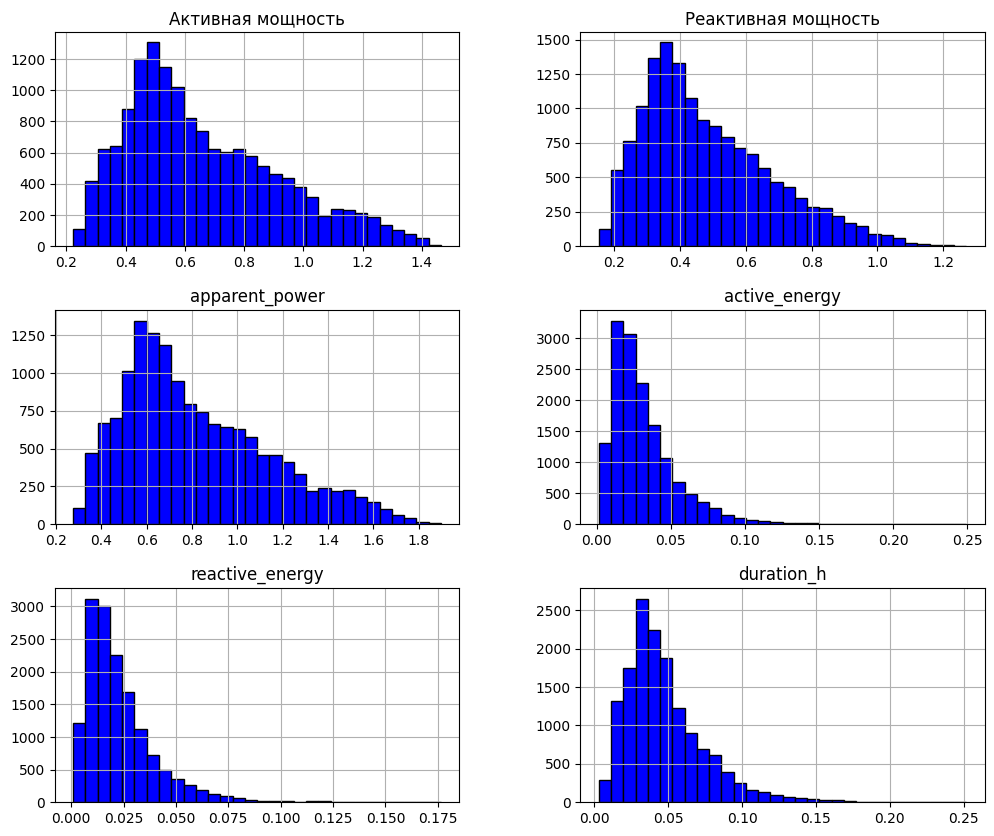

In [14]:
# Общий обзор датасета после обработки
data_arc_new[['Активная мощность', 'Реактивная мощность', 'apparent_power', 'active_energy', 'reactive_energy', 'duration_h']].hist(bins=30,
          figsize=(12, 10),
          color='blue',
          edgecolor='black')
plt.show()

В результате анализа датасета data_arc_new выявлено отсутствие пропусков и дубликатов (кроме столбца key), удалено 1 аномальное значение реактивной мощности (-715.48).  
Дубликаты значений key говорят о том, что нагрев дугой происходит в несколько этапов. В дальнейшем необходимо будет агрегировать данные по партиям.
Из-за высокой корреляции между активной и реактивной мощности решено предварительно объединить эти признаки в полную мощность (apparent_power), а также в активную и реактивную энергию (active_energy, reactive_energy), и далее оценить влияние этих признаков на температуру.     
Даты начала и окончания нагрева позволили вычислить длительность нагрева ковша в секундах, данный признак также может быть полезным для моделирования.
В результате преобразований все количественные признаки имеют нормальное распределение, смещенное влево.

### Данные о подаче сыпучих материалов (объем) data_bulk_new 

data_bulk_new содержит данные о подаче сыпучих легирующих материалов (объём) в процессе обработки стали.
- key — номер партии;
- Bulk 1 … Bulk 15 — объём подаваемого материала (например, объем добавленного хрома, никеля, марганца и т.д.).


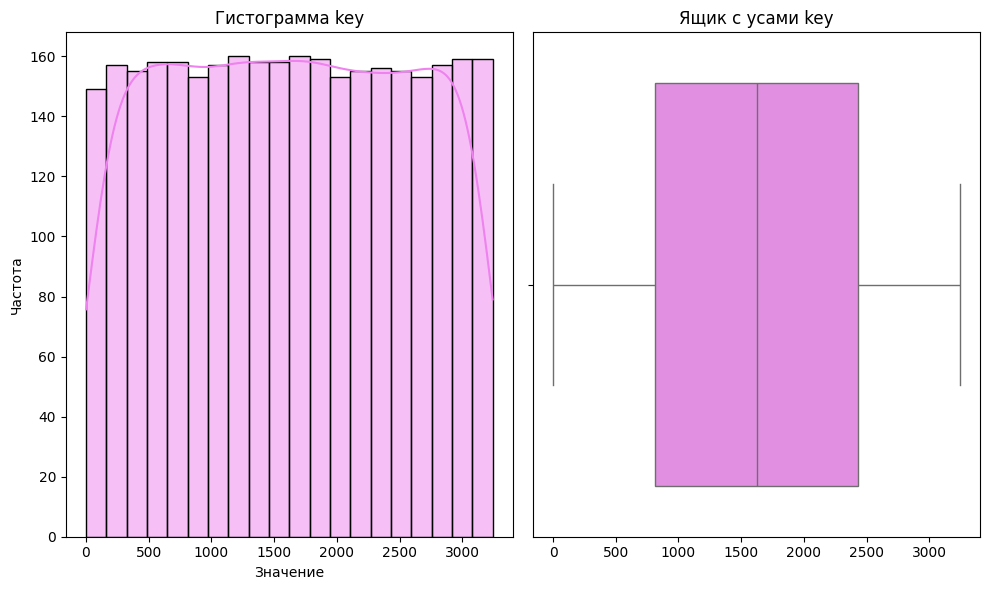

Анализ параметра: key



count         mean         std  min    25%     50%     75%     max
key  3129.0  1624.383509  933.337642  1.0  816.0  1622.0  2431.0  3241.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 3129


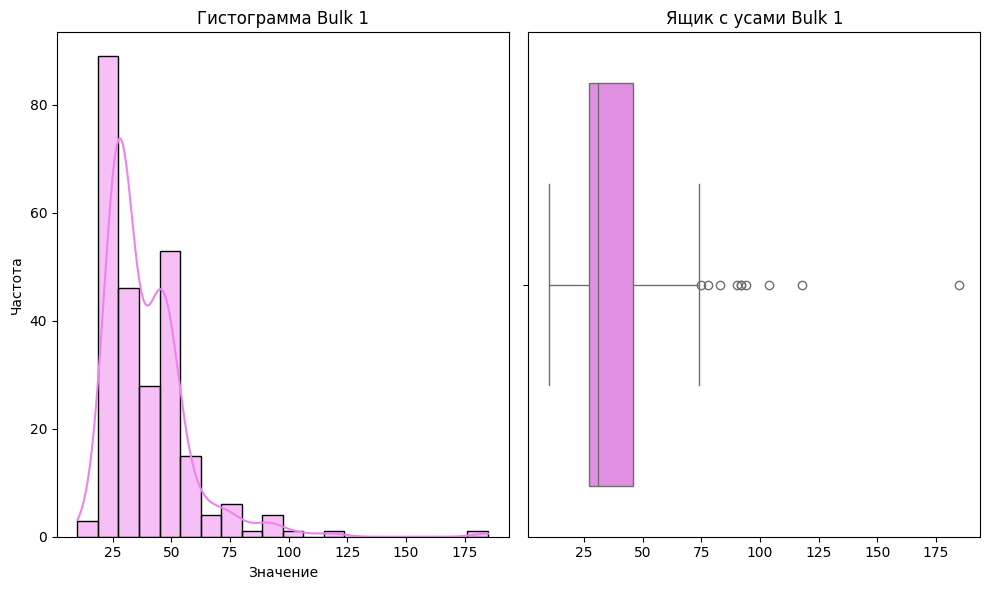

Анализ параметра: Bulk 1



count       mean        std   min   25%   50%   75%    max
Bulk 1  252.0  39.242063  18.277654  10.0  27.0  31.0  46.0  185.0

Пропущенные значения: 2877 (91.95%)
Уникальных значений: 47


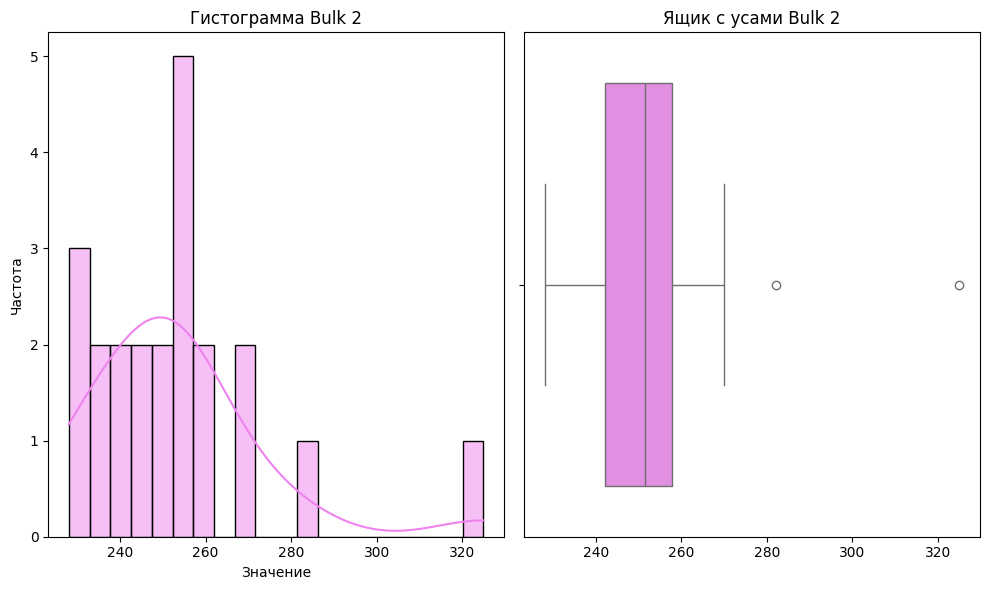

Анализ параметра: Bulk 2



count        mean        std    min    25%    50%     75%    max
Bulk 2   22.0  253.045455  21.180578  228.0  242.0  251.5  257.75  325.0

Пропущенные значения: 3107 (99.30%)
Уникальных значений: 15


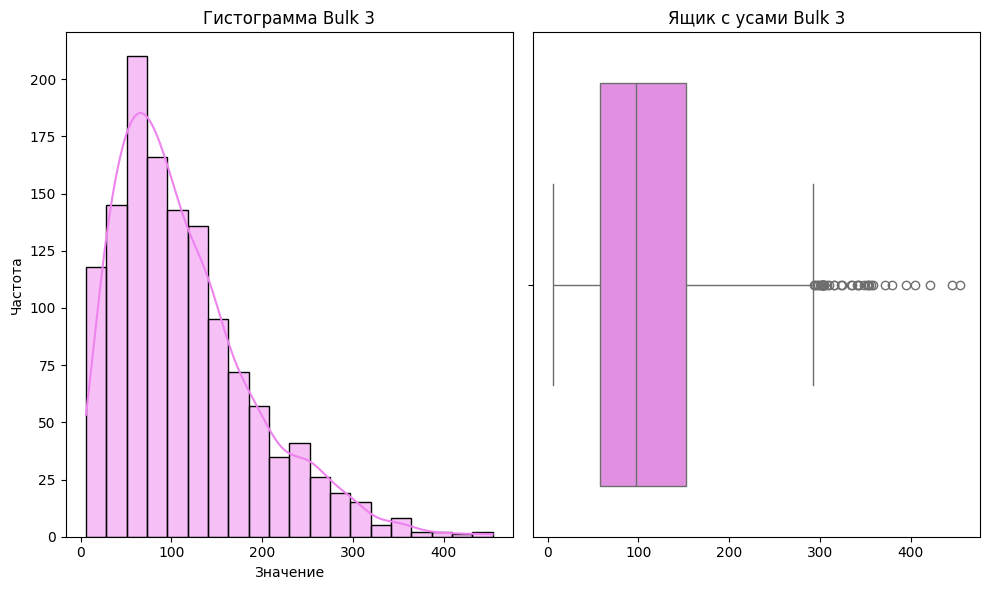

Анализ параметра: Bulk 3



count        mean        std  min   25%   50%    75%    max
Bulk 3  1298.0  113.879045  75.483494  6.0  58.0  97.5  152.0  454.0

Пропущенные значения: 1831 (58.52%)
Уникальных значений: 278


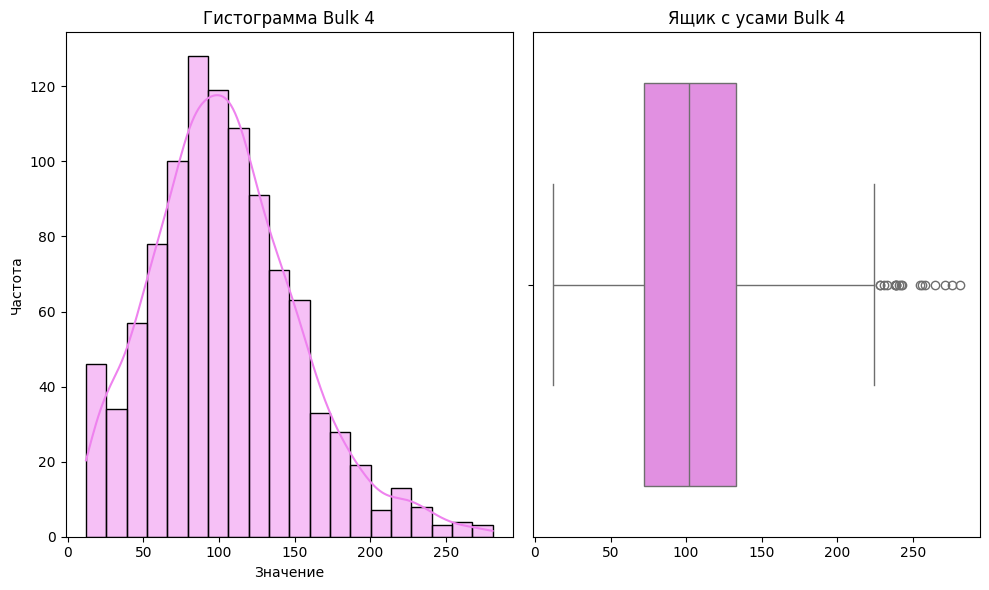

Анализ параметра: Bulk 4



count        mean        std   min   25%    50%    75%    max
Bulk 4  1014.0  104.394477  48.184126  12.0  72.0  102.0  133.0  281.0

Пропущенные значения: 2115 (67.59%)
Уникальных значений: 206


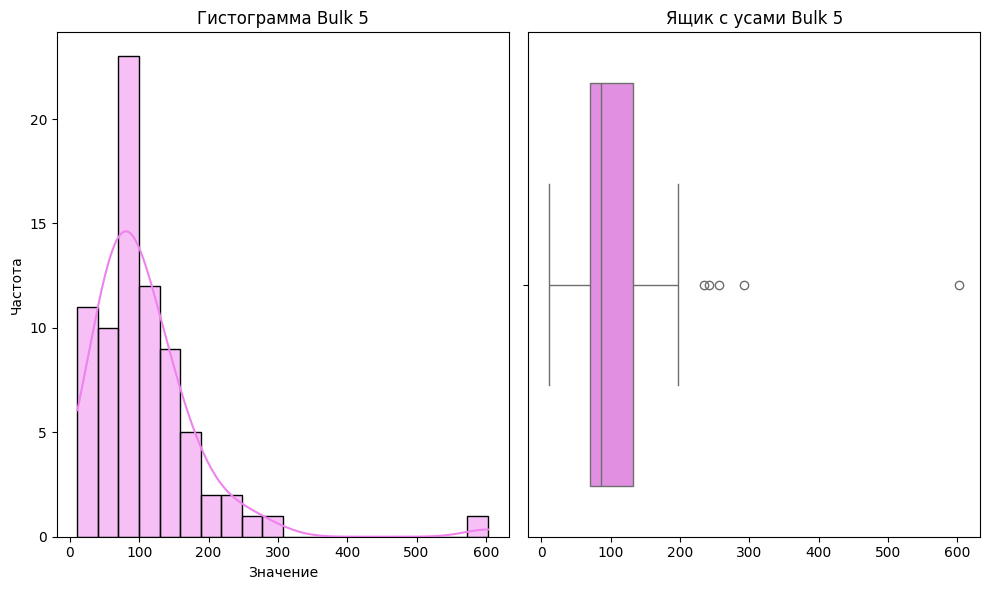

Анализ параметра: Bulk 5



count        mean        std   min   25%   50%    75%    max
Bulk 5   77.0  107.025974  81.790646  11.0  70.0  86.0  132.0  603.0

Пропущенные значения: 3052 (97.54%)
Уникальных значений: 55


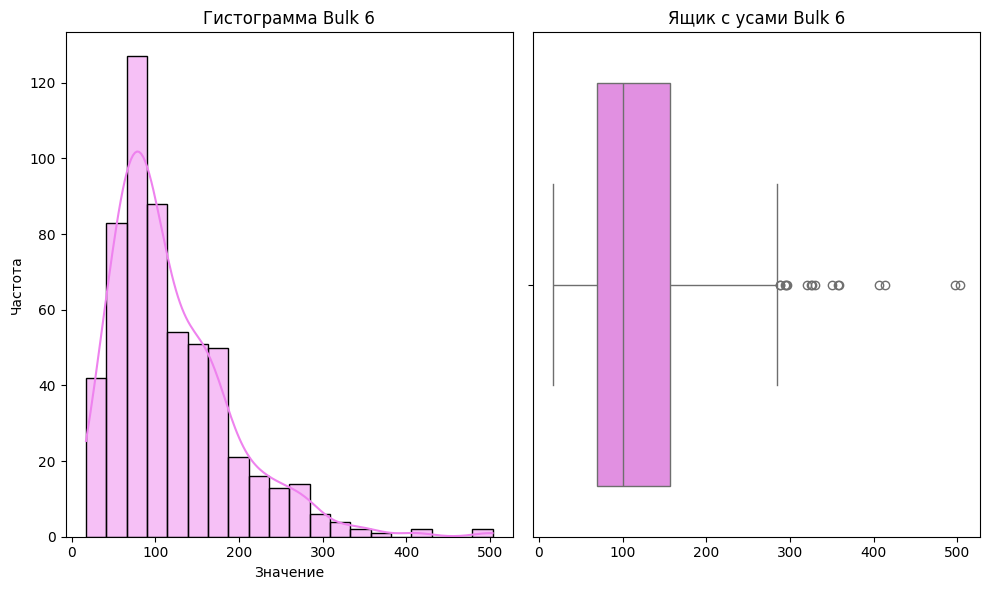

Анализ параметра: Bulk 6



count        mean        std   min    25%    50%    75%    max
Bulk 6  576.0  118.925347  72.057776  17.0  69.75  100.0  157.0  503.0

Пропущенные значения: 2553 (81.59%)
Уникальных значений: 205


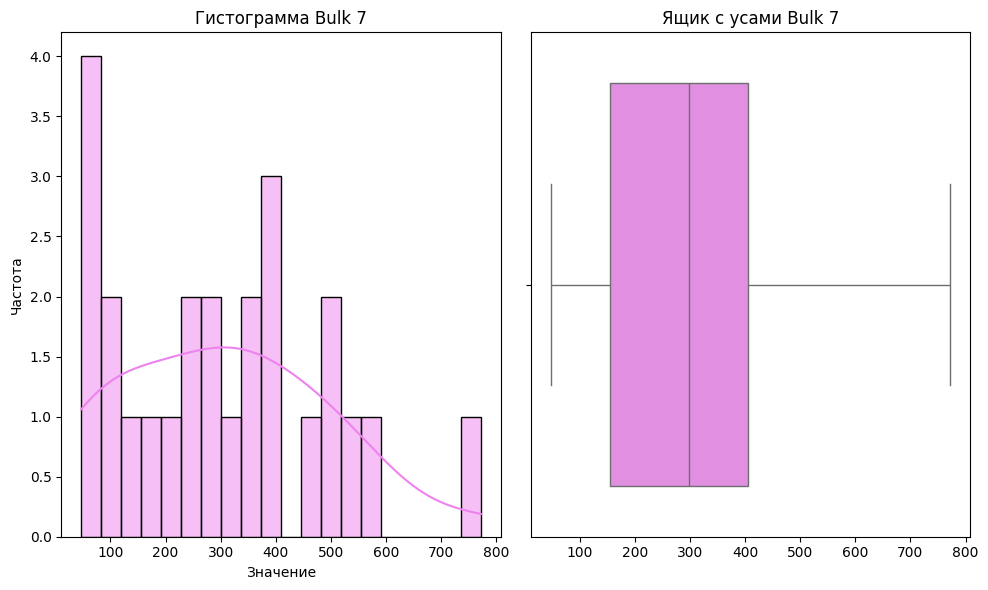

Анализ параметра: Bulk 7



count   mean         std   min    25%    50%    75%    max
Bulk 7   25.0  305.6  191.022904  47.0  155.0  298.0  406.0  772.0

Пропущенные значения: 3104 (99.20%)
Уникальных значений: 25


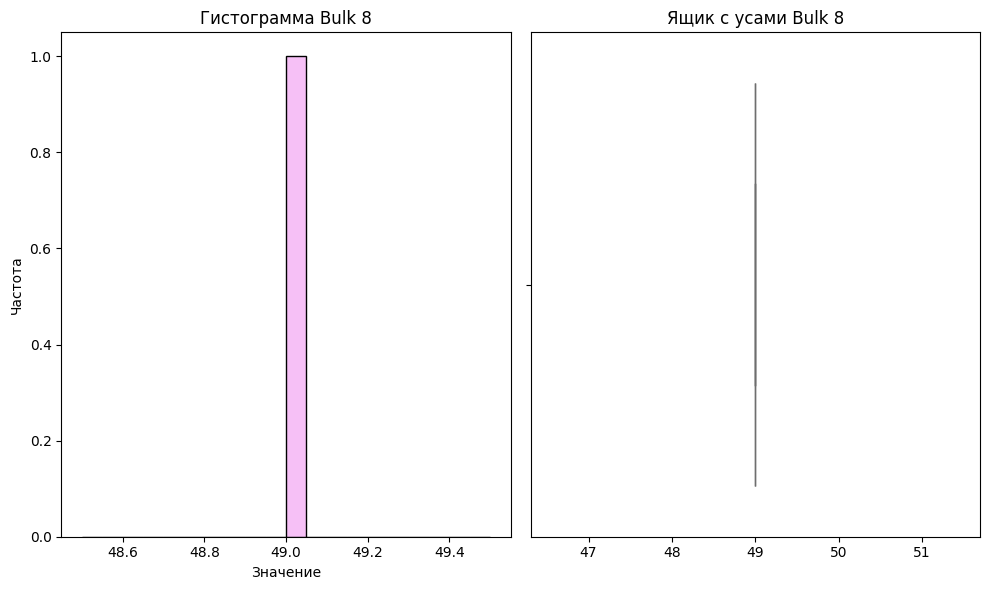

Анализ параметра: Bulk 8



count  mean  std   min   25%   50%   75%   max
Bulk 8    1.0  49.0  NaN  49.0  49.0  49.0  49.0  49.0

Пропущенные значения: 3128 (99.97%)
Уникальных значений: 1


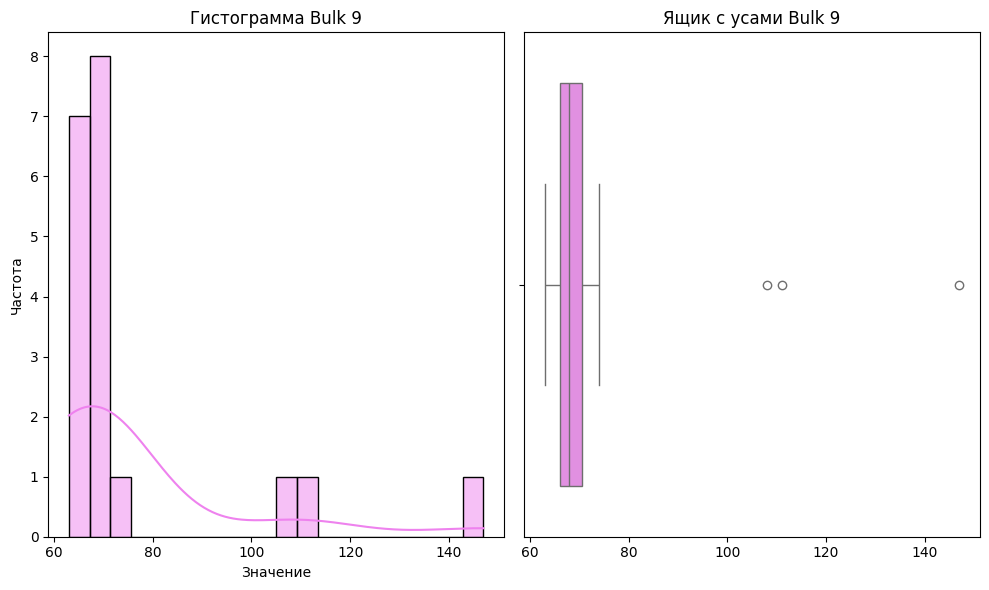

Анализ параметра: Bulk 9



count       mean        std   min   25%   50%   75%    max
Bulk 9   19.0  76.315789  21.720581  63.0  66.0  68.0  70.5  147.0

Пропущенные значения: 3110 (99.39%)
Уникальных значений: 10


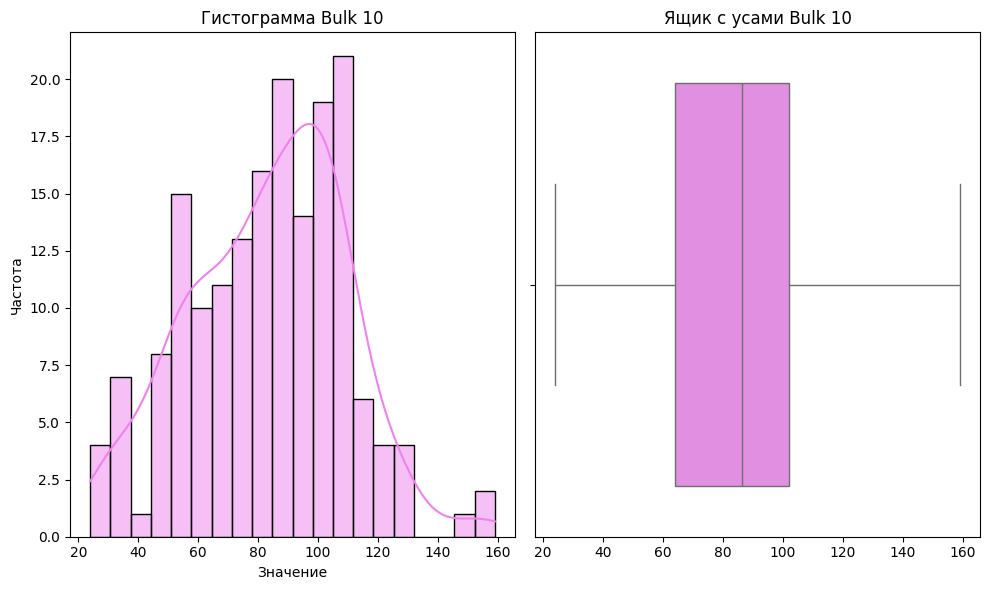

Анализ параметра: Bulk 10



count       mean        std   min   25%   50%    75%    max
Bulk 10  176.0  83.284091  26.060347  24.0  64.0  86.5  102.0  159.0

Пропущенные значения: 2953 (94.38%)
Уникальных значений: 77


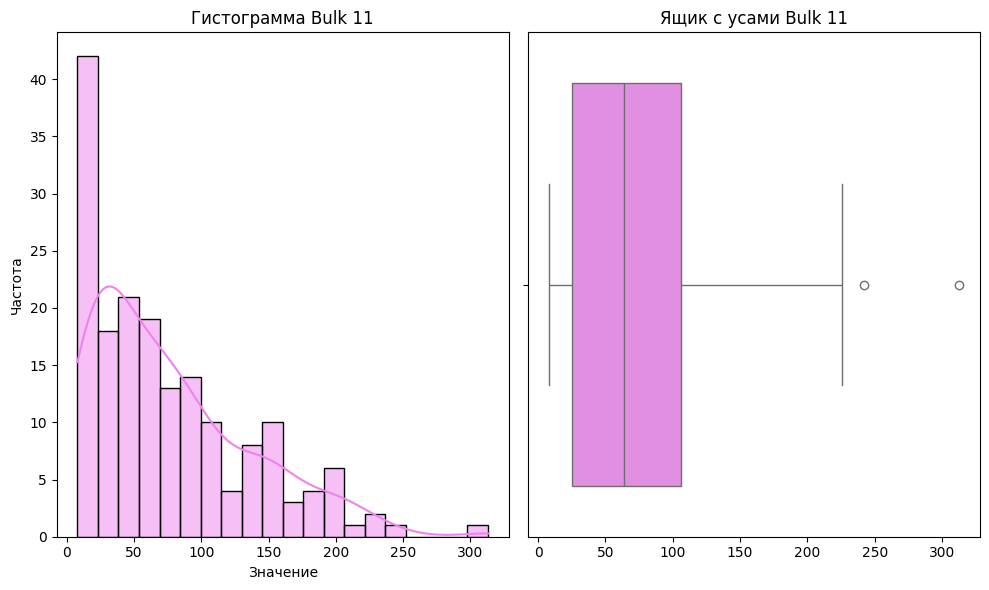

Анализ параметра: Bulk 11



count       mean        std  min   25%   50%    75%    max
Bulk 11  177.0  76.819209  59.655365  8.0  25.0  64.0  106.0  313.0

Пропущенные значения: 2952 (94.34%)
Уникальных значений: 101


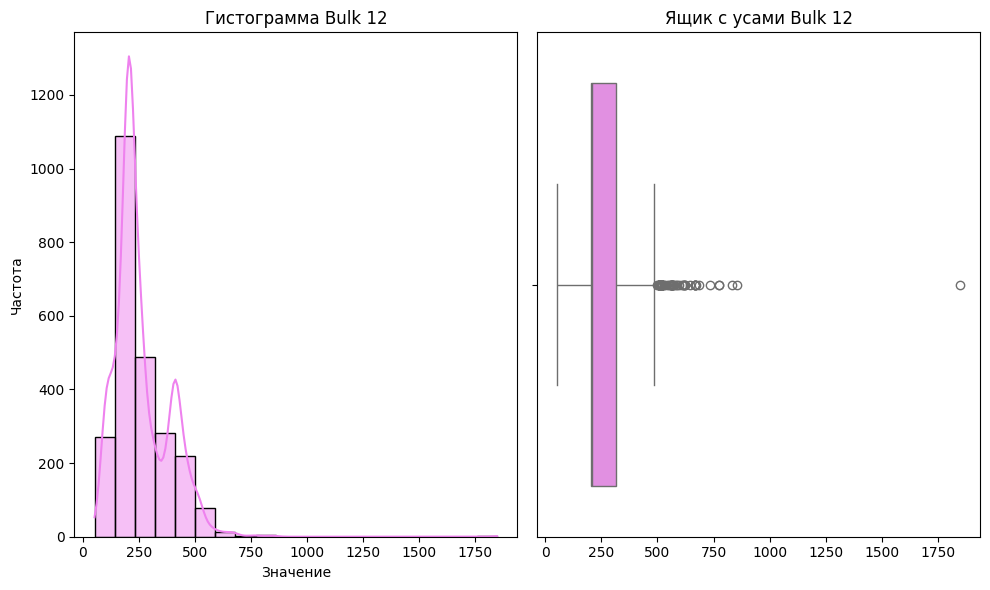

Анализ параметра: Bulk 12



count       mean         std   min    25%    50%    75%     max
Bulk 12  2450.0  260.47102  120.649269  53.0  204.0  208.0  316.0  1849.0

Пропущенные значения: 679 (21.70%)
Уникальных значений: 331


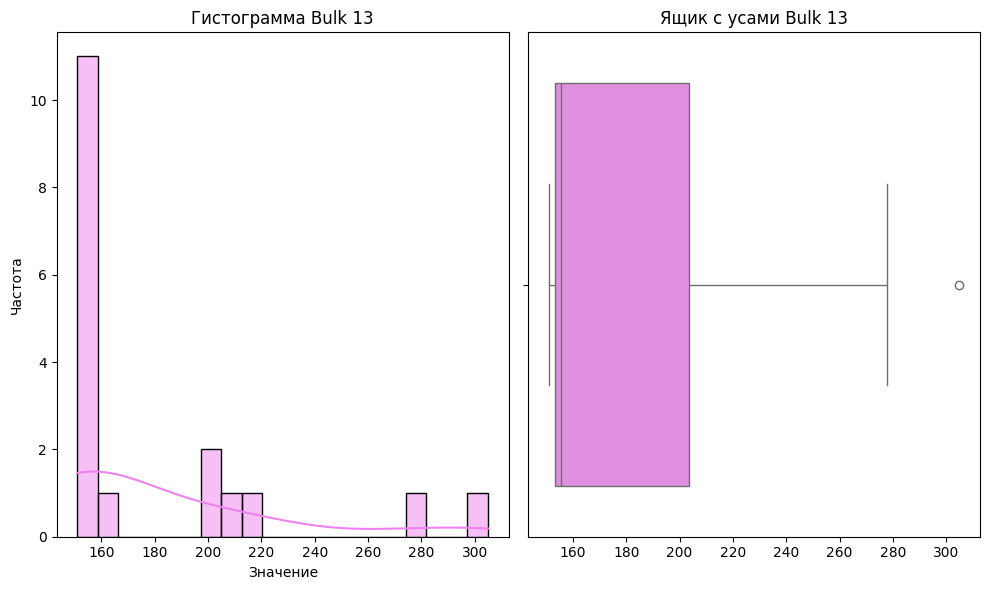

Анализ параметра: Bulk 13



count        mean        std    min     25%    50%    75%    max
Bulk 13   18.0  181.111111  46.088009  151.0  153.25  155.5  203.5  305.0

Пропущенные значения: 3111 (99.42%)
Уникальных значений: 14


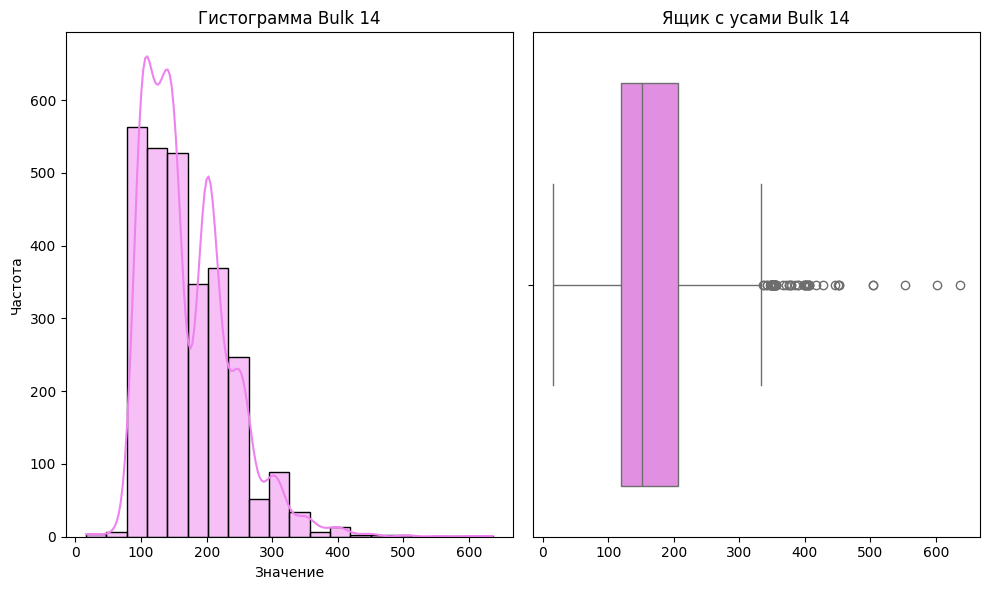

Анализ параметра: Bulk 14



count        mean        std   min    25%    50%     75%    max
Bulk 14  2806.0  170.284747  65.868652  16.0  119.0  151.0  205.75  636.0

Пропущенные значения: 323 (10.32%)
Уникальных значений: 284


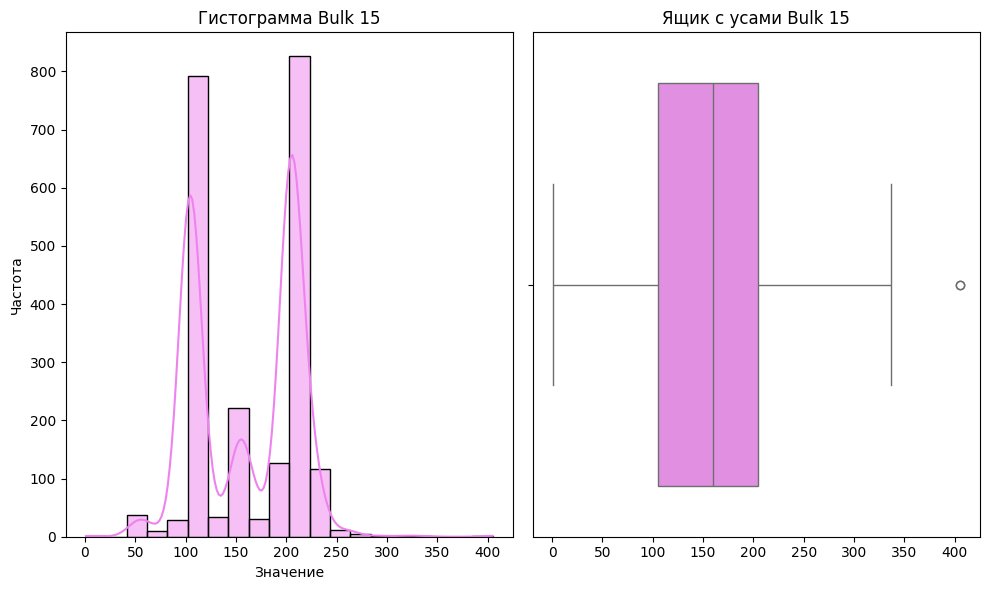

Анализ параметра: Bulk 15



count        mean        std  min    25%    50%    75%    max
Bulk 15  2248.0  160.513345  51.765319  1.0  105.0  160.0  205.0  405.0

Пропущенные значения: 881 (28.16%)
Уникальных значений: 156


In [15]:
for parameter in data_bulk_new.columns.to_list():
        profiling(data_bulk_new, parameter)


Большое количество пропусков в data_bulk_new с большой долей вероятности обозначает, что объем добавленных сыпучих материалов заносили в таблицу, а если их не добавляли - оставляли поля пустыми.  
Поэтому можно заменить пропуски объема сыпучих добавок нулями.    
Bulk_8 имеет постоянное значение 49 и добавлено только в 1 случае. Скорее всего, это какая-то ошибка, данный столбец, скорее всего, использовать не будем.

In [16]:
# Создадим дополнительный признак - суммарный объем добавок
bulk_columns = [col for col in data_bulk_new.columns if col.startswith('Bulk')]
data_bulk_new['total_bulk'] = data_bulk_new[bulk_columns].sum(axis=1)

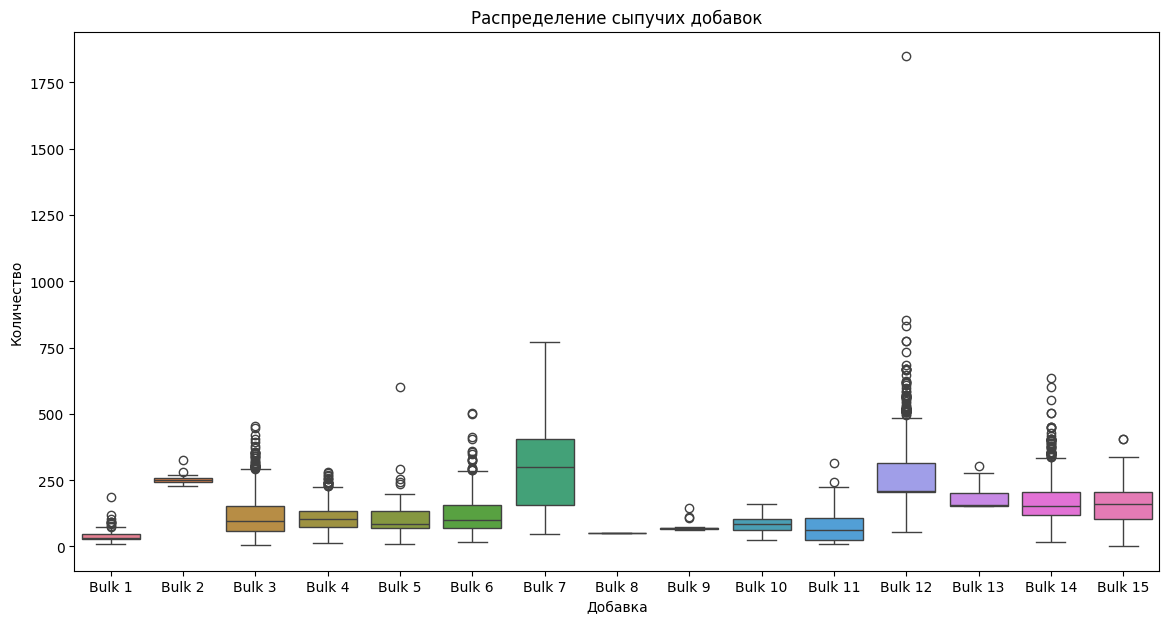

In [17]:
# Построение диаграммы ящик с усами для сыпучих добавок
plt.figure(figsize=(14, 7))
sns.boxplot(data=data_bulk_new[bulk_columns], notch=False)


plt.title('Распределение сыпучих добавок')
plt.xlabel('Добавка')
plt.ylabel('Количество')
plt.show()

Выбросы есть, но, скорее всего, они связаны с особенностями производственного процесса.

In [18]:
# Заменяем пропуски в data_bulk_new на 0
data_bulk_new = data_bulk_new.fillna(0)

Добавки сыпучих материалов чаще всего распределены неравномерно, в некоторых добавках, например, есть выбивающиеся высокие значения.    
Скорее всего, это связано с особенностями производственного процесса.  
Для data_bulk_new устранены пропуски - все пропущенные значения заменены на 0. В результате устранена высокая корреляция между добавками.    
Возможно, после проверки корреляции с целевым признаком, можно будет объединить сыпучие материалы, которые добавлены в небольших объемах.

### Данные о подаче ссыпучих материалов (время) data_bulk_time_new

В датафрейме data_bulk_time_new представлены данные о подаче сыпучих материалов (время):
- key — номер партии;
- Bulk 1 … Bulk 15 — время подачи материала.

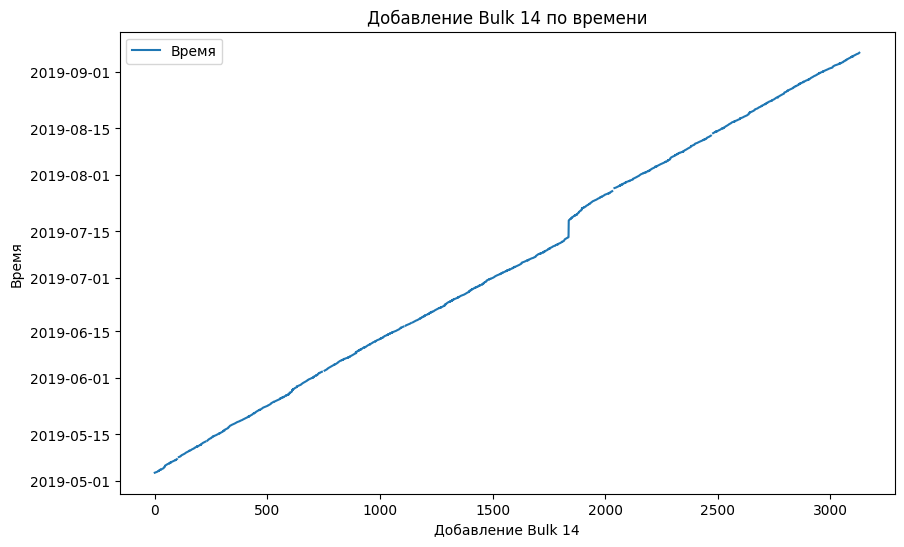

In [19]:
# Построим график
ax = pd.to_datetime(data_bulk_time_new['Bulk 14']).plot(figsize=(10, 6), title='Добавление Bulk 14 по времени', label='Время')
plt.xlabel('Добавление Bulk 14')
plt.ylabel('Время')
plt.legend()
plt.show()

Возможно, время нагрева до добавления добавок может влиять на температуру сплава, но, скорее всего, большее влияние оказывает именно масса добавок.   
 График выше получается не очень информативным, он показывает увеличение количества добавки Bulk 14 со временем, что логично, но не особо полезно.

### Данные о продувке сплава газом data_gas_new

data_gas_new содержит данные о продувке сплава газом:
- y — номер партии;
- Газ 1 — объём подаваемого газа.

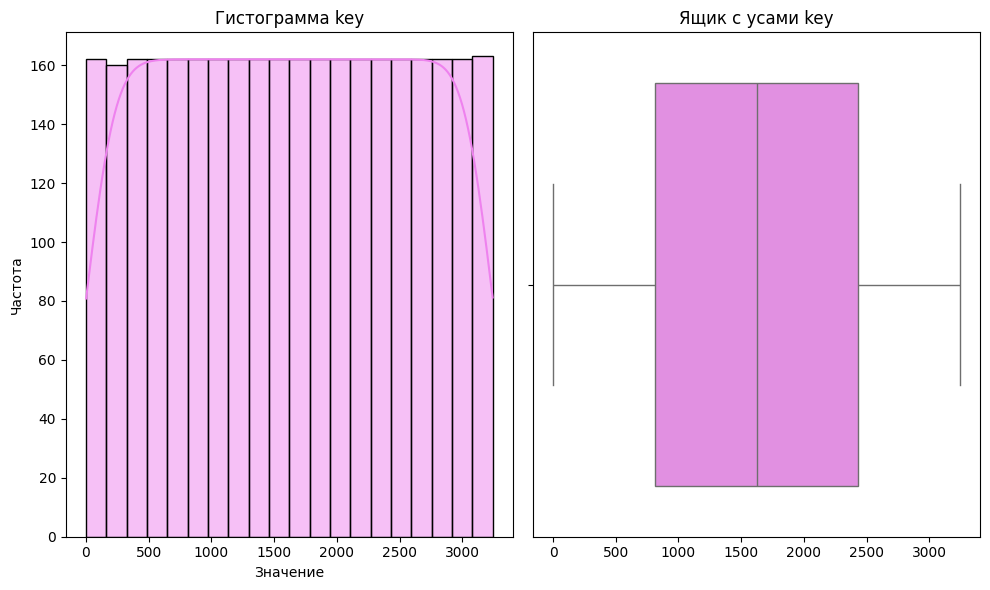

Анализ параметра: key



count         mean         std  min    25%     50%     75%     max
key  3239.0  1621.861377  935.386334  1.0  812.5  1622.0  2431.5  3241.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 3239


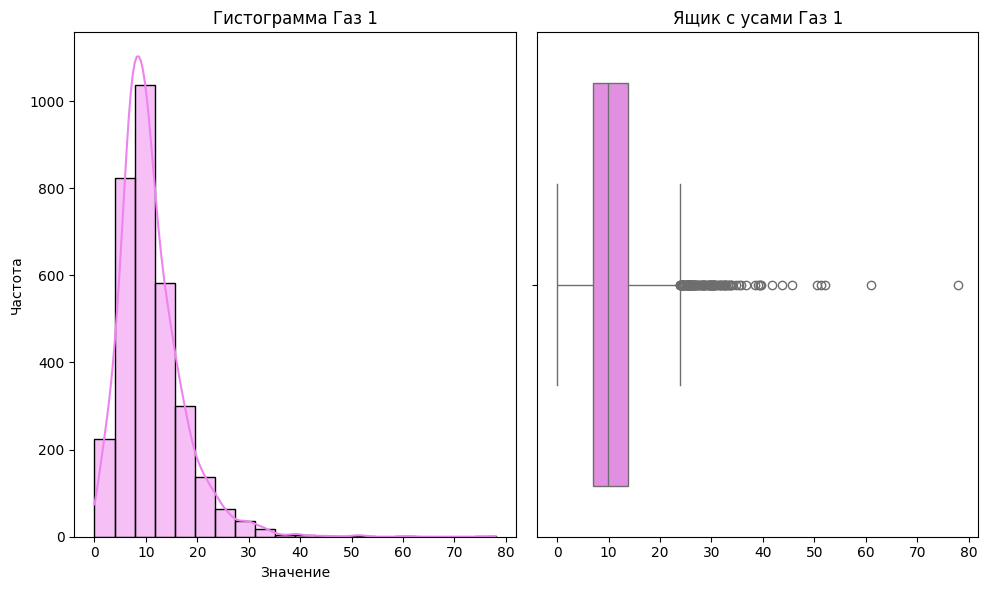

Анализ параметра: Газ 1



count       mean       std       min       25%       50%        75%  \
Газ 1  3239.0  11.002062  6.220327  0.008399  7.043089  9.836267  13.769915   

            max  
Газ 1  77.99504

Пропущенные значения: 0 (0.00%)
Уникальных значений: 3239


In [20]:
for parameter in data_gas_new.columns.to_list():
        profiling(data_gas_new, parameter)

In [21]:
# переименуем переменную для удобства - gas
data_gas_new = data_gas_new.rename(columns={'Газ 1':'gas'})

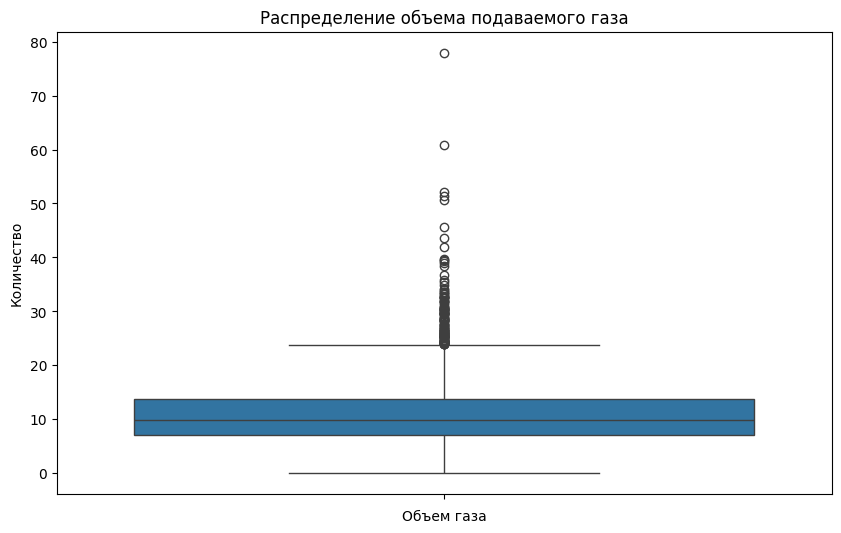

In [22]:
# Построение диаграммы ящик с усами для добавок газа
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_gas_new['gas'], notch=False)


plt.title('Распределение объема подаваемого газа')
plt.xlabel('Объем газа')
plt.ylabel('Количество')
plt.show()

В data_gas_new нет пропусков и дубликатов, а также аномальных значений. Распределение параметра нормальное, немного смещено влево.

### Данные о проволочных материалах (объём) data_wire_new

data_wire_new содержит данные о проволочных материалах (объём):
- key — номер партии;
- Wire 1 … Wire 9 — объём подаваемых проволочных материалов.


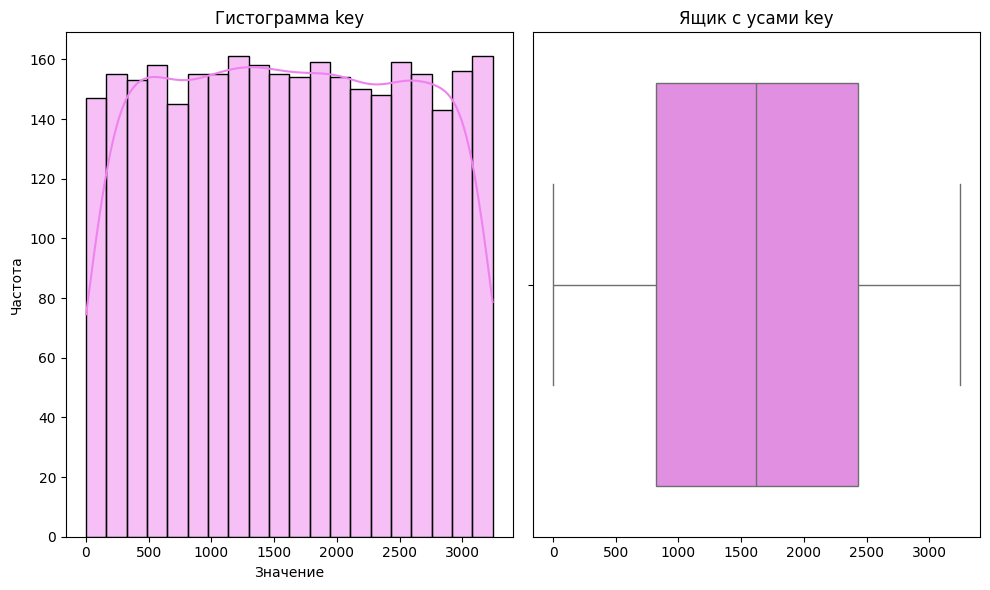

Анализ параметра: key



count         mean         std  min    25%     50%     75%     max
key  3081.0  1623.426485  932.996726  1.0  823.0  1619.0  2434.0  3241.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 3081


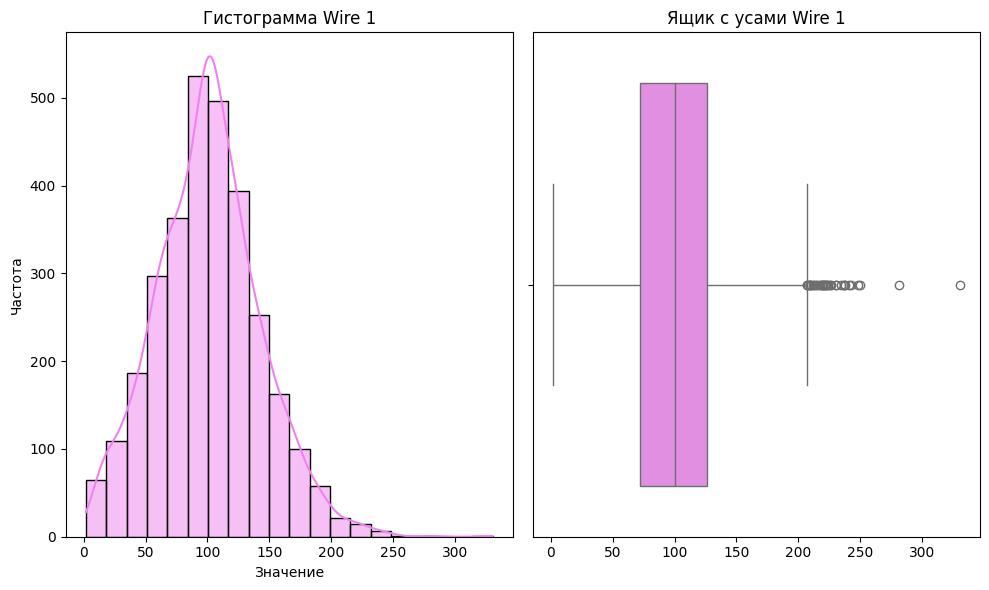

Анализ параметра: Wire 1



count        mean        std     min        25%         50%  \
Wire 1  3055.0  100.895853  42.012518  1.9188  72.115684  100.158234   

               75%         max  
Wire 1  126.060483  330.314424

Пропущенные значения: 26 (0.84%)
Уникальных значений: 2251


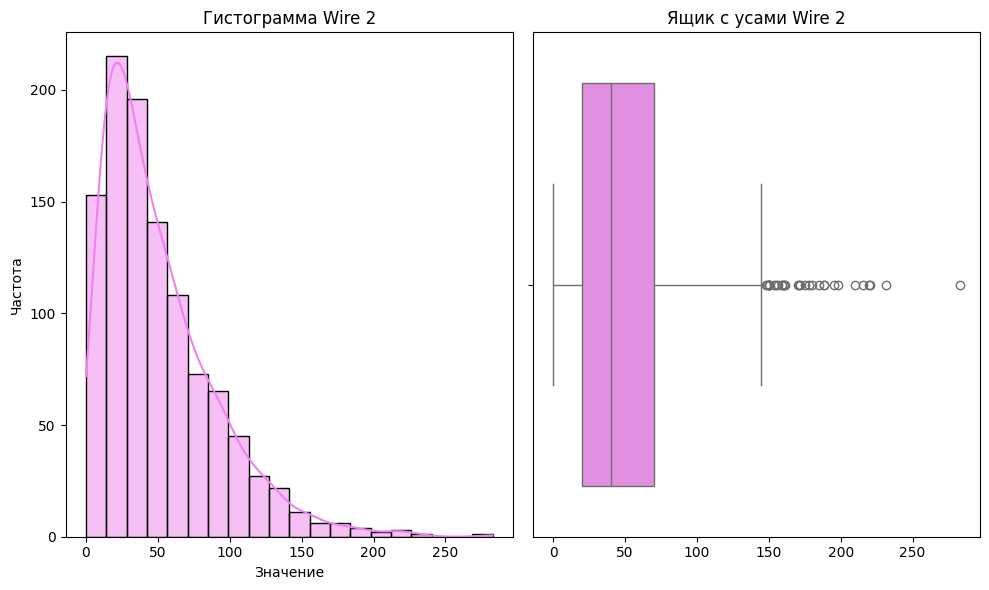

Анализ параметра: Wire 2



count       mean        std      min       25%        50%        75%  \
Wire 2  1079.0  50.577323  39.320216  0.03016  20.19368  40.142956  70.227558   

               max  
Wire 2  282.780152

Пропущенные значения: 2002 (64.98%)
Уникальных значений: 713


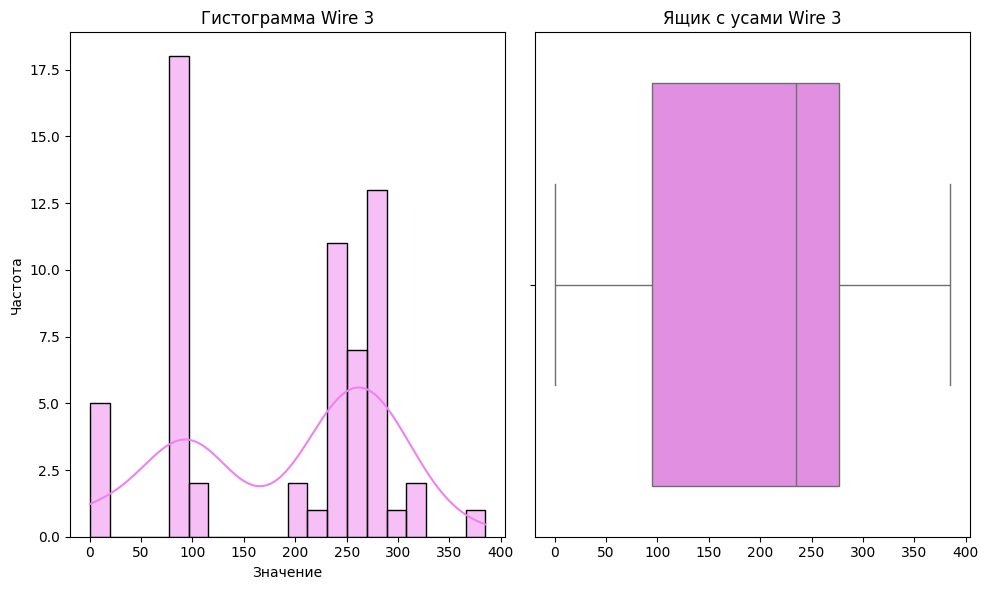

Анализ параметра: Wire 3



count        mean        std       min        25%         50%  \
Wire 3   63.0  189.482681  99.513444  0.144144  95.135044  235.194977   

               75%         max  
Wire 3  276.252014  385.008668

Пропущенные значения: 3018 (97.96%)
Уникальных значений: 56


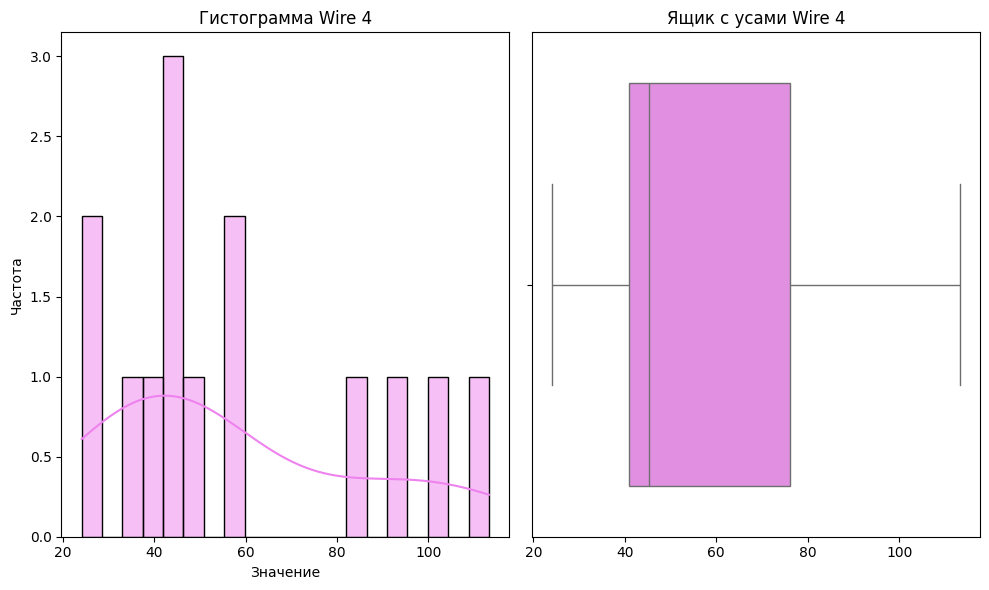

Анализ параметра: Wire 4



count       mean        std        min        25%        50%  \
Wire 4   14.0  57.442841  28.824667  24.148801  40.807002  45.234282   

              75%         max  
Wire 4  76.124619  113.231044

Пропущенные значения: 3067 (99.55%)
Уникальных значений: 14


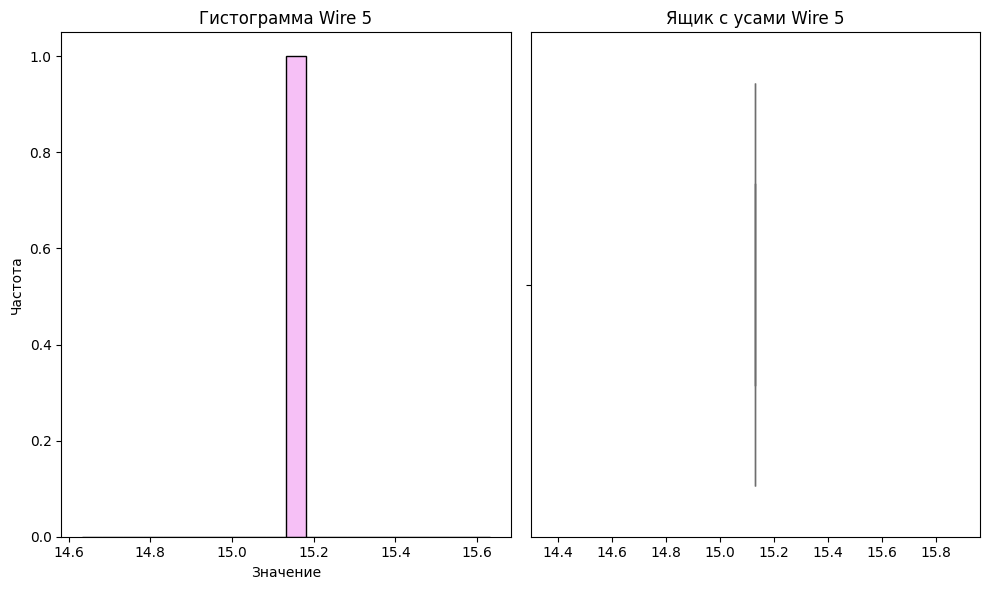

Анализ параметра: Wire 5



count    mean  std     min     25%     50%     75%     max
Wire 5    1.0  15.132  NaN  15.132  15.132  15.132  15.132  15.132

Пропущенные значения: 3080 (99.97%)
Уникальных значений: 1


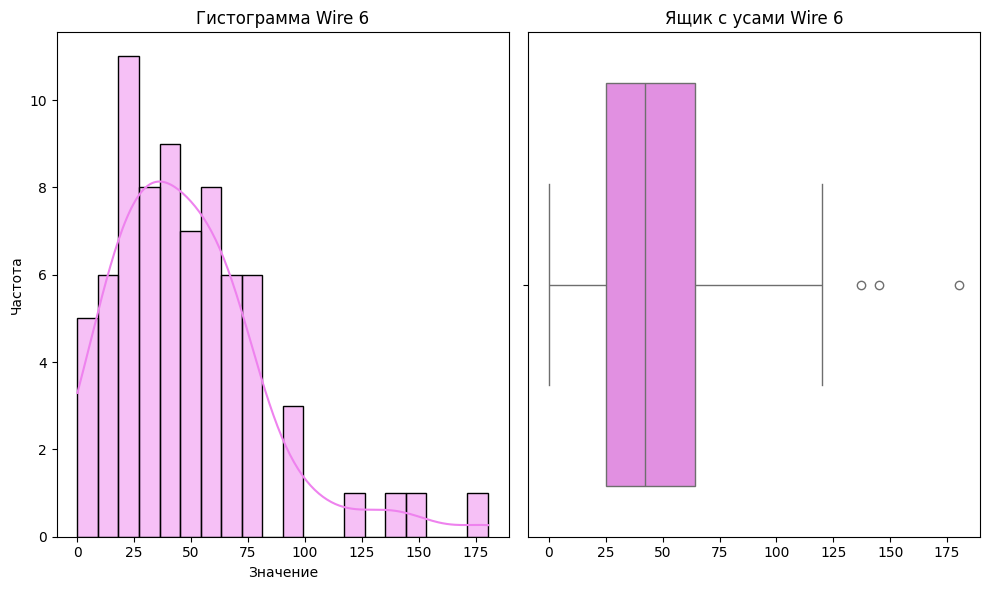

Анализ параметра: Wire 6



count       mean        std      min      25%        50%        75%  \
Wire 6   73.0  48.016974  33.919845  0.03432  25.0536  42.076324  64.212723   

               max  
Wire 6  180.454575

Пропущенные значения: 3008 (97.63%)
Уникальных значений: 69


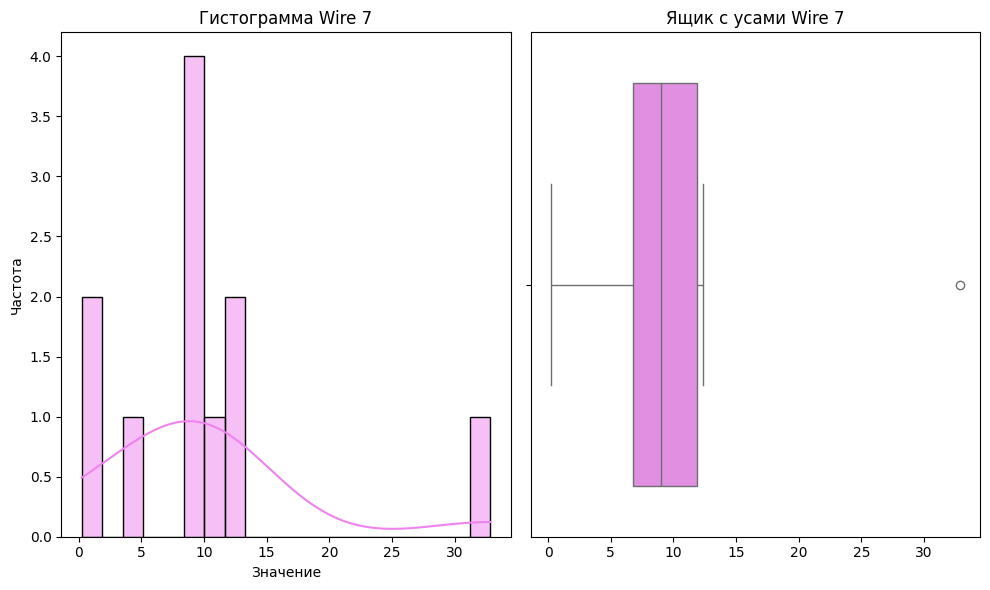

Анализ параметра: Wire 7



count       mean       std       min       25%       50%        75%  \
Wire 7   11.0  10.039007  8.610584  0.234208  6.762756  9.017009  11.886057   

              max  
Wire 7  32.847674

Пропущенные значения: 3070 (99.64%)
Уникальных значений: 10


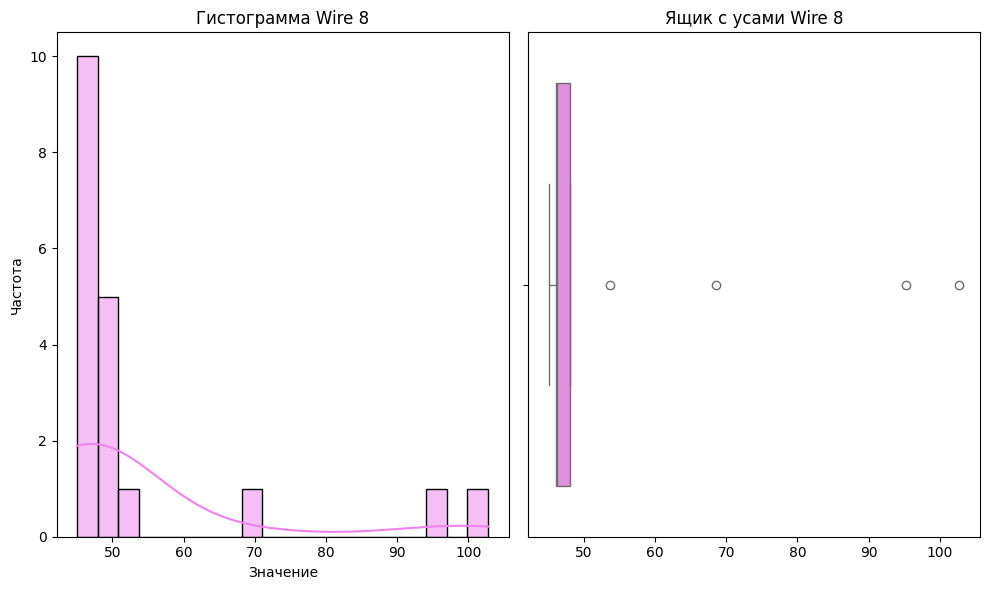

Анализ параметра: Wire 8



count       mean        std        min        25%        50%  \
Wire 8   19.0  53.625193  16.881728  45.076721  46.094879  46.279999   

              75%         max  
Wire 8  48.089603  102.762401

Пропущенные значения: 3062 (99.38%)
Уникальных значений: 13


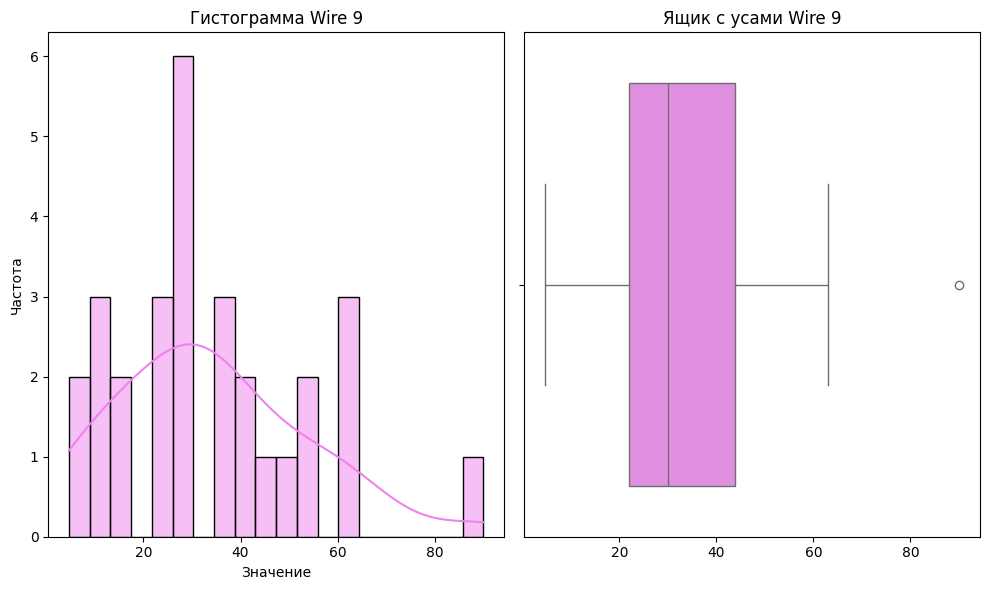

Анализ параметра: Wire 9



count       mean        std     min        25%        50%        75%  \
Wire 9   29.0  34.155752  19.931616  4.6228  22.058401  30.066399  43.862003   

              max  
Wire 9  90.053604

Пропущенные значения: 3052 (99.06%)
Уникальных значений: 25


In [23]:
for parameter in data_wire_new.columns.to_list():
        profiling(data_wire_new, parameter)

Wire_5 имеет только одно значение, скорее всего, это неинформативный признак, который можно будет удалить.

In [24]:
# Список колонок - проволочные добавки
wire_columns = [col for col in data_wire_new.columns if col.startswith('Wire')]

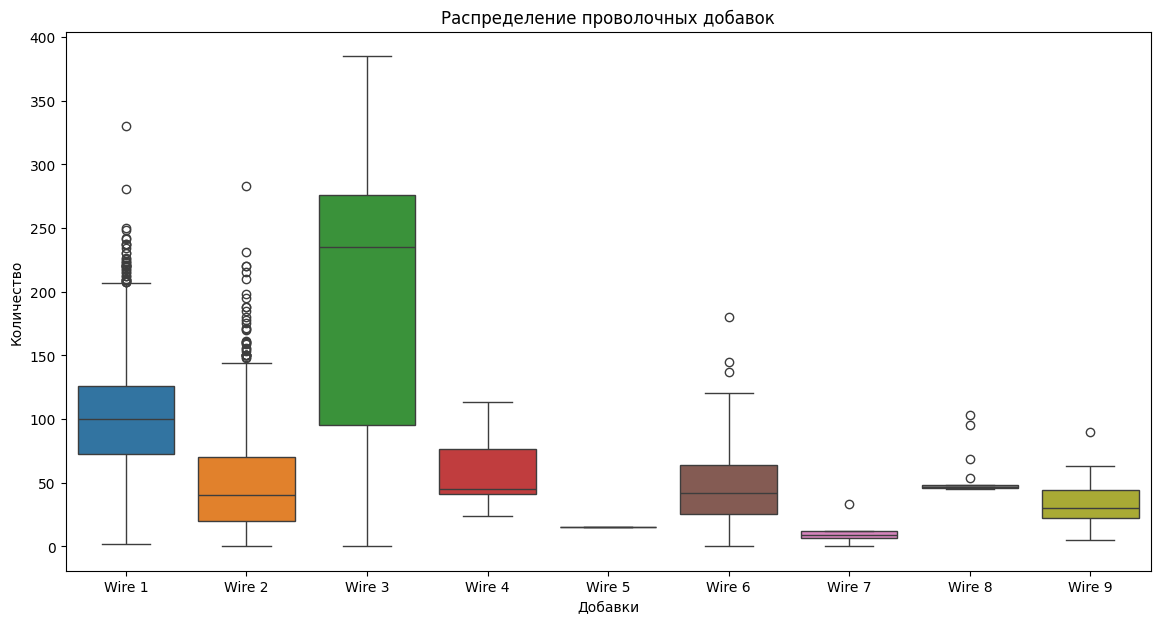

In [25]:
# Построение диаграммы ящик с усами для сыпучих добавок
plt.figure(figsize=(14, 7))
sns.boxplot(data=data_wire_new[wire_columns], notch=False)


plt.title('Распределение проволочных добавок')
plt.xlabel('Добавки')
plt.ylabel('Количество')
plt.show()

In [26]:
# Заменяем пропуски в data_wire_new на 0
data_wire_new = data_wire_new.fillna(0)

Устранены пропуски значений Wire - проволочных добавок - с заменой на 0. 
Многие добавки   
Высокая корреляция устранена между проволочными добавками, но новый признак суммарных добавок имеет коэффициент корреляции Пирсона более 0.9 с Wire_3, поэтому лучше не использовать этот признак.   
Добавка Wire_5 использована 1 раз, поэтому, скорее всего, лучше исключить ее из данных для обучения или же создать признак с редкими добавками, куда включить такие добавки как Wire_5, Wire_7, Wire_8.

### Данные о проволочных материалах (время) data_wire_time_new

В data_wire_time_new содержатся данные о проволочных материалах (время):   
- y — номер партии;
- Wire 1 … Wire 9 — время подачи проволочных материалов.

Тут как и в случае с временем добавления сыпучих добавок, достаточно неинформативный признак.

### Результаты измерения температуры data_temp_new 

data_temp_new содержит данные об измерениях температуры:
- key — номер партии;
- Время замера — время замера;
- Температура — значение температуры - целевой признак.

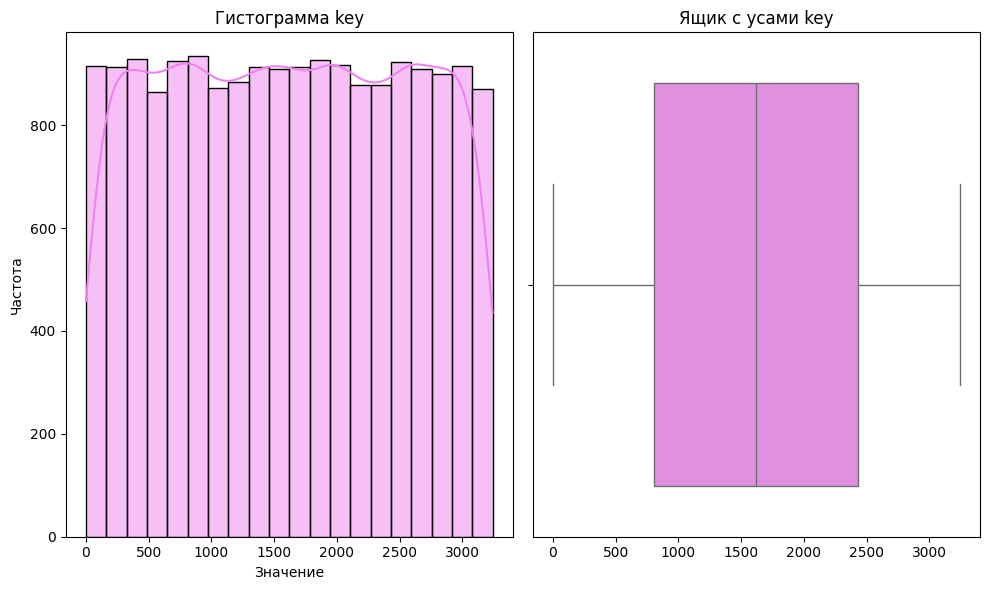

Анализ параметра: key



count         mean         std  min     25%     50%     75%     max
key  18092.0  1616.460977  934.641385  1.0  807.75  1618.0  2429.0  3241.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 3216
Столбец 'Время замера' не числовой. Пропускаем анализ.


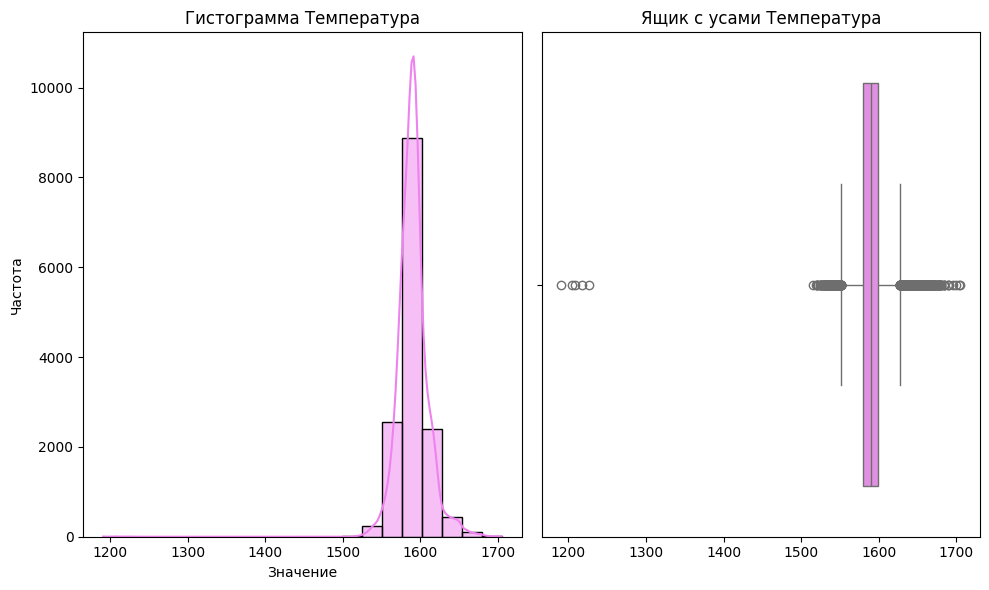

Анализ параметра: Температура



count         mean        std     min     25%     50%     75%  \
Температура  14665.0  1590.722741  20.394381  1191.0  1580.0  1590.0  1599.0   

                max  
Температура  1705.0

Пропущенные значения: 3427 (18.94%)
Уникальных значений: 172


In [27]:
for parameter in data_temp_new.columns.to_list():
        profiling(data_temp_new, parameter)

In [28]:
# переименуем переменную для удобства - temperature
data_temp_new = data_temp_new.rename(columns={'Температура':'temperature'})

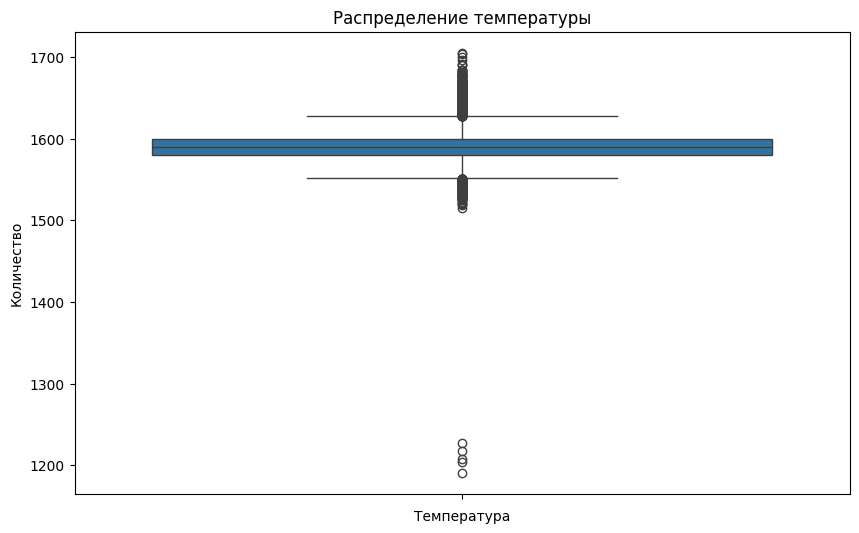

In [29]:
# Построение диаграммы ящик с усами для температуры
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_temp_new['temperature'], notch=False)


plt.title('Распределение температуры')
plt.xlabel('Температура')
plt.ylabel('Количество')
plt.show()

Значения температуры ниже 1400 градусов Цельсия - это выбросы, так как при температуре ниже 1400 градусов происходит кристаллизация сплава. Но и температура ниже 1450 должна влиять на качество сплава, так как 1450 - это температура плавления стали. Удалим наиболее аномальные значения ниже 1400, которых точно не должно быть.  
В значениях температуры много пропусков. Пропущены значения для конечной температуры сплава в ковше - у многих ковшей есть только начальная температура.

In [30]:
# Удаление выбросов температуры
odd_keys.append(data_temp_new.loc[
    (data_temp_new['temperature'].isna()) | 
    (data_temp_new['temperature'] <= 1400),
    'key'
].unique())
# Удаляем все записи этих ковшей из датафрейма
data_temp_new = data_temp_new[~data_temp_new['key'].isin(odd_keys)]
data_arc_new = data_arc_new[~data_arc_new['key'].isin(odd_keys)]
print(f"Удалено ковшей: {len(odd_keys)}")


Удалено ковшей: 2


In [31]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18087 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18087 non-null  int64  
 1   Время замера  18087 non-null  object 
 2   temperature   14660 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 565.2+ KB


Пропуски приходятся на конечную температуру, поэтому нужно постараться не потерять важную информацию - проверим, что можно сделать.

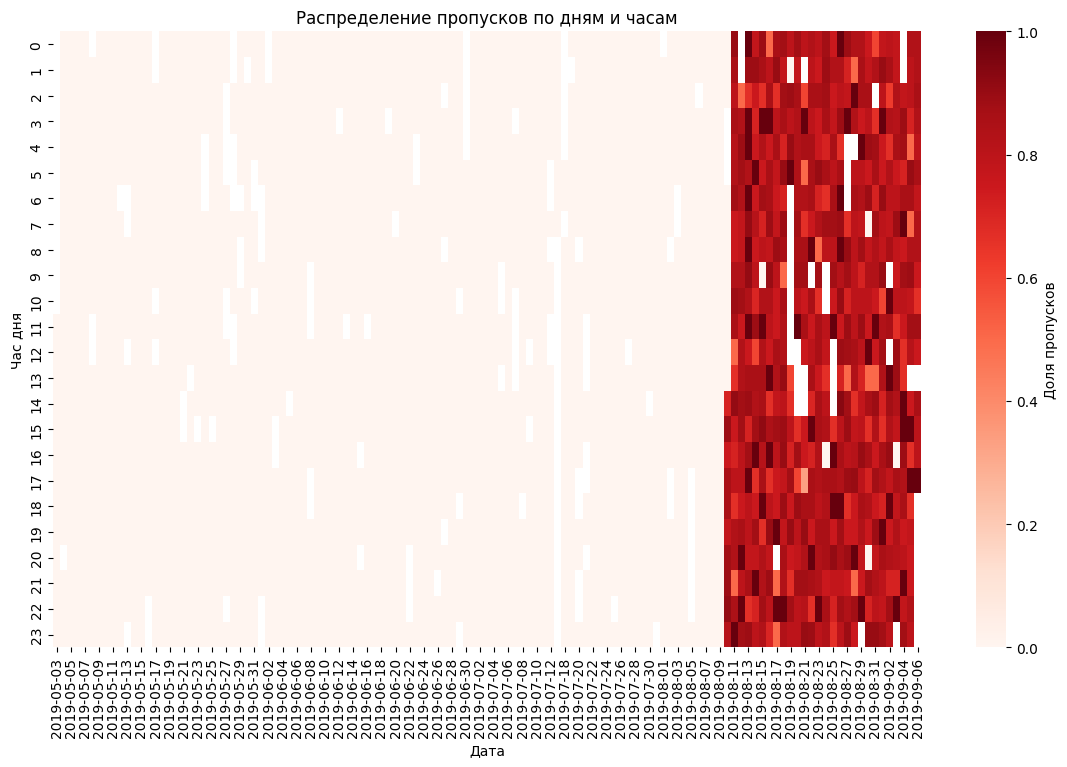

In [32]:
# Создаем календарные признаки
data_temp_new['Время замера'] = pd.to_datetime(data_temp_new['Время замера'])
data_temp_new['date'] = data_temp_new['Время замера'].dt.date
data_temp_new['hour'] = data_temp_new['Время замера'].dt.hour

# Агрегируем пропуски по дням и часам
missing_heatmap = data_temp_new.groupby(['date', 'hour'])['temperature'].apply(
    lambda x: x.isna().mean()
).unstack()

plt.figure(figsize=(14, 8))
sns.heatmap(missing_heatmap.T, cmap='Reds', cbar_kws={'label': 'Доля пропусков'})
plt.title('Распределение пропусков по дням и часам')
plt.xlabel('Дата')
plt.ylabel('Час дня')
plt.show()

In [33]:
cutoff_date = pd.to_datetime('2019-08-10')
before = data_temp_new[data_temp_new['Время замера'] < cutoff_date]
after = data_temp_new[data_temp_new['Время замера'] >= cutoff_date]

print(f"До 10 августа: {len(before)} замеров, пропусков: {before['temperature'].isna().sum()} ({before['temperature'].isna().mean():.2%})")
print(f"После 10 августа: {len(after)} замеров, пропусков: {after['temperature'].isna().sum()} ({after['temperature'].isna().mean():.2%})")

До 10 августа: 13849 замеров, пропусков: 0 (0.00%)
После 10 августа: 4238 замеров, пропусков: 3427 (80.86%)


In [34]:
# Находим индекс последнего измерения для каждой партии
last_idx = data_temp_new.groupby('key')['Время замера'].idxmax()
# Для каждой партии находим последний замер температуры
final_temp = data_temp_new.loc[last_idx]

# Проверяем распределение пропусков
print(f"Доля пропусков в конечной температуре: {final_temp['temperature'].isna().mean()}")

Доля пропусков в конечной температуре: 0.22986003110419906


Достаточно много пропусков в конечной (предсказываемой) температуре сплава.    
Заполнять медианным значением по партиям или каким-либо образом предсказывать конечную температуру на этапе подготовки данных выглядит нелогичным, так как это понижает надежность значений, на которых будет обучаться модель. К сожалению, данные без целевого признака нужно удалить.

In [35]:
# Удалим партии без замеров конечных температур, так как они неинформативны
na_keys = final_temp[final_temp['temperature'].isna()]['key'].unique()
data_temp_new = data_temp_new[~data_temp_new['key'].isin(na_keys)]
# Удалим оставшиеся пропуски температуры
data_temp_new = data_temp_new.dropna()

Добавим признаки конечная и начальная температура партии.

In [36]:
# Сортируем данные по времени для каждой партии
data_temp_sorted = data_temp_new.sort_values(['key', 'Время замера'])
# Находим начальную температуру для каждой партии
data_temp_new['initial_temp'] = data_temp_new.groupby('key')['temperature'].transform('first')
# Находим конечную температуру для каждой партии
data_temp_new['final_temp'] = data_temp_new.groupby('key')['temperature'].transform('last')

In [37]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13921 entries, 0 to 13925
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13921 non-null  int64         
 1   Время замера  13921 non-null  datetime64[ns]
 2   temperature   13921 non-null  float64       
 3   date          13921 non-null  object        
 4   hour          13921 non-null  int32         
 5   initial_temp  13921 non-null  float64       
 6   final_temp    13921 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int32(1), int64(1), object(1)
memory usage: 815.7+ KB


In [38]:
data_temp_new.head(10)

key        Время замера  temperature        date  hour  initial_temp  \
0    1 2019-05-03 11:02:04       1571.0  2019-05-03    11        1571.0   
1    1 2019-05-03 11:07:18       1604.0  2019-05-03    11        1571.0   
2    1 2019-05-03 11:11:34       1618.0  2019-05-03    11        1571.0   
3    1 2019-05-03 11:18:04       1601.0  2019-05-03    11        1571.0   
4    1 2019-05-03 11:25:59       1606.0  2019-05-03    11        1571.0   
5    1 2019-05-03 11:30:38       1613.0  2019-05-03    11        1571.0   
6    2 2019-05-03 11:34:04       1581.0  2019-05-03    11        1581.0   
7    2 2019-05-03 11:38:40       1577.0  2019-05-03    11        1581.0   
8    2 2019-05-03 11:46:09       1589.0  2019-05-03    11        1581.0   
9    2 2019-05-03 11:49:38       1604.0  2019-05-03    11        1581.0   

   final_temp  
0      1613.0  
1      1613.0  
2      1613.0  
3      1613.0  
4      1613.0  
5      1613.0  
6      1602.0  
7      1602.0  
8      1602.0  
9      1602.0

### Вывод по анализу данных

В ходе анализа предоставленных данных были рассмотрены семь датасетов, содержащих различную информацию о процессе обработки стали. Основные выводы по каждому из них:

**Данные об электродах (data_arc_new)**   
- Включают информацию о мощности нагрева дугой (активная и реактивная), а также временные интервалы работы электродов.
- Удалено аномальное значение мощности (-715).
- Активная и реактивная мощности имеют высокую корреляцию, решено добавить признаки Полной мощности, активной и реактивной энергии.
- Обнаружены дубликаты значений по key, так как нагрев дугой происходит в несколько этапов. Необходимо агрегировать данные по партиям, используя среднюю мощность и суммарную продолжительность нагрева.
- Пропуски отсутствуют. 

**Данные о сыпучих материалах (data_bulk_new)**   
- Содержат объемы подаваемых легирующих добавок (15 типов материалов), некоторые объемы добавок распределены нормально и с выделяющимися значениями.
- У многих партий присутствуют нулевые значения для некоторых добавок, что может говорить об их отсутствии в обработке. Отсутствующие значения заменены на 0.
- Скорее всего, нужно будет создать дополнительный признак для добавок, представленных в небольшом количестве. 
- Bulk 8 представлена один раз, скорее всего, не имеет значения для предсказаний.
- По key значения уникальны.

**Данные о времени подачи сыпучих материалов (data_bulk_time_new)**    
- Хранят информацию о моментах подачи тех же 15 типов сыпучих добавок.
- Для некоторых партий отсутствуют временные метки подачи, что согласованно с data_bulk_new.
- Данные такого рода можно было бы использовать для определения времени нагрева от начала и до добавления легирующей добавки, но на изменение температуры больше должна влиять масса и теплопроводность добавки, поэтому не будем использовать время в решении.
 
**Данные о проволочных материалах (data_wire_new)**  
- Содержат объемы подачи 9 типов проволочных добавок, распределение нормальное или неравномерное для различных добавок.
- Как и в случае с сыпучими материалами, у некоторых партий есть нулевые значения, что требует проверки их значимости для модели.
- Wire 5 представлена один раз, поэтому, скорее всего, не является полезной для предсказаний.
- По key значения уникальны.

**Данные о времени подачи проволочных материалов (data_wire_time_new)**   
- Аналогичны data_bulk_time_new, но относятся к проволочным материалам.   
- Как упомянуто выше, не будем использовать время для решения задачи, так как больший вклад должны внести масса и тип добавок (то есть их теплопроводность и другие свойства).

**Данные о продувке газом (data_gas_new)**   
- Содержат информацию о подаче инертного газа. Данные имеют нормальное распределение.
- Пропуски устранены.
- По key значения уникальны.


**Данные о температуре (data_temp_new)**  
- Включают временные метки замеров температуры и их значения.
- Значения менее 1400 градусов Цельсия - аномальные для процесса производства стали, поэтому принято решение удалить их.
- Количество измерений температуры варьируется для разных партий: у некоторых их больше, у других всего 1-2. Поэтому нужно будет оставить только начальное и конечное измерение для единообразия.
- После 10 августа большая часть партий содержала только начальный замер температуры, поэтому принято решение удалить пропуски.
- Для построения модели необходимо выделены начальная и конечная температура, а также можно использовать разницу между измерениями как потенциальный признак.


## Объединение данных

Объединим данные так, чтобы в объединенном датафрейме были только те ключи, которые есть во всех датафреймах.  
Для объединения нужно предварительно агрегировать значения по партиям.   

Оставим по два замера температуры для каждой партии - начальную и конечную температуру.

In [39]:
data_temp_sorted = data_temp_new.sort_values(['key', 'Время замера'])
temp = data_temp_sorted.drop_duplicates('key', keep='last').reset_index(drop=True)
# Оставим только нужные стобцы
temp = temp[['key', 'initial_temp', 'final_temp']]
temp.head()

key  initial_temp  final_temp
0    1        1571.0      1613.0
1    2        1581.0      1602.0
2    3        1596.0      1599.0
3    4        1601.0      1625.0
4    5        1576.0      1602.0

In [40]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2476 entries, 0 to 2475
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2476 non-null   int64  
 1   initial_temp  2476 non-null   float64
 2   final_temp    2476 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 58.2 KB


Для данных о нагреве дугой объединим данные по партиям, однако из-за физической природы признаков нужно агрегировать по-разному: мощности возьмем средние по партии, время нагрева и энергию возьмем суммарное.

In [41]:
arc = data_arc_new.groupby('key').agg({
    'Активная мощность': 'mean',
    'Реактивная мощность': 'mean',
    'apparent_power': 'mean',
    'duration_h': 'sum',
    'active_energy':'sum',
    'reactive_energy': 'sum'
}).reset_index()
arc.head()

key  Активная мощность  Реактивная мощность  apparent_power  duration_h  \
0    1           0.607346             0.428564        0.743747    0.305000   
1    2           0.534852             0.363339        0.647087    0.225278   
2    3           0.812728             0.587491        1.003845    0.181944   
3    4           0.676622             0.514248        0.850010    0.205833   
4    5           0.563238             0.421998        0.704245    0.241389   

   active_energy  reactive_energy  
0       0.174616         0.123469  
1       0.109800         0.076303  
2       0.161604         0.118900  
3       0.151031         0.114984  
4       0.114495         0.084186

Объединим таблицы

In [42]:
merged_data = temp.copy()
merged_data = pd.merge(merged_data, arc, on='key', how='inner')
merged_data.head()

key  initial_temp  final_temp  Активная мощность  Реактивная мощность  \
0    1        1571.0      1613.0           0.607346             0.428564   
1    2        1581.0      1602.0           0.534852             0.363339   
2    3        1596.0      1599.0           0.812728             0.587491   
3    4        1601.0      1625.0           0.676622             0.514248   
4    5        1576.0      1602.0           0.563238             0.421998   

   apparent_power  duration_h  active_energy  reactive_energy  
0        0.743747    0.305000       0.174616         0.123469  
1        0.647087    0.225278       0.109800         0.076303  
2        1.003845    0.181944       0.161604         0.118900  
3        0.850010    0.205833       0.151031         0.114984  
4        0.704245    0.241389       0.114495         0.084186

In [43]:
merged_data = pd.merge(merged_data, data_bulk_new, on='key', how='inner')
merged_data = pd.merge(merged_data, data_wire_new, on='key', how='inner')
merged_data = pd.merge(merged_data, data_gas_new, on='key', how='inner')

# Визуализируем результат
merged_data.head()

key  initial_temp  final_temp  Активная мощность  Реактивная мощность  \
0    1        1571.0      1613.0           0.607346             0.428564   
1    2        1581.0      1602.0           0.534852             0.363339   
2    3        1596.0      1599.0           0.812728             0.587491   
3    4        1601.0      1625.0           0.676622             0.514248   
4    5        1576.0      1602.0           0.563238             0.421998   

   apparent_power  duration_h  active_energy  reactive_energy  Bulk 1  ...  \
0        0.743747    0.305000       0.174616         0.123469     0.0  ...   
1        0.647087    0.225278       0.109800         0.076303     0.0  ...   
2        1.003845    0.181944       0.161604         0.118900     0.0  ...   
3        0.850010    0.205833       0.151031         0.114984     0.0  ...   
4        0.704245    0.241389       0.114495         0.084186     0.0  ...   

      Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  Wire 9  \
0  60.059998  0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1  96.052315  0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2  91.160157  0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3  89.063515  0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4  89.238236  9.11456     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

         gas  
0  29.749986  
1  12.555561  
2  28.554793  
3  18.841219  
4   5.413692  

[5 rows x 35 columns]

In [44]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  2328 non-null   int64  
 1   initial_temp         2328 non-null   float64
 2   final_temp           2328 non-null   float64
 3   Активная мощность    2328 non-null   float64
 4   Реактивная мощность  2328 non-null   float64
 5   apparent_power       2328 non-null   float64
 6   duration_h           2328 non-null   float64
 7   active_energy        2328 non-null   float64
 8   reactive_energy      2328 non-null   float64
 9   Bulk 1               2328 non-null   float64
 10  Bulk 2               2328 non-null   float64
 11  Bulk 3               2328 non-null   float64
 12  Bulk 4               2328 non-null   float64
 13  Bulk 5               2328 non-null   float64
 14  Bulk 6               2328 non-null   float64
 15  Bulk 7               2328 non-null   f

Объединены данные 5 датафреймов (data_temp_new, data_arc_new, data_bulk_new, data_wire_new, data_gas_new) с помощью merge (inner) по номеру партии key так,   
 чтобы в объединенном датафрейме data_merged остались только те ключи, которые есть во всех датафреймах.   
Так количество измерений некоторых параметров отличается в разных партиях, данные по нагреву дугой объеденены по партии следующим образом: по мощности усреднены, по времени и энергии суммированы.   
Температура оставлена начальная и конечная.

## Исследовательский анализ и предобработка данных объединённого датафрейма

Проанализируем объединенный датафрейм, посмотрим на связь между признаками, удалим ненужные 

Данные по добавкам Bulk 8, Wire 5 имеют только одно значение, поэтому удалим их.

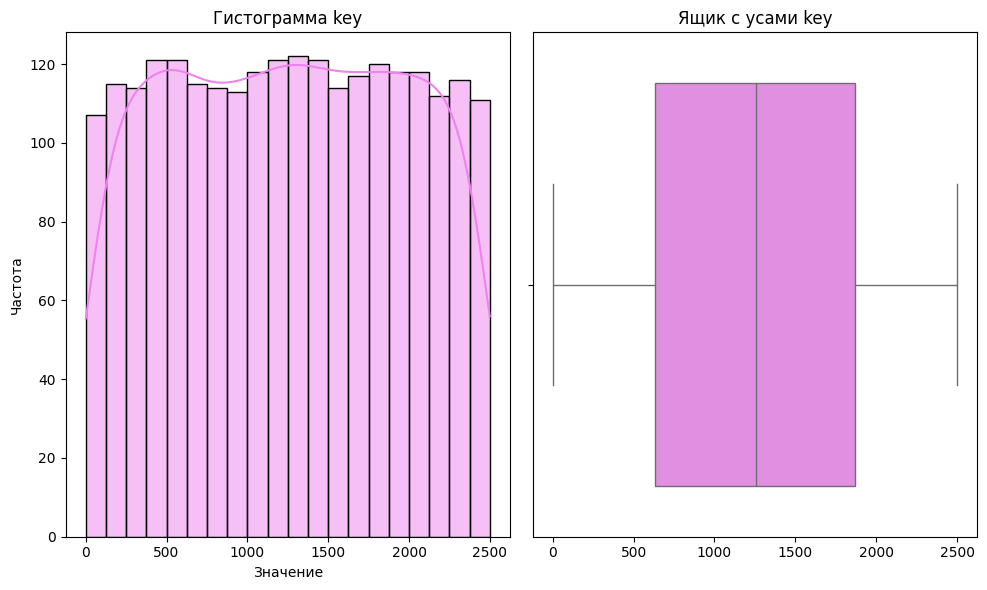

Анализ параметра: key



count        mean         std  min     25%     50%      75%     max
key  2328.0  1251.46134  714.691385  1.0  629.75  1254.5  1867.25  2499.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 2328


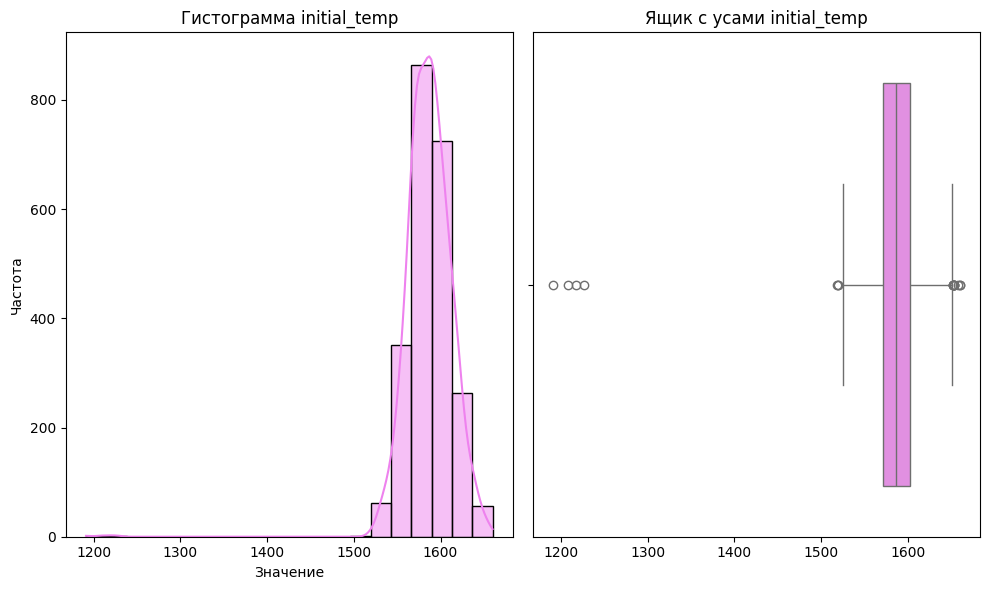

Анализ параметра: initial_temp



count         mean        std     min     25%     50%     75%  \
initial_temp  2328.0  1586.722079  28.296417  1191.0  1571.0  1587.0  1603.0   

                 max  
initial_temp  1660.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 137


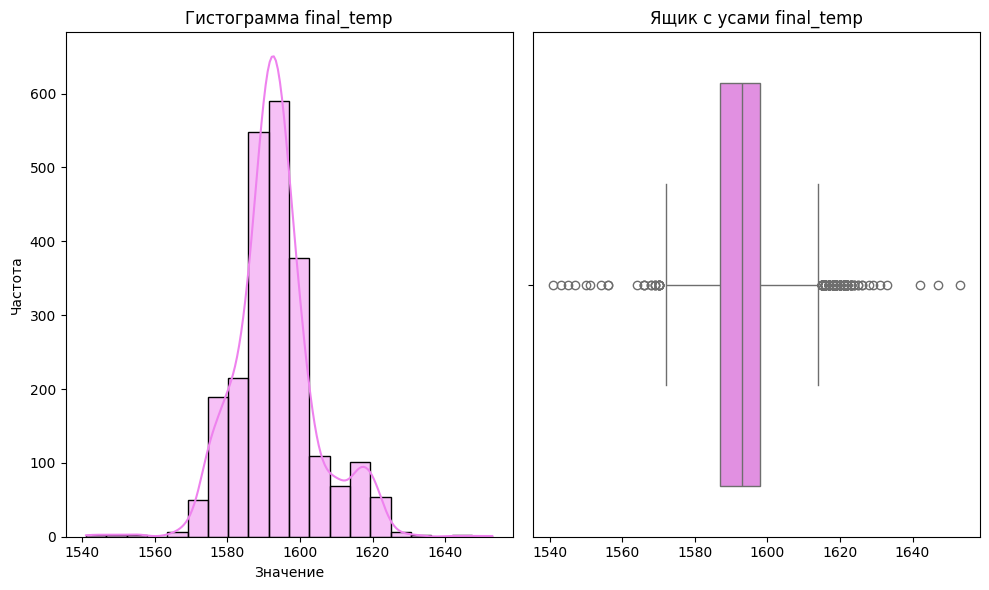

Анализ параметра: final_temp



count         mean        std     min     25%     50%     75%  \
final_temp  2328.0  1593.371993  11.198791  1541.0  1587.0  1593.0  1598.0   

               max  
final_temp  1653.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 75


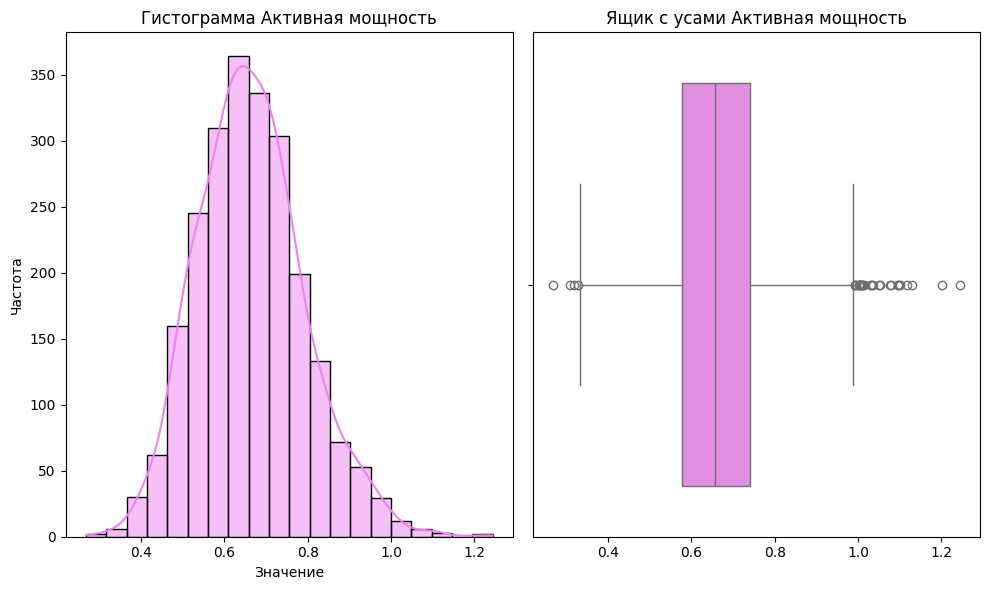

Анализ параметра: Активная мощность



count      mean       std       min       25%       50%  \
Активная мощность  2328.0  0.664104  0.128377  0.267676  0.576159  0.655834   

                        75%       max  
Активная мощность  0.741641  1.243889

Пропущенные значения: 0 (0.00%)
Уникальных значений: 2327


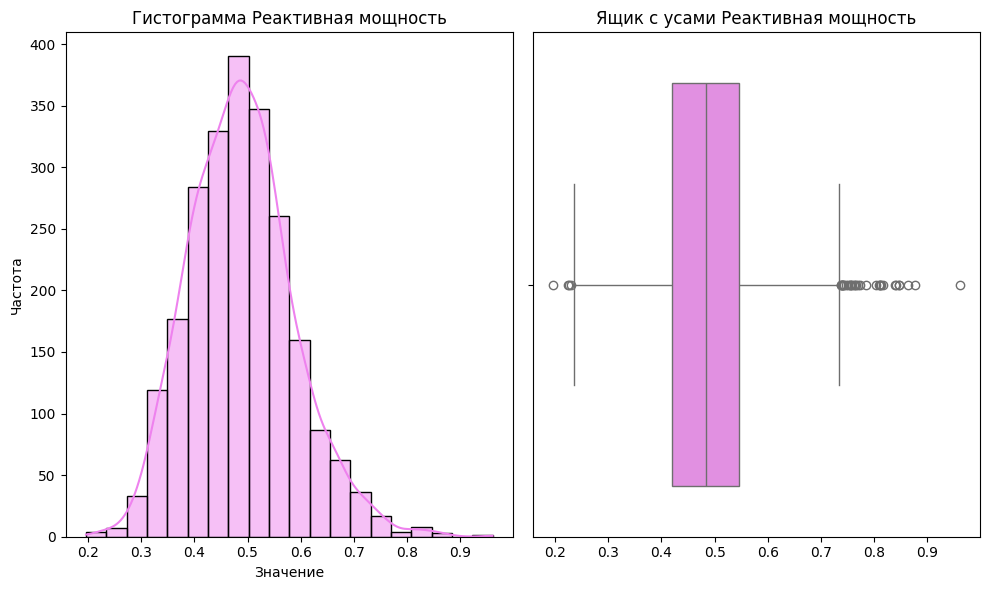

Анализ параметра: Реактивная мощность



count     mean       std       min       25%       50%  \
Реактивная мощность  2328.0  0.48889  0.097967  0.196228  0.420039  0.484669   

                          75%       max  
Реактивная мощность  0.546539  0.960763

Пропущенные значения: 0 (0.00%)
Уникальных значений: 2327


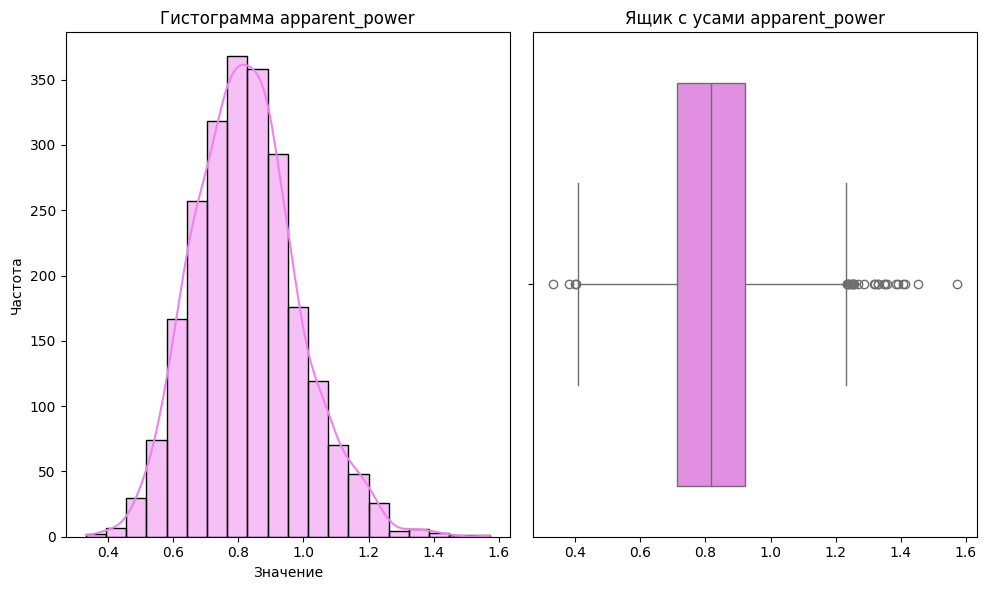

Анализ параметра: apparent_power



count      mean       std       min       25%       50%  \
apparent_power  2328.0  0.825539  0.160341  0.331897  0.714277  0.818302   

                     75%       max  
apparent_power  0.921148  1.572238

Пропущенные значения: 0 (0.00%)
Уникальных значений: 2328


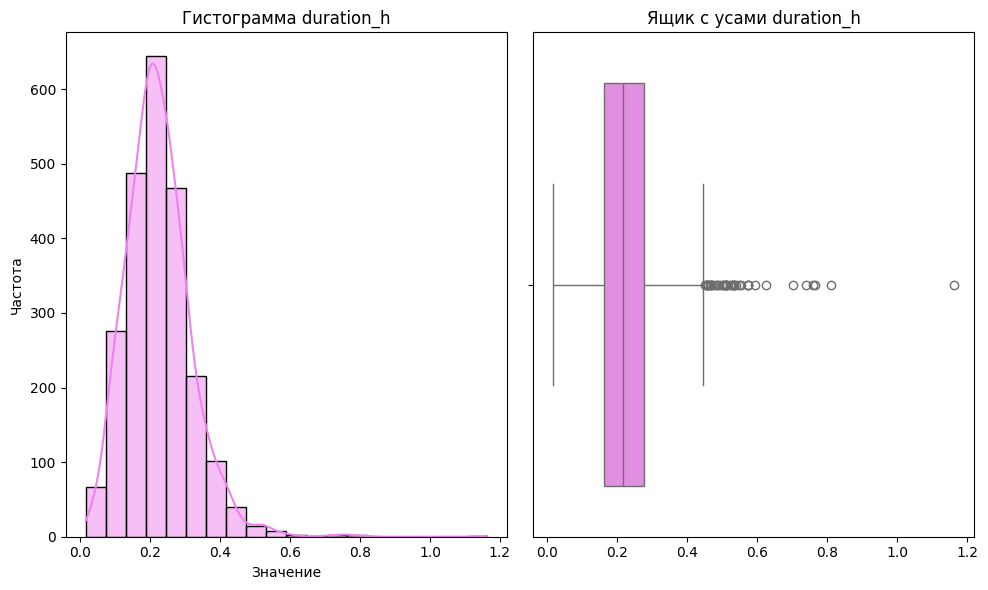

Анализ параметра: duration_h



count      mean       std       min       25%       50%  \
duration_h  2328.0  0.224391  0.094673  0.015833  0.161389  0.216111   

                 75%       max  
duration_h  0.275833  1.163611

Пропущенные значения: 0 (0.00%)
Уникальных значений: 1231


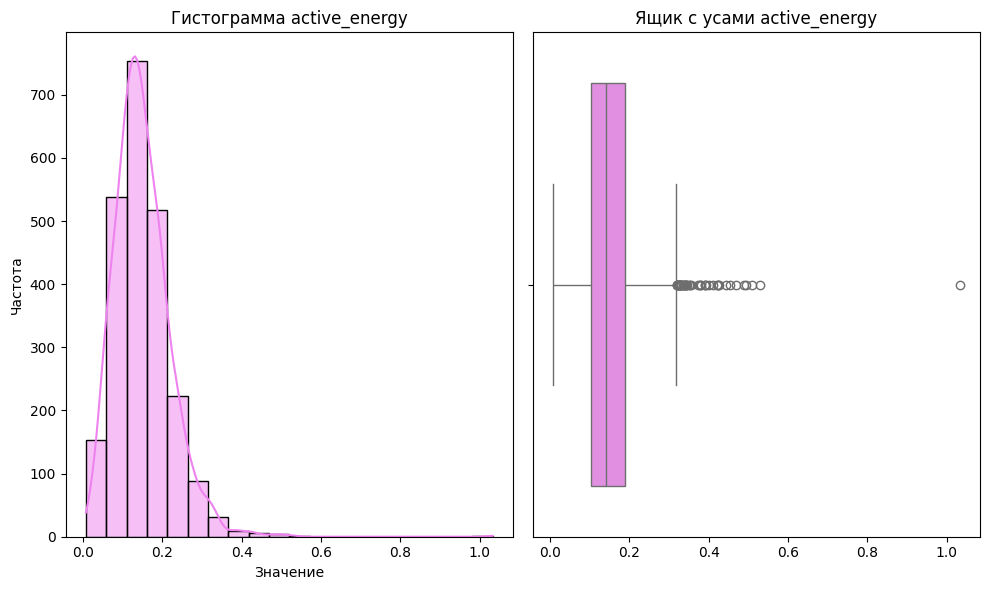

Анализ параметра: active_energy



count      mean       std       min       25%       50%  \
active_energy  2328.0  0.149752  0.071467  0.007274  0.102274  0.141184   

                    75%       max  
active_energy  0.188474  1.032793

Пропущенные значения: 0 (0.00%)
Уникальных значений: 2328


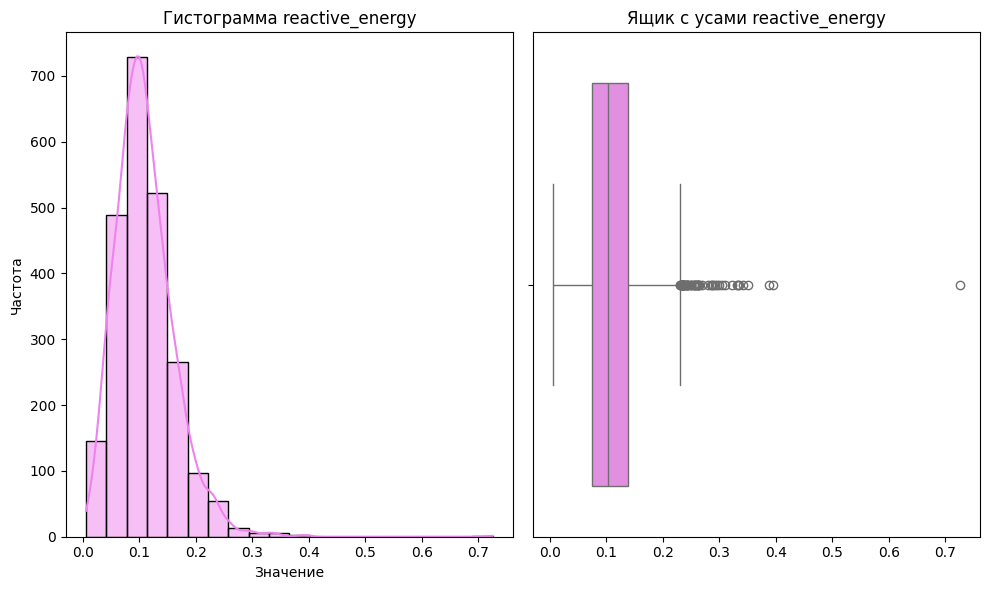

Анализ параметра: reactive_energy



count      mean       std       min       25%       50%  \
reactive_energy  2328.0  0.110133  0.052682  0.005772  0.075123  0.103249   

                      75%       max  
reactive_energy  0.137538  0.725578

Пропущенные значения: 0 (0.00%)
Уникальных значений: 2328


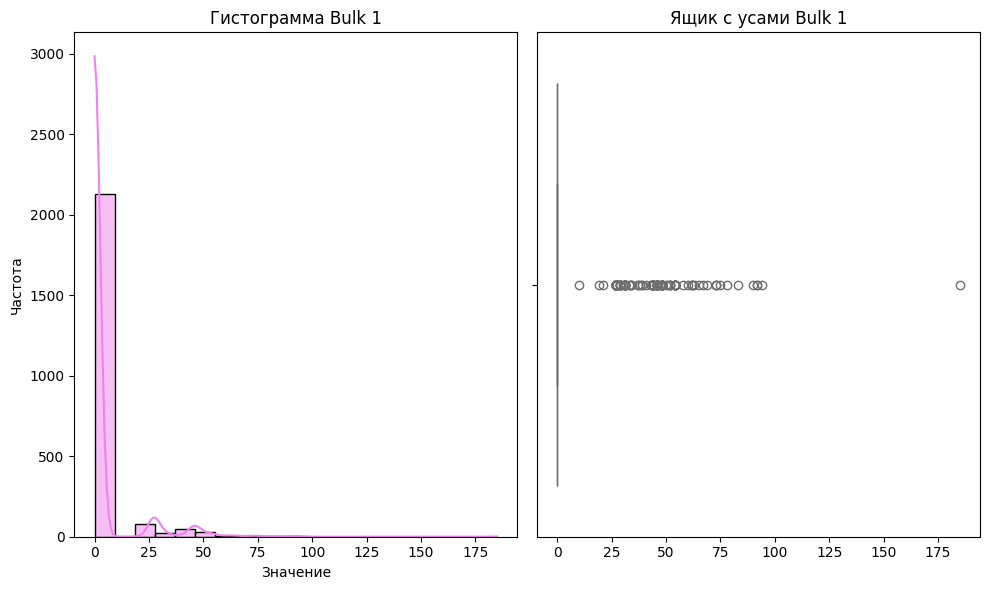

Анализ параметра: Bulk 1



count      mean        std  min  25%  50%  75%    max
Bulk 1  2328.0  3.429124  12.414595  0.0  0.0  0.0  0.0  185.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 38


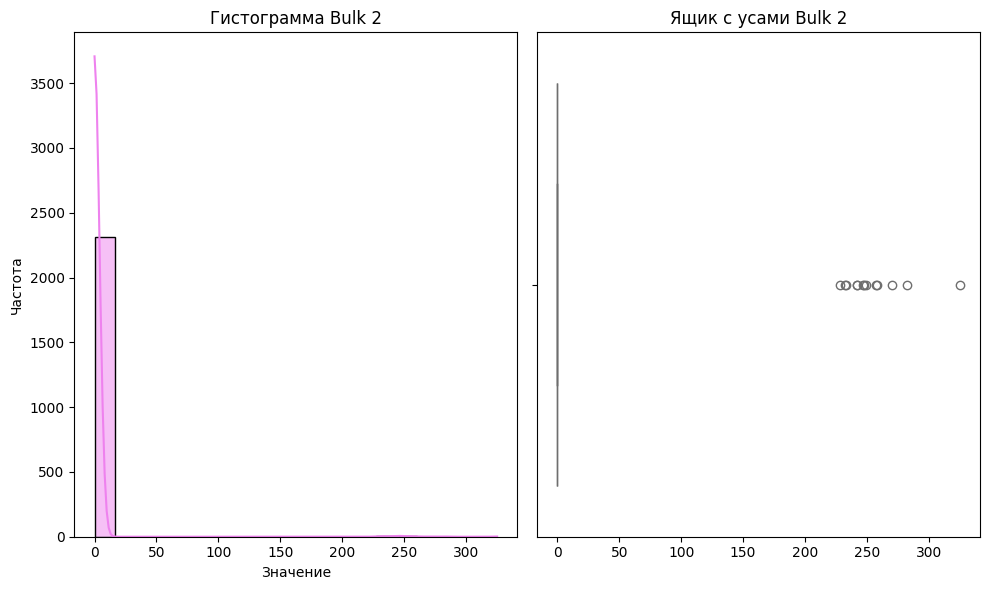

Анализ параметра: Bulk 2



count     mean        std  min  25%  50%  75%    max
Bulk 2  2328.0  1.42311  19.086196  0.0  0.0  0.0  0.0  325.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 13


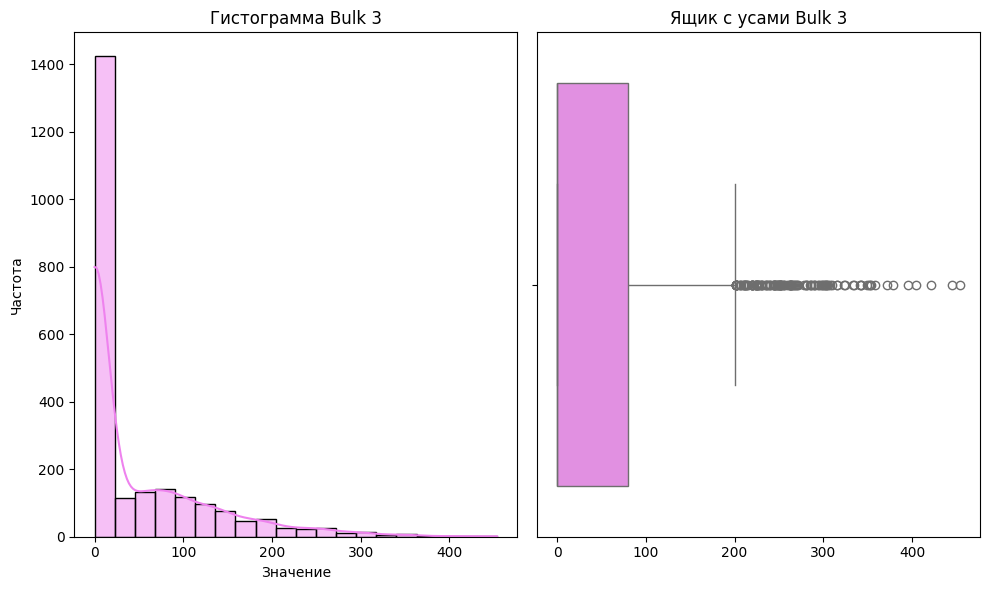

Анализ параметра: Bulk 3



count       mean        std  min  25%  50%   75%    max
Bulk 3  2328.0  47.368557  75.320213  0.0  0.0  0.0  80.0  454.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 265


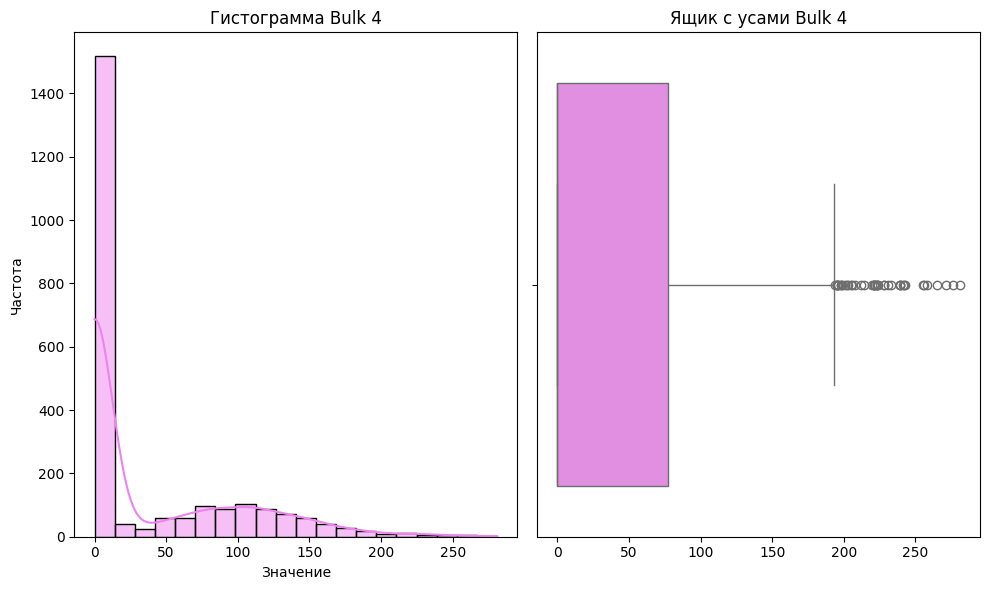

Анализ параметра: Bulk 4



count       mean        std  min  25%  50%    75%    max
Bulk 4  2328.0  37.319588  58.650737  0.0  0.0  0.0  77.25  281.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 199


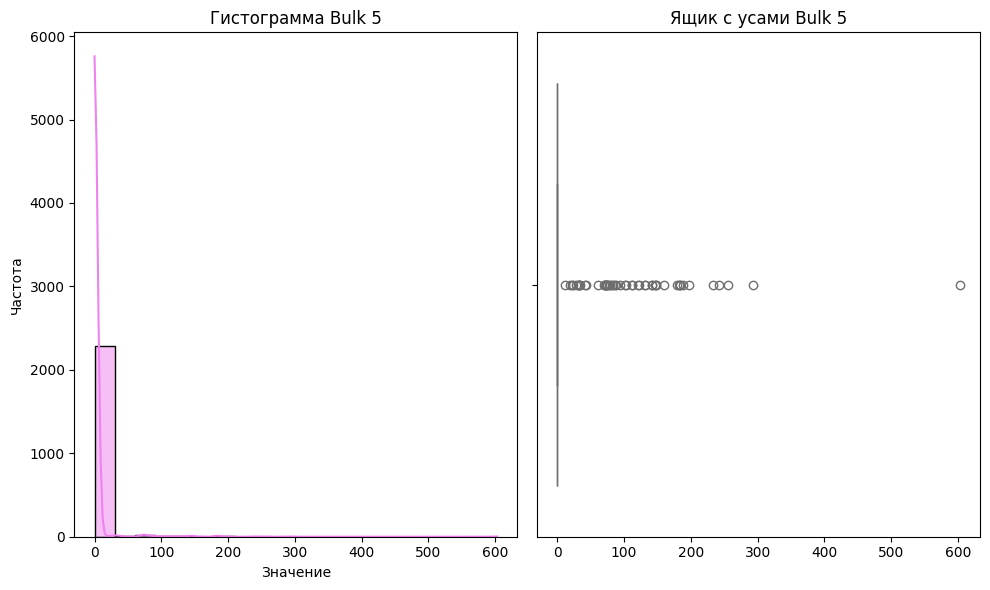

Анализ параметра: Bulk 5



count      mean       std  min  25%  50%  75%    max
Bulk 5  2328.0  2.641323  22.40704  0.0  0.0  0.0  0.0  603.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 43


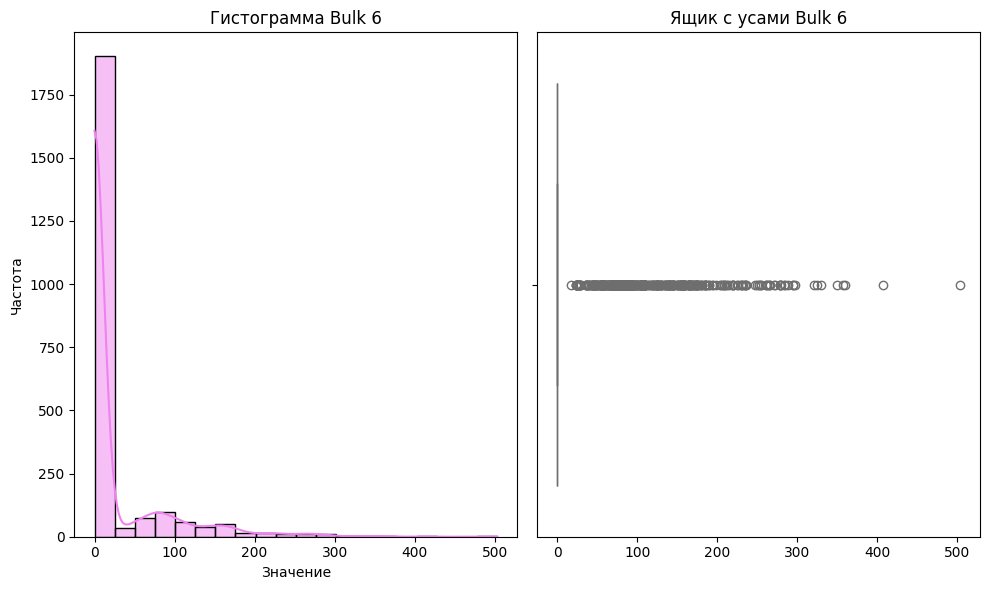

Анализ параметра: Bulk 6



count       mean        std  min  25%  50%  75%    max
Bulk 6  2328.0  22.381014  55.752272  0.0  0.0  0.0  0.0  503.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 189


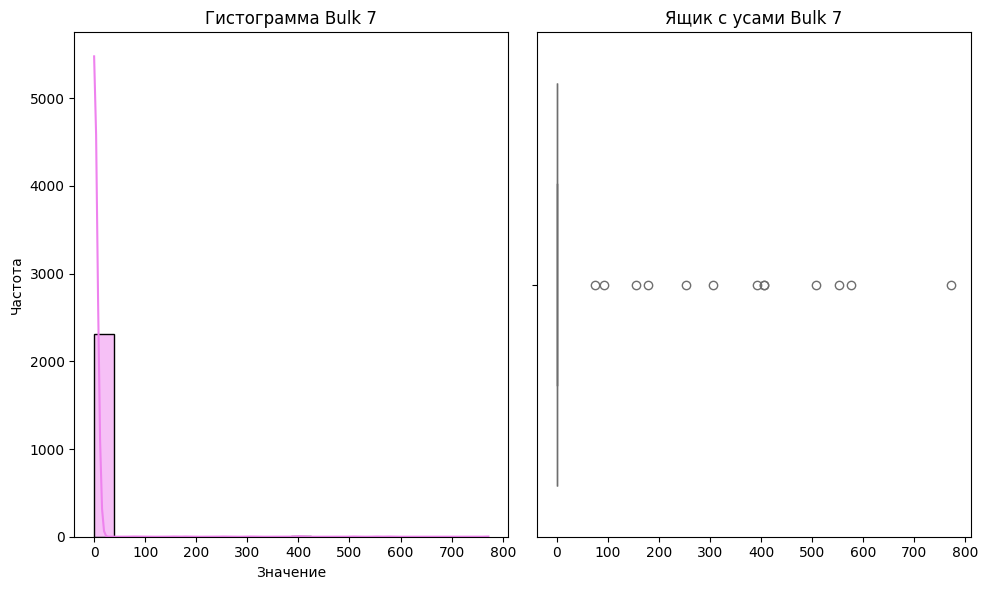

Анализ параметра: Bulk 7



count      mean        std  min  25%  50%  75%    max
Bulk 7  2328.0  2.005584  30.682797  0.0  0.0  0.0  0.0  772.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 14


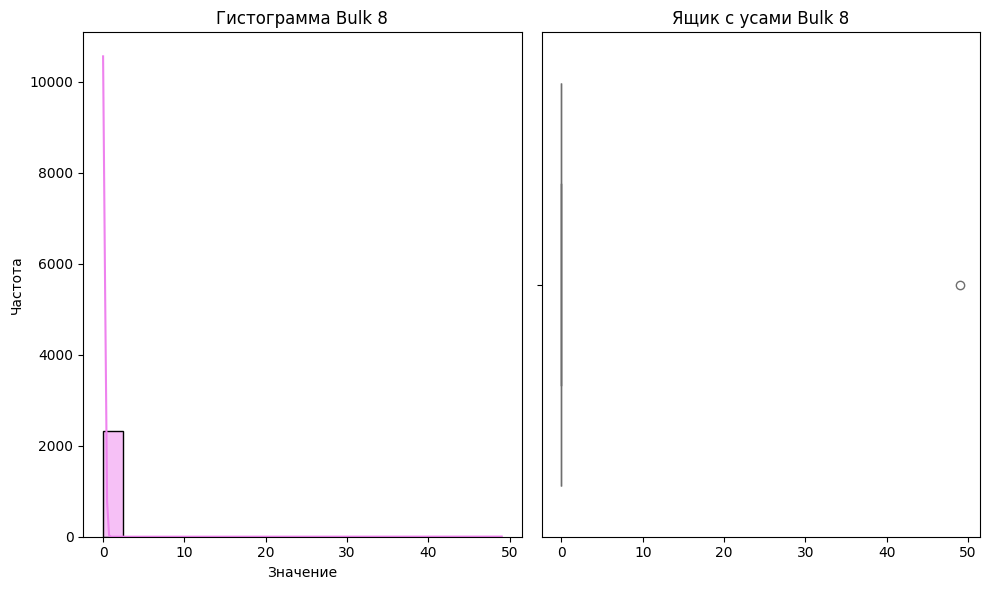

Анализ параметра: Bulk 8



count      mean       std  min  25%  50%  75%   max
Bulk 8  2328.0  0.021048  1.015558  0.0  0.0  0.0  0.0  49.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 2


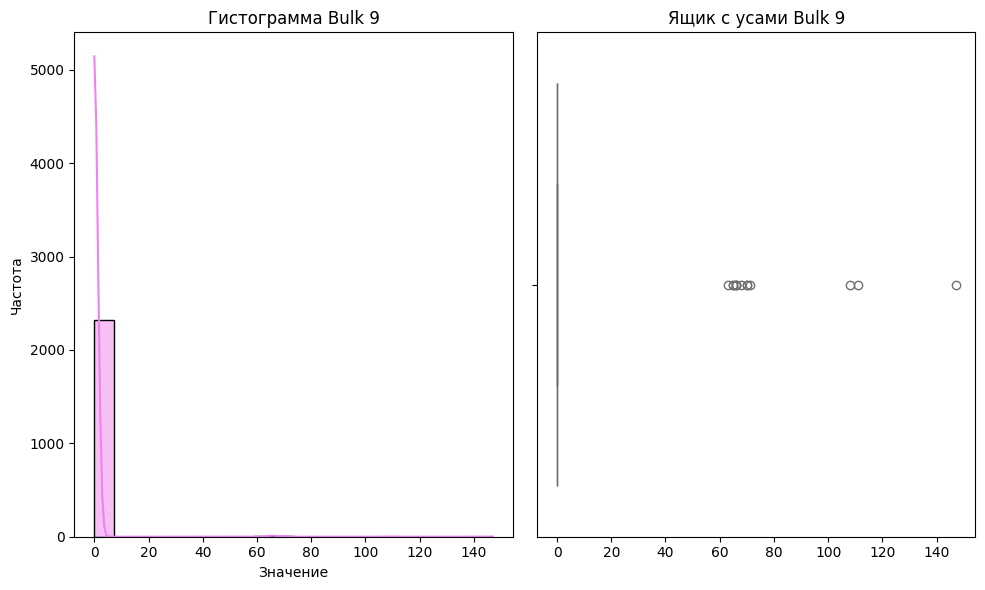

Анализ параметра: Bulk 9



count      mean       std  min  25%  50%  75%    max
Bulk 9  2328.0  0.445017  6.221971  0.0  0.0  0.0  0.0  147.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 10


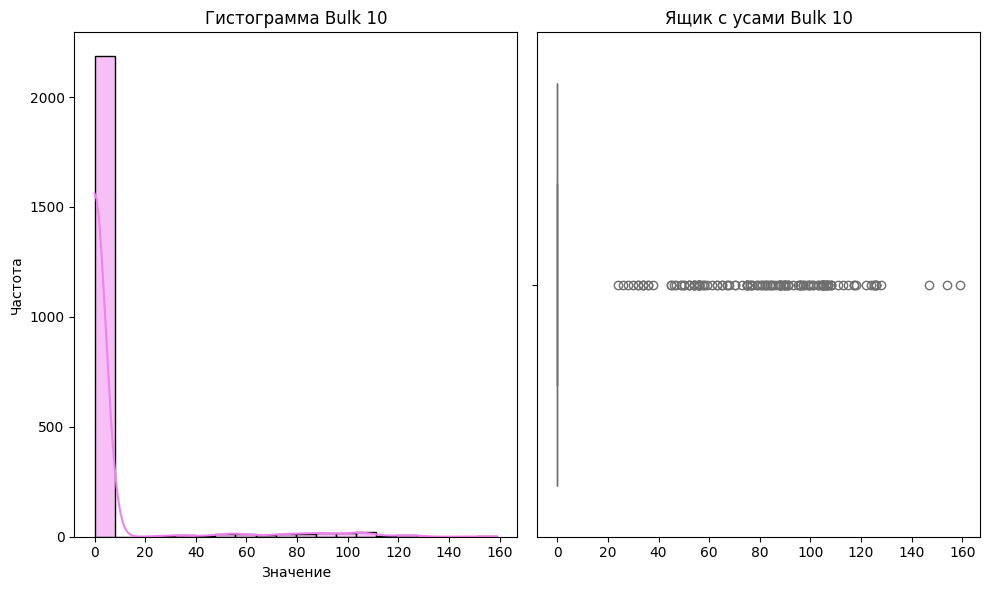

Анализ параметра: Bulk 10



count      mean        std  min  25%  50%  75%    max
Bulk 10  2328.0  5.054983  20.922031  0.0  0.0  0.0  0.0  159.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 71


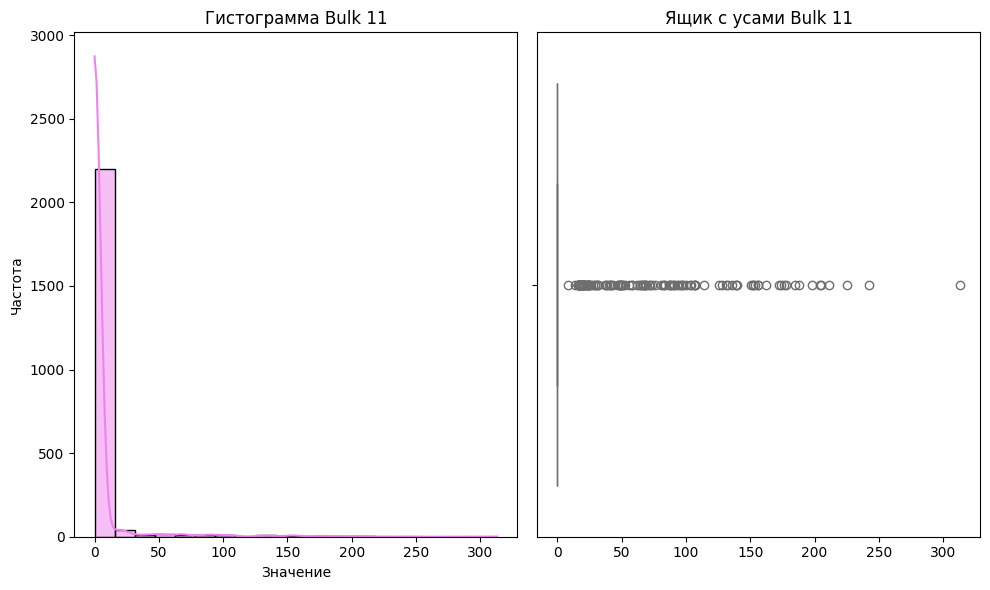

Анализ параметра: Bulk 11



count      mean        std  min  25%  50%  75%    max
Bulk 11  2328.0  4.246993  22.520153  0.0  0.0  0.0  0.0  313.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 86


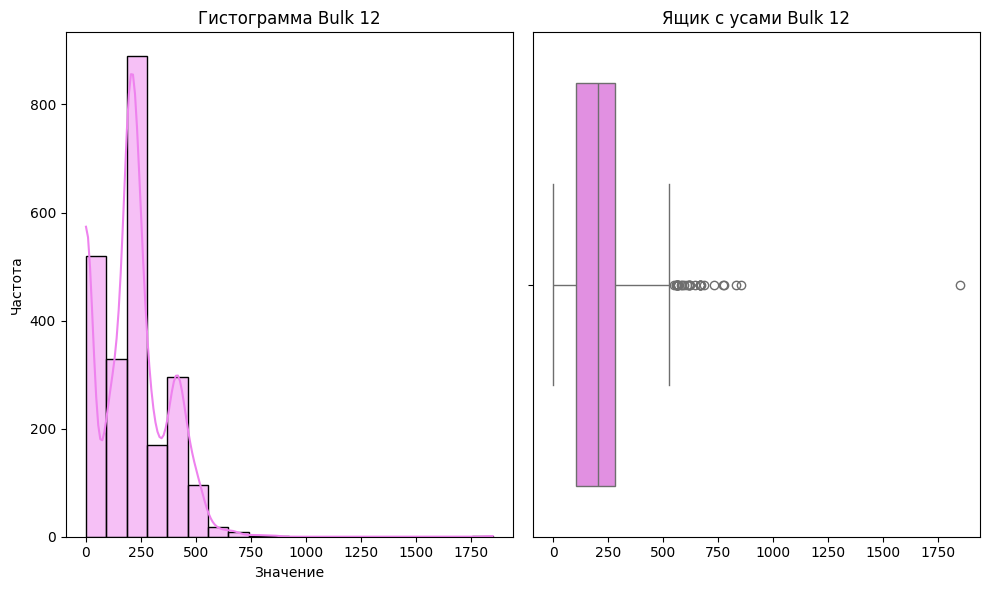

Анализ параметра: Bulk 12



count        mean         std  min    25%    50%     75%     max
Bulk 12  2328.0  208.505155  157.036569  0.0  105.0  206.0  282.25  1849.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 303


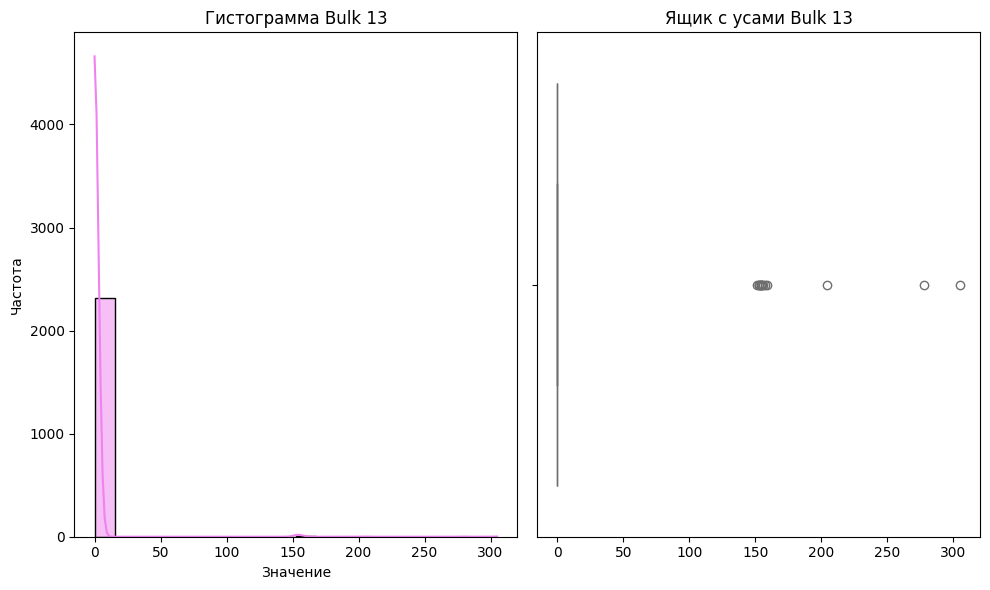

Анализ параметра: Bulk 13



count      mean        std  min  25%  50%  75%    max
Bulk 13  2328.0  1.067869  14.238096  0.0  0.0  0.0  0.0  305.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 11


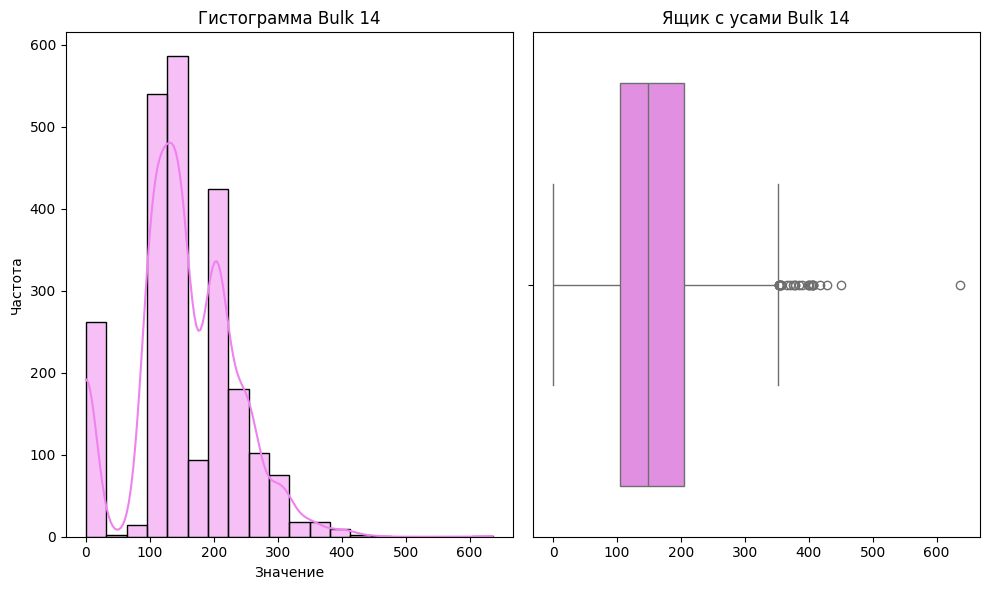

Анализ параметра: Bulk 14



count        mean        std  min    25%    50%    75%    max
Bulk 14  2328.0  153.834622  81.416698  0.0  105.0  149.0  204.0  636.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 254


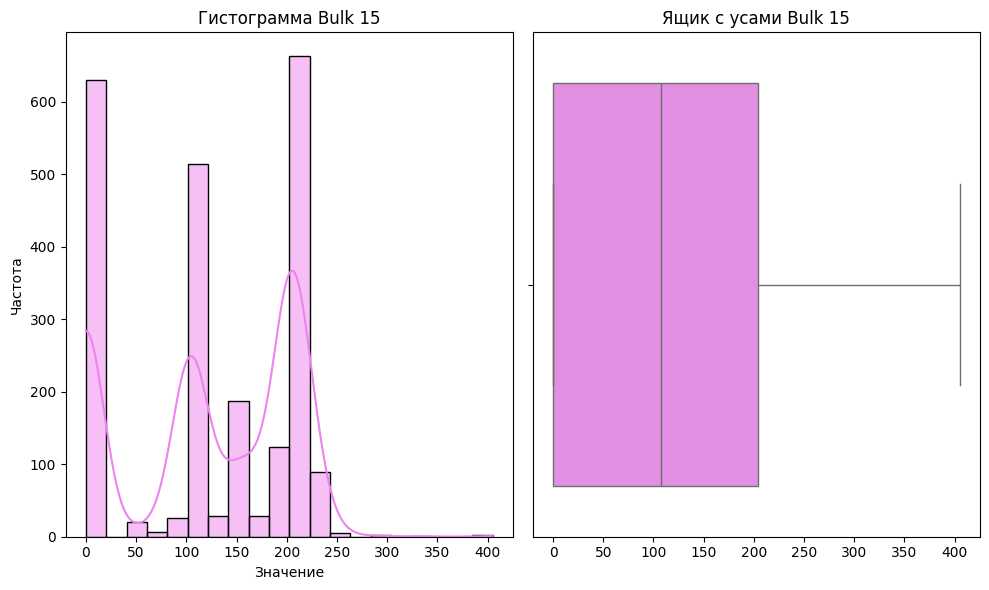

Анализ параметра: Bulk 15



count        mean        std  min  25%    50%    75%    max
Bulk 15  2328.0  120.004296  84.622085  0.0  0.0  107.0  204.0  405.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 143


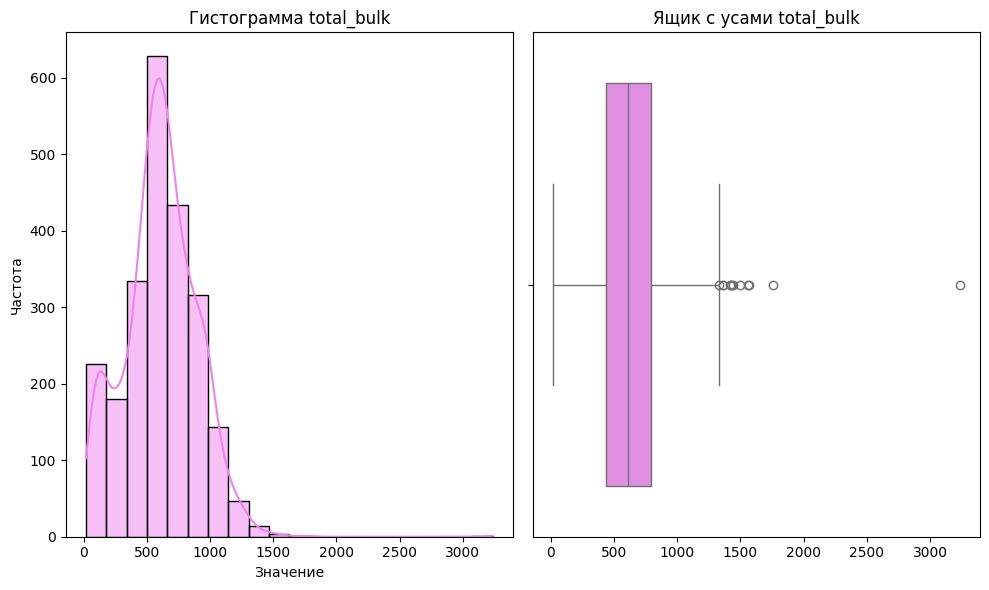

Анализ параметра: total_bulk



count        mean         std   min    25%    50%     75%     max
total_bulk  2328.0  609.748282  287.605102  19.0  440.0  609.0  795.25  3235.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 963


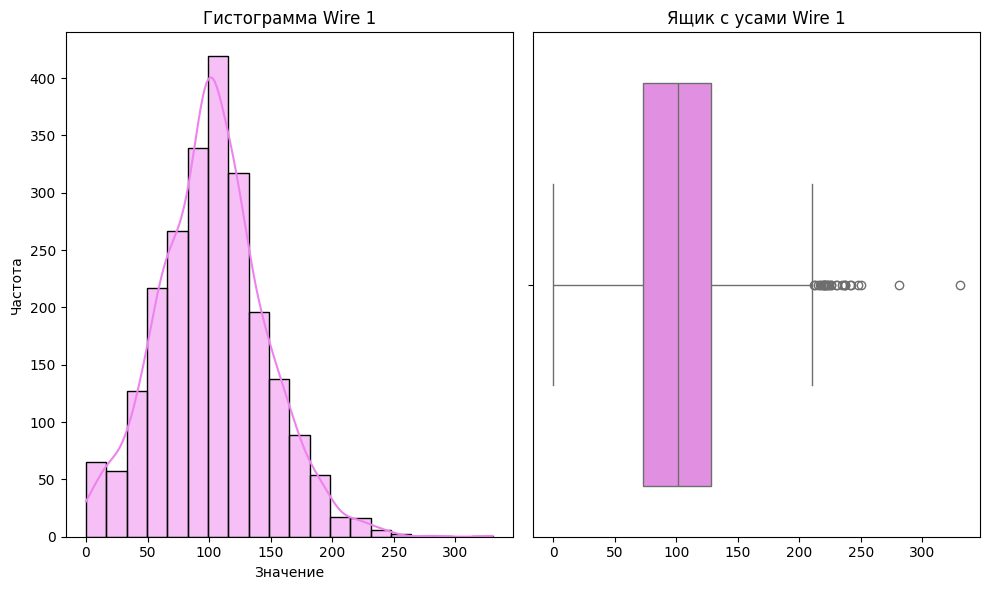

Анализ параметра: Wire 1



count        mean        std  min        25%         50%         75%  \
Wire 1  2328.0  102.455296  43.545688  0.0  73.204559  101.119202  128.097058   

               max  
Wire 1  330.314424

Пропущенные значения: 0 (0.00%)
Уникальных значений: 1812


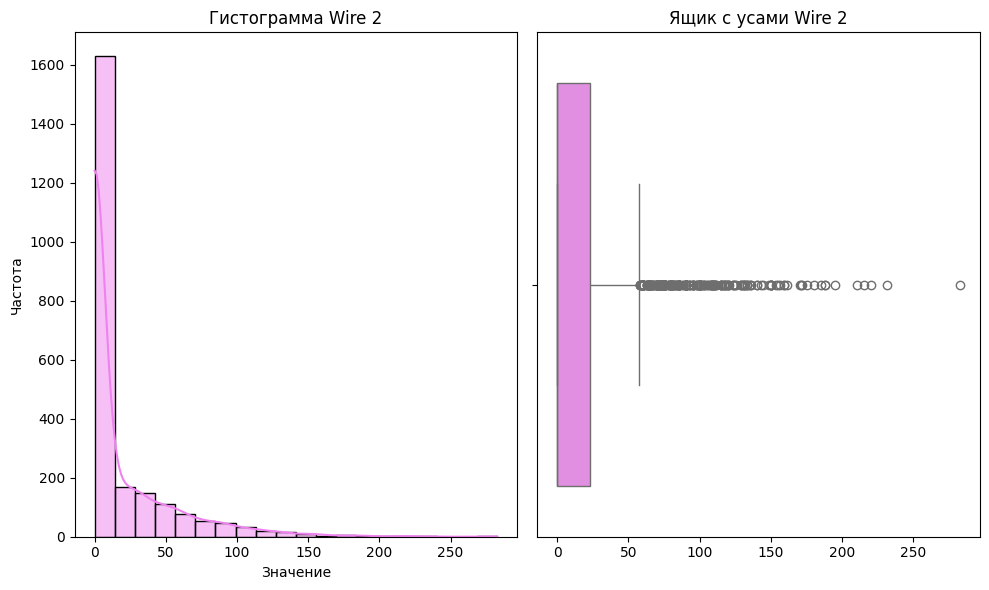

Анализ параметра: Wire 2



count       mean        std  min  25%  50%      75%         max
Wire 2  2328.0  17.617423  33.630013  0.0  0.0  0.0  23.1101  282.780152

Пропущенные значения: 0 (0.00%)
Уникальных значений: 563


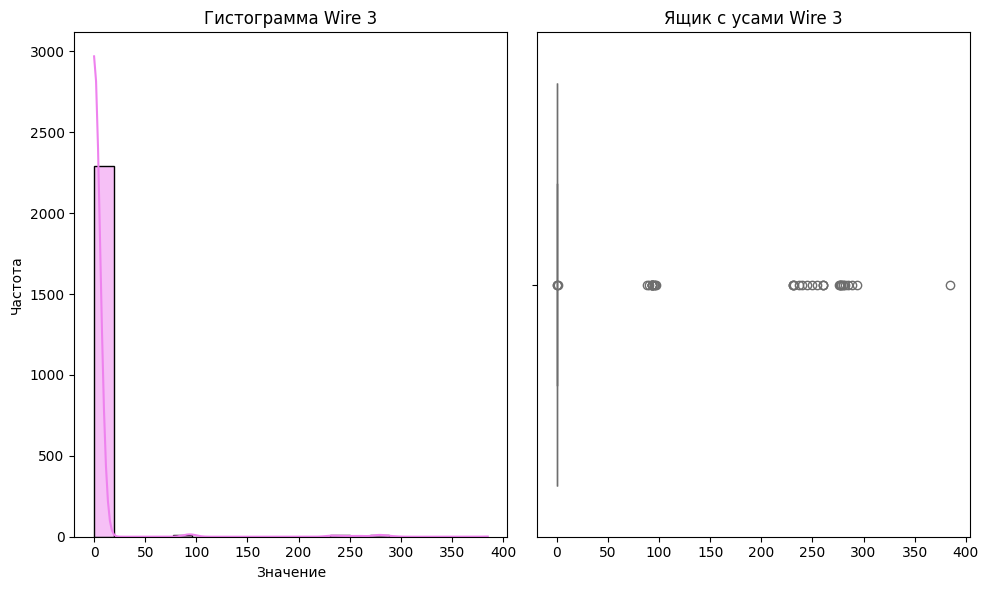

Анализ параметра: Wire 3



count      mean        std  min  25%  50%  75%         max
Wire 3  2328.0  3.236305  27.948793  0.0  0.0  0.0  0.0  385.008668

Пропущенные значения: 0 (0.00%)
Уникальных значений: 36


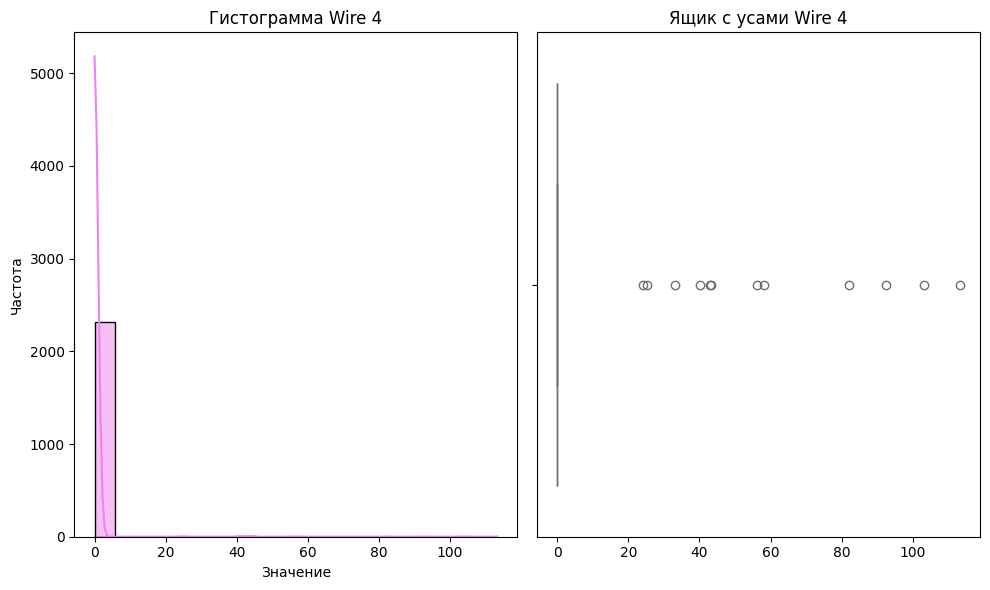

Анализ параметра: Wire 4



count      mean       std  min  25%  50%  75%         max
Wire 4  2328.0  0.306682  4.758764  0.0  0.0  0.0  0.0  113.231044

Пропущенные значения: 0 (0.00%)
Уникальных значений: 13


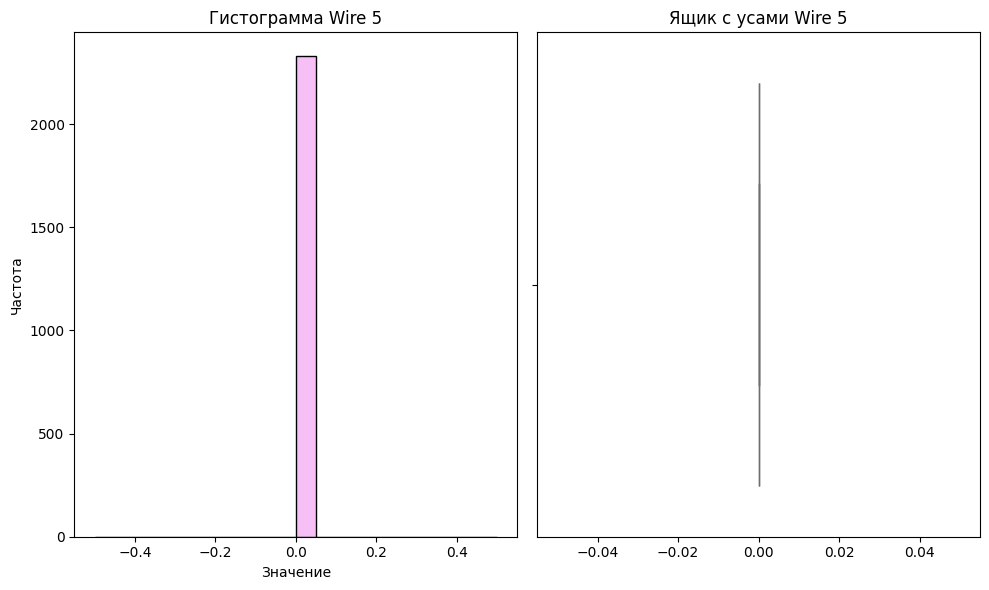

Анализ параметра: Wire 5



count  mean  std  min  25%  50%  75%  max
Wire 5  2328.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

Пропущенные значения: 0 (0.00%)
Уникальных значений: 1


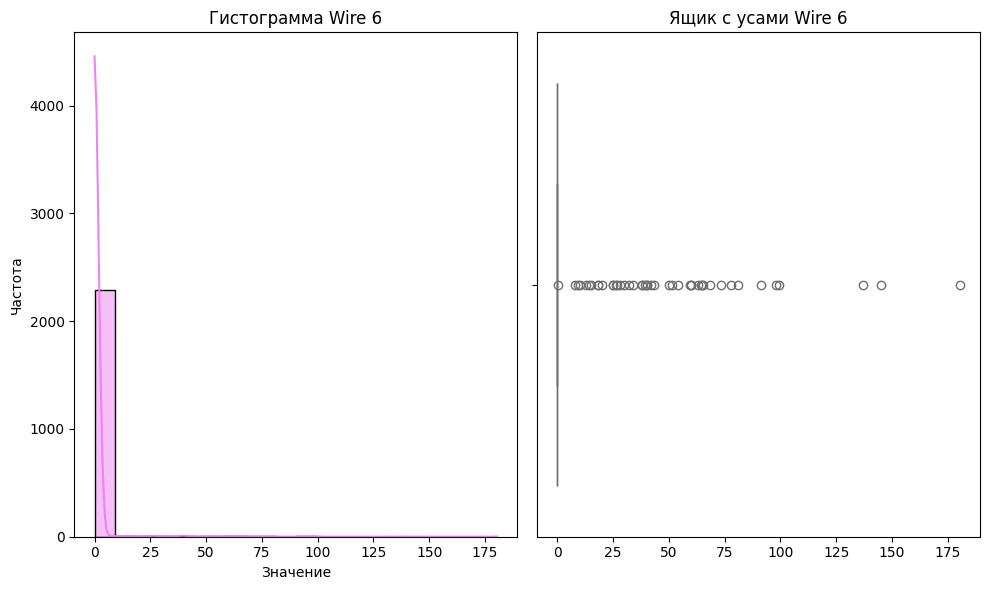

Анализ параметра: Wire 6



count     mean       std  min  25%  50%  75%         max
Wire 6  2328.0  0.97924  8.695143  0.0  0.0  0.0  0.0  180.454575

Пропущенные значения: 0 (0.00%)
Уникальных значений: 43


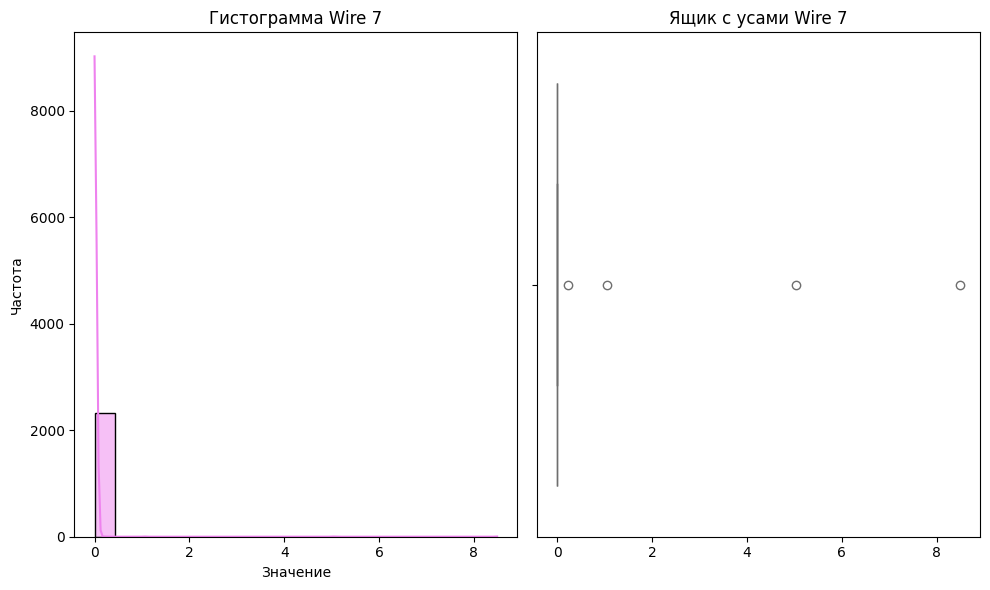

Анализ параметра: Wire 7



count      mean       std  min  25%  50%  75%      max
Wire 7  2328.0  0.006363  0.205749  0.0  0.0  0.0  0.0  8.49004

Пропущенные значения: 0 (0.00%)
Уникальных значений: 5


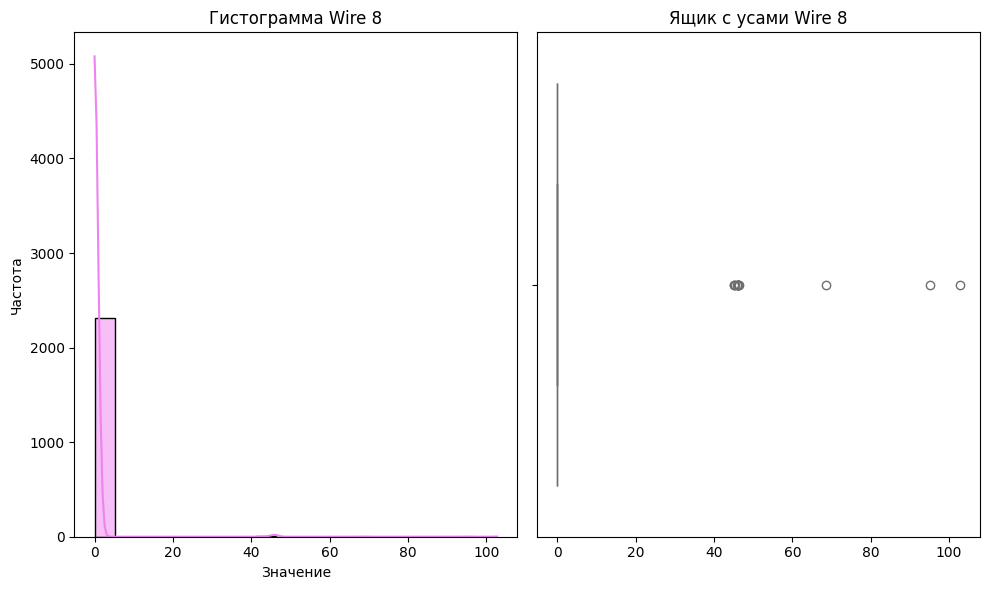

Анализ параметра: Wire 8



count      mean       std  min  25%  50%  75%         max
Wire 8  2328.0  0.311445  4.403648  0.0  0.0  0.0  0.0  102.762401

Пропущенные значения: 0 (0.00%)
Уникальных значений: 10


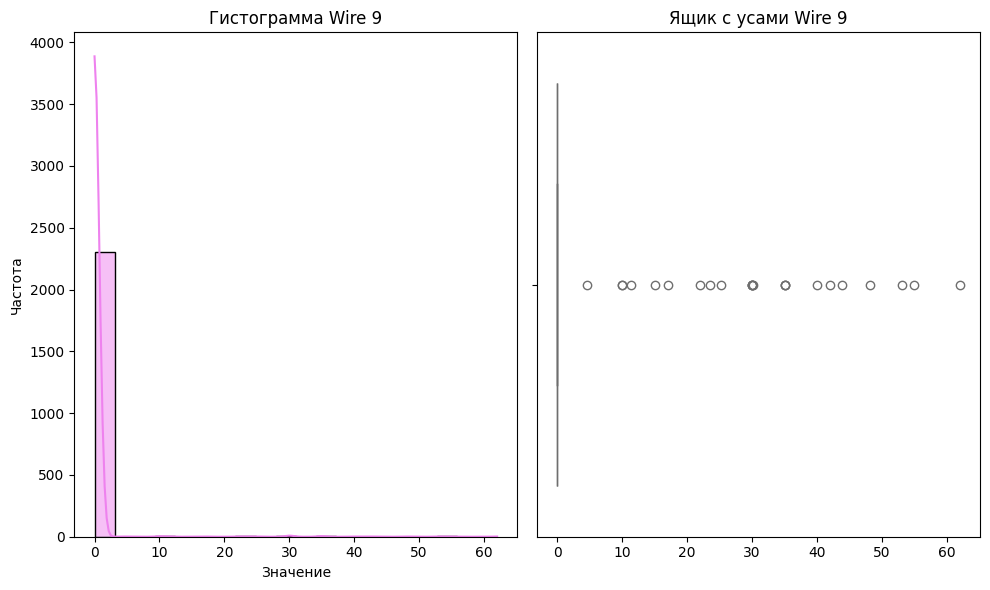

Анализ параметра: Wire 9



count      mean       std  min  25%  50%  75%      max
Wire 9  2328.0  0.317249  3.457298  0.0  0.0  0.0  0.0  62.0256

Пропущенные значения: 0 (0.00%)
Уникальных значений: 22


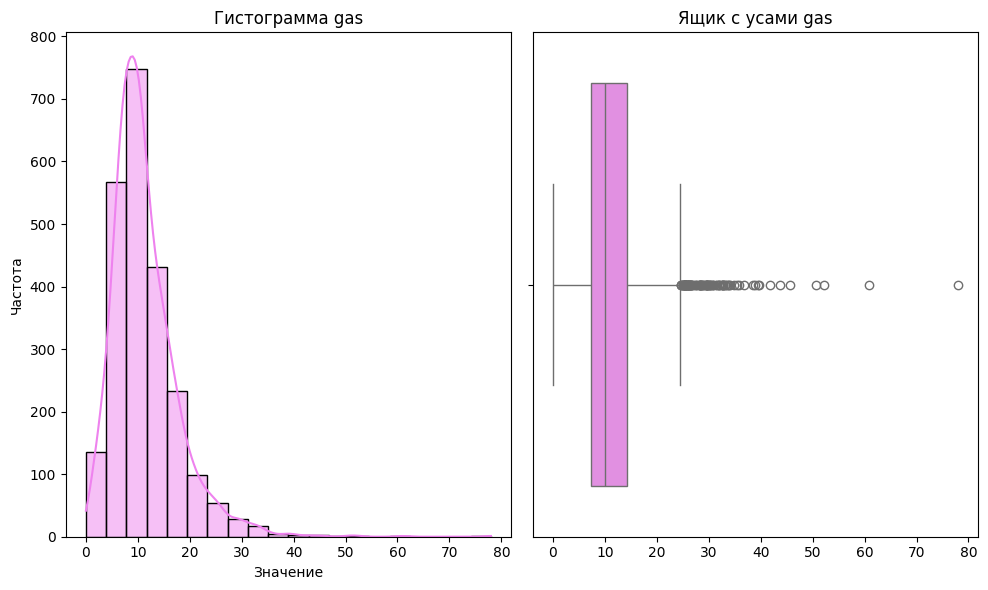

Анализ параметра: gas



count       mean       std       min       25%        50%        75%  \
gas  2328.0  11.375511  6.393413  0.008399  7.282534  10.100687  14.216939   

          max  
gas  77.99504

Пропущенные значения: 0 (0.00%)
Уникальных значений: 2328


In [45]:
for parameter in merged_data.columns.to_list():
        profiling(merged_data, parameter)

In [46]:
merged_data = merged_data.drop(columns=['Wire 5', 'Bulk 8'])

Сыпучие добавки Bulk 1, Bulk 2, Bulk 5, Bulk 7, Bulk 9, Bulk 10, Bulk 11, Bulk 13 имеют менее 5% уникальных значений, не равных нулю, поэтому объединим их как bulk_rare.

In [47]:
# Список столбцов для объединения
rare_bulk_columns = ['Bulk 1', 'Bulk 2', 'Bulk 5', 'Bulk 7', 
               'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 13']
# bulk_rare - новый столбец с редкими сыпучими добавками
merged_data['bulk_rare'] = merged_data[rare_bulk_columns].sum(axis=1)


Проволочные добавки Wire 3, Wire 4, Wire 6, Wire 7, Wire 8, Wire 9 также имеют менее 5% уникальных ненулевых значений. Объединим их в wire_rare

In [48]:
wire_rare_columns = ['Wire 3', 'Wire 4', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']
merged_data['wire_rare'] = merged_data[wire_rare_columns].sum(axis=1)


В отчете по объединенному датафрейму видно, что многие проблемы уже устранены, остались только некоторые добавки с большим количеством пропусков (но с более чем 5% данных), а также высокая корреляция между признаками.  
Отдельно проверим корреляцию и исключим признаки с коэффициентом корреляции более 0.9 во избежание мультиколлинеарности.

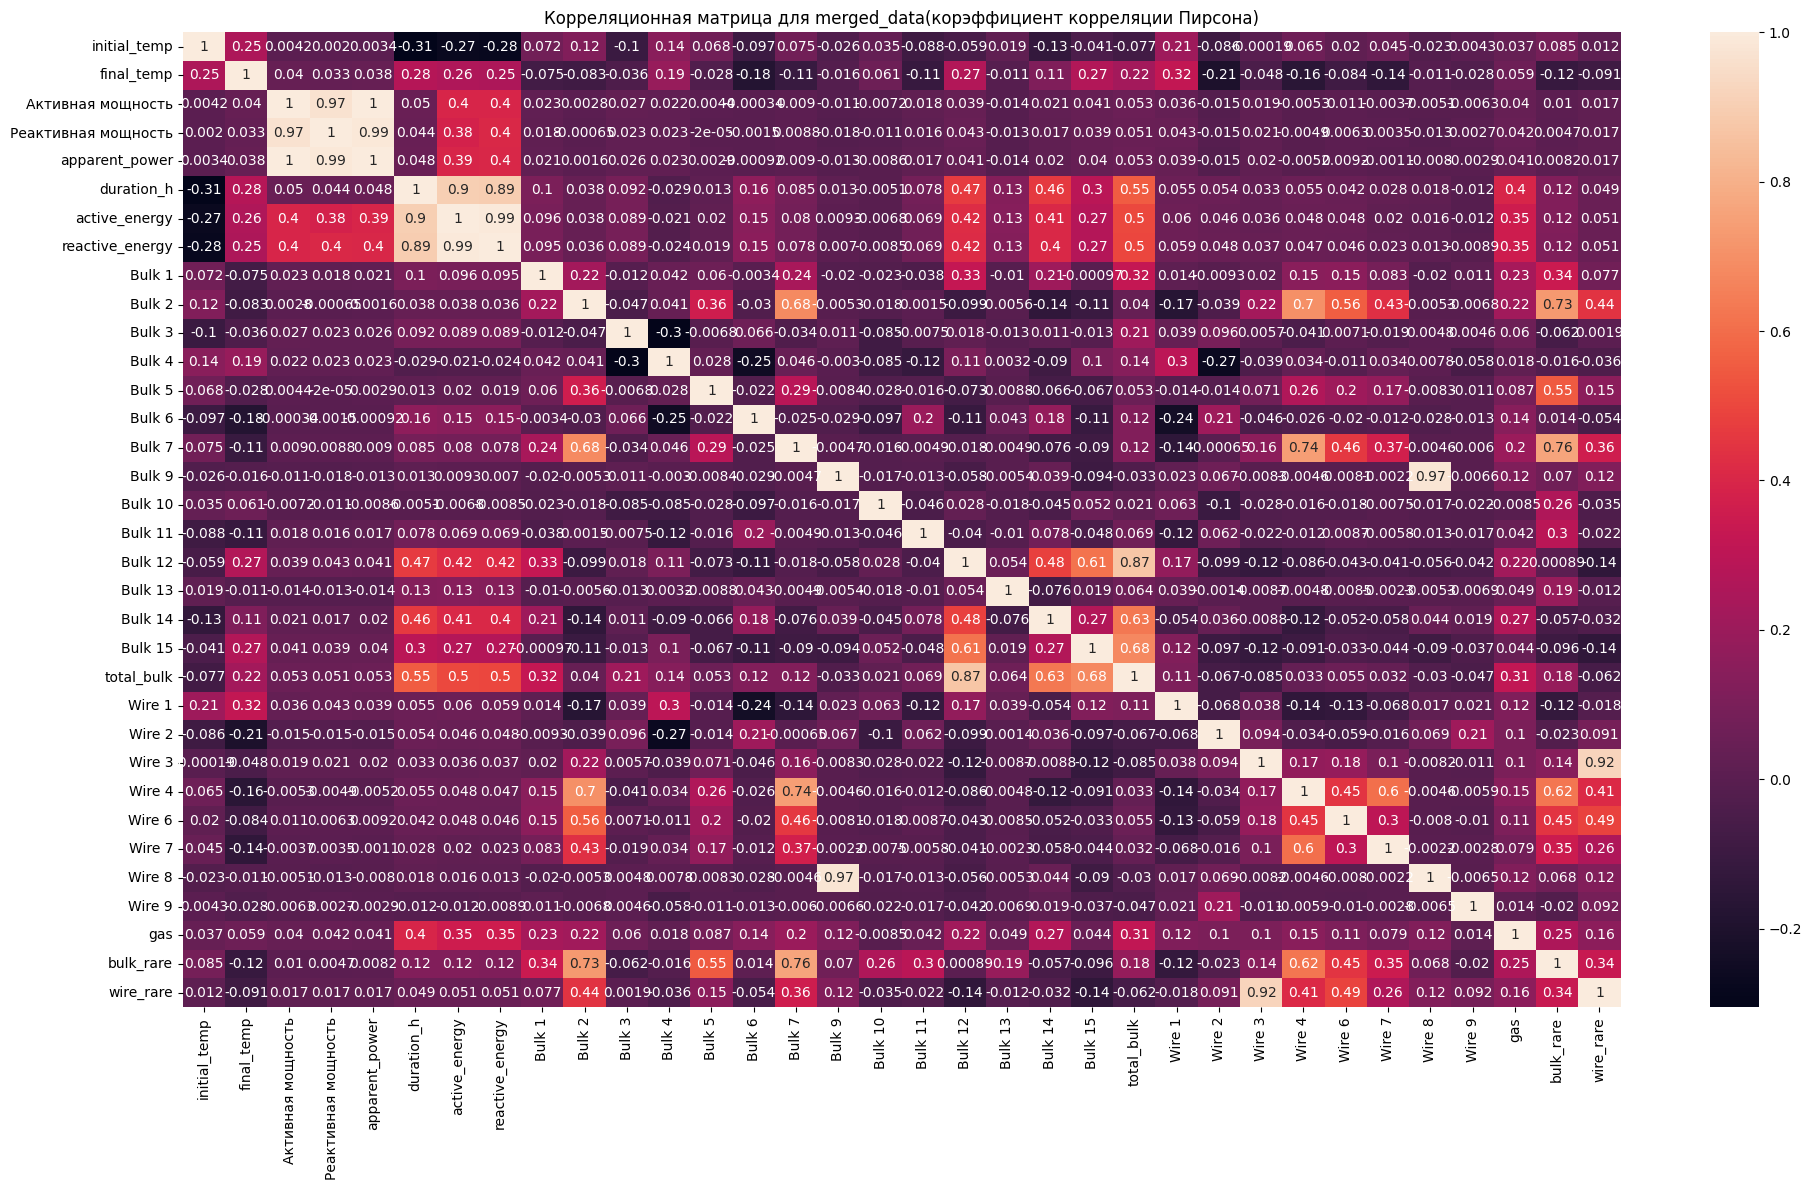

In [49]:
# Проверим корреляцию между признаками в merged_data
plt.figure(figsize=(20,12))
corr_matrix = merged_data.drop('key', axis=1).corr()
sns.heatmap(corr_matrix, 
            annot=True
)
plt.title('Корреляционная матрица для merged_data(корэффициент корреляции Пирсона)')
plt.tight_layout()  
plt.show()


Очень высокая корреляция (>0.9):   
- Активная мощность, реактивная мощность, apparent_power (полная мощность). Изначально признак apparent_power вводился для исключения высокой корреляции первых двух признаков, но коэффициент корреляции между финальной температурой и активной мощностью выше, чем для полной мощности, поэтому оставим только активную мощность. 
- Wire 3 и wire rare имеют высокую корреляцию (0.93), wire 3 удалим.
- duration_h, reactive_power, active_power имеют высокую корреляцию (0.97-0.99). Оставим duration_s как признак с самой высокой корреляцией с целевым.

Другие признаки коррелируют меньше, но линейная связь тоже высокая:  
- Bulk 12 / total_bulk - коэффициент корреляции 0.85 - скорее всего, добавлена в больших объемах. Скорее всего, лучше удалить один из этих признаков, так как близко к мультиколлинеарности.  
- Bulk 15 / total_bulk (0.67).
- Bulk 12 / Bulk 15 (0.62).
- Total bulk / duration_s (0.54) - чем больше добавок из-за несоответствия состава, тем дольше идет прогрев.  

Напрямую на финальную температуру влияют:  
- Начальная температура (0.52).
- Добавки Bulk 4, Bulk 12, Wire 1.

Есть признаки (Bulk 1,  Bulk 14, wire_rare), практически не влияющие на целевую переменную, попробуем их удалить.

In [50]:
# Переименуем Активную мощность в active_power
merged_data = merged_data.rename(columns={'Активная мощность': 'active_power'})
# Удаляем коррелирующие признаки
merged_data = merged_data.drop(columns=['apparent_power', 'Реактивная мощность', 'Wire 3', 'Bulk 12', 'reactive_energy', 'active_energy'])
# Удаляем незначительные признаки
merged_data = merged_data.drop(columns=['Bulk 14', 'wire_rare', 'Bulk 1', 'Bulk 2', 'Bulk 7', 'Bulk 9', 'Bulk 5'])

In [51]:
merged_data

key  initial_temp  final_temp  active_power  duration_h  Bulk 3  \
0        1        1571.0      1613.0      0.607346    0.305000     0.0   
1        2        1581.0      1602.0      0.534852    0.225278     0.0   
2        3        1596.0      1599.0      0.812728    0.181944     0.0   
3        4        1601.0      1625.0      0.676622    0.205833     0.0   
4        5        1576.0      1602.0      0.563238    0.241389     0.0   
...    ...           ...         ...           ...         ...     ...   
2323  2495        1570.0      1591.0      0.792033    0.200833    21.0   
2324  2496        1554.0      1591.0      0.695820    0.261111     0.0   
2325  2497        1571.0      1589.0      1.201746    0.158056     0.0   
2326  2498        1591.0      1594.0      0.640462    0.208333    90.0   
2327  2499        1569.0      1603.0      0.434271    0.245278    47.0   

      Bulk 4  Bulk 6  Bulk 10  Bulk 11  ...  total_bulk      Wire 1    Wire 2  \
0       43.0     0.0      0.0      0.0  ...       553.0   60.059998   0.00000   
1       73.0     0.0      0.0      0.0  ...       582.0   96.052315   0.00000   
2       34.0     0.0      0.0      0.0  ...       544.0   91.160157   0.00000   
3       81.0     0.0      0.0      0.0  ...       595.0   89.063515   0.00000   
4       78.0     0.0      0.0      0.0  ...       584.0   89.238236   9.11456   
...      ...     ...      ...      ...  ...         ...         ...       ...   
2323     0.0     0.0     90.0      0.0  ...       719.0   89.150879   0.00000   
2324    63.0     0.0    122.0      0.0  ...       796.0  114.179527   0.00000   
2325    85.0     0.0      0.0      0.0  ...       665.0   94.086723   9.04800   
2326     0.0     0.0    101.0      0.0  ...       733.0  118.110717   0.00000   
2327     0.0     0.0      0.0      0.0  ...       633.0  110.160958  50.00528   

      Wire 4  Wire 6  Wire 7  Wire 8  Wire 9        gas  bulk_rare  
0        0.0     0.0     0.0     0.0     0.0  29.749986        0.0  
1        0.0     0.0     0.0     0.0     0.0  12.555561        0.0  
2        0.0     0.0     0.0     0.0     0.0  28.554793        0.0  
3        0.0     0.0     0.0     0.0     0.0  18.841219        0.0  
4        0.0     0.0     0.0     0.0     0.0   5.413692        0.0  
...      ...     ...     ...     ...     ...        ...        ...  
2323     0.0     0.0     0.0     0.0     0.0   7.125735       90.0  
2324     0.0     0.0     0.0     0.0     0.0   9.412616      122.0  
2325     0.0     0.0     0.0     0.0     0.0   6.271699        0.0  
2326     0.0     0.0     0.0     0.0     0.0  14.953657      101.0  
2327     0.0     0.0     0.0     0.0     0.0  11.336151        0.0  

[2328 rows x 22 columns]

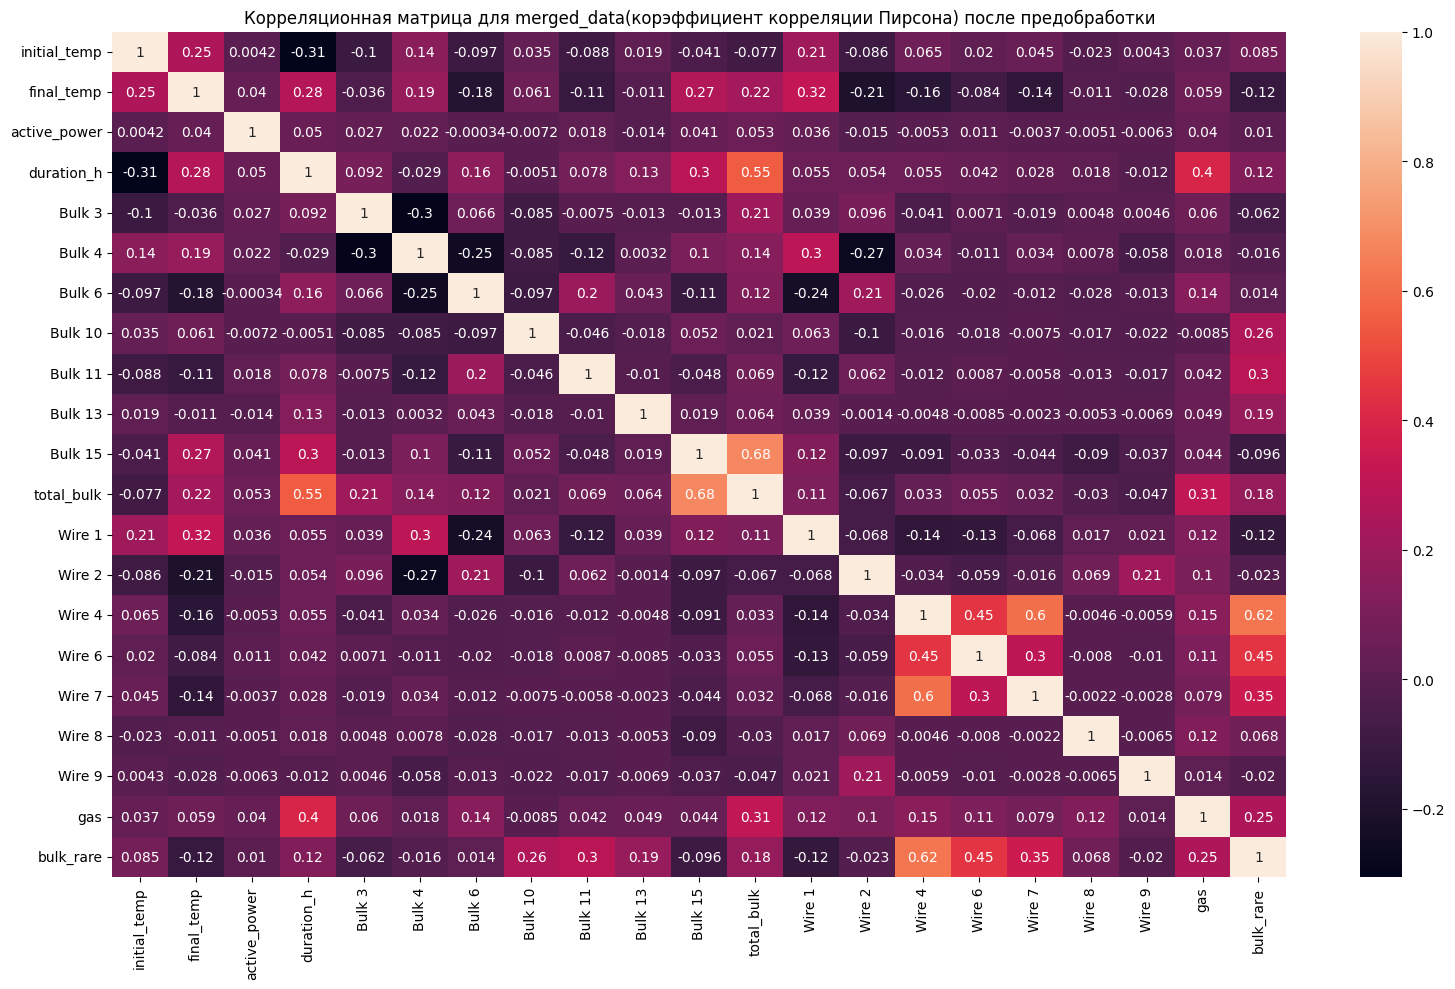

In [52]:
plt.figure(figsize=(16,10))
corr_matrix = merged_data.drop('key', axis=1).corr()
sns.heatmap(corr_matrix, 
            annot=True
)
plt.title('Корреляционная матрица для merged_data(корэффициент корреляции Пирсона) после предобработки')
plt.tight_layout()  
plt.show()

In [53]:
# Удаляем оставшиеся незначительные признаки
merged_data = merged_data.drop(columns=['Wire 9', 'Wire 8', 'Bulk 13'])

В ходе исследовательского анализа объединённого датафрейма была проведена комплексная работа по подготовке данных для моделирования:

Устранение мультиколлинеарности:
- Обнаружена и устранена высокая корреляция (>0.9) между мощностными характеристиками.
- Сохранена только активная работа как наиболее информативный признак.
- Удалены реактивная и полная мощности (apparent_power) и другие признаки с корреляцией выше 0.9.

Анализ корреляционных зависимостей:   
- Выявлены значимые взаимосвязи между добавками (Bulk 15/total_bulk - 0.68).
- Обнаружена зависимость продолжительности нагрева от общего объёма добавок (0.55).
- Удалены незначительные добавки и факторы (добавки в малых количествах, дополнительные признаки, не влияющие на конечную температуру)
- Определены ключевые факторы, влияющие на финальную температуру.

Контроль качества данных:
- Подтверждено отсутствие пропусков и дубликатов.
- Проверено нормальное распределение большинства параметров.  

Результатом этапа стал очищенный датафрейм, готовый для дальнейшего моделирования.

## Подготовка данных

In [54]:
# Разделим данные на признаки и целевую переменную
X = merged_data.drop(columns=['key', 'final_temp'])  # Исключаем ключ и целевую переменную
y = merged_data['final_temp']  # Целевая переменная - температура

# Разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)


In [55]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1746, 17) (1746,)
(582, 17) (582,)


In [56]:
# создадим список признаков (все признаки количественные)
numeric_features = X_train.columns.to_list()

Подготовим количественные данные с помощью масштабирования в пайплайне data_preprocessor. Подбор гиперпараметров также проведем через пайплайн pipe_final и RandomizedSearchCV. Модели, которые рассмотрим: LinearRegression, CatBoostRegressor, RandomForestRegressor, SCV.

In [57]:

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

data_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Финальный пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression,k=15)),
    ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

# Параметры для GridSearch
param_grid = [
    # словарь для модели LinearRegression
    {
        'model': [LinearRegression()],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    # словарь для модели RandomForest
    {
        'model': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'model__n_estimators': [200, 300],
        'model__max_depth': [10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели SCV
    {
        'model': [SVR()],
        'model__kernel': ['linear', 'rbf', 'poly'],  
        'model__C': [0.01, 0.1, 1, 10, 30, 50, 100], 
        'model__gamma': ['auto', 0.01, 0.1], 
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    # словарь для модели CatBoost
     {
    'model': [CatBoostRegressor(random_state=RANDOM_STATE, verbose=0, loss_function='MAE')],
    'model__iterations': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1],
    'model__depth': [4, 6, 8]
    }
]

## Обучение моделей машинного обучения

In [58]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
# Используем рандомизированный поиск для подбора лучшей модели по метрике MAE
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_iter=50,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)


print('Лучшие параметры модели:\n\n', randomized_search.best_params_)
print('Лучшая метрика модели на тренировочных данных:\n', -randomized_search.best_score_)
print('Лучшие модели и их параметры')
cv_results = pd.DataFrame(randomized_search.cv_results_).sort_values(by='mean_test_score', ascending=False)
display(cv_results.head(10))

Лучшие параметры модели:

 {'model__learning_rate': 0.1, 'model__iterations': 300, 'model__depth': 4, 'model': <catboost.core.CatBoostRegressor object at 0x329bb6ca0>}
Лучшая метрика модели на тренировочных данных:
 6.389800935798656
Лучшие модели и их параметры


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3        0.327479      0.031231         0.005706        0.002427   
45       0.598593      0.029214         0.004547        0.001343   
10       0.069763      0.005704         0.027215        0.004252   
1        1.280302      0.066638         0.014922        0.001444   
43       1.232060      0.076869         0.015734        0.002183   
15       1.286140      0.078110         0.017512        0.003479   
21       0.842790      0.050759         0.009892        0.002869   
7        1.281864      0.064665         0.016641        0.002495   
19       1.525997      0.087522         0.014833        0.002457   
6        1.521735      0.094369         0.022398        0.005676   

   param_preprocessor__num__scaler param_model__kernel param_model__gamma  \
3                              NaN                 NaN                NaN   
45                             NaN                 NaN                NaN   
10                StandardScaler()                 rbf               0.01   
1                   MinMaxScaler()                 NaN                NaN   
43                StandardScaler()                 NaN                NaN   
15                  MinMaxScaler()                 NaN                NaN   
21                     passthrough                 NaN                NaN   
7                   MinMaxScaler()                 NaN                NaN   
19                     passthrough                 NaN                NaN   
6                 StandardScaler()                 NaN                NaN   

    param_model__C                                        param_model  \
3              NaN  <catboost.core.CatBoostRegressor object at 0x3...   
45             NaN  <catboost.core.CatBoostRegressor object at 0x3...   
10            10.0                                              SVR()   
1              NaN         RandomForestRegressor(random_state=250325)   
43             NaN         RandomForestRegressor(random_state=250325)   
15             NaN         RandomForestRegressor(random_state=250325)   
21             NaN         RandomForestRegressor(random_state=250325)   
7              NaN         RandomForestRegressor(random_state=250325)   
19             NaN         RandomForestRegressor(random_state=250325)   
6              NaN         RandomForestRegressor(random_state=250325)   

    param_model__n_estimators  ...  param_model__depth  \
3                         NaN  ...                 4.0   
45                        NaN  ...                 8.0   
10                        NaN  ...                 NaN   
1                       300.0  ...                 NaN   
43                      300.0  ...                 NaN   
15                      300.0  ...                 NaN   
21                      200.0  ...                 NaN   
7                       300.0  ...                 NaN   
19                      300.0  ...                 NaN   
6                       300.0  ...                 NaN   

                                               params  split0_test_score  \
3   {'model__learning_rate': 0.1, 'model__iteratio...          -6.413474   
45  {'model__learning_rate': 0.1, 'model__iteratio...          -6.510521   
10  {'preprocessor__num__scaler': StandardScaler()...          -6.508426   
1   {'preprocessor__num__scaler': MinMaxScaler(), ...          -6.418685   
43  {'preprocessor__num__scaler': StandardScaler()...          -6.415299   
15  {'preprocessor__num__scaler': MinMaxScaler(), ...          -6.439920   
21  {'preprocessor__num__scaler': 'passthrough', '...          -6.435500   
7   {'preprocessor__num__scaler': MinMaxScaler(), ...          -6.439467   
19  {'preprocessor__num__scaler': 'passthrough', '...          -6.461948   
6   {'preprocessor__num__scaler': StandardScaler()...          -6.470965   

    split1_test_score  split2_test_score  split3_test_score split4_test_score  \
3           -6.252788          -6.204371      

Лучшая модель: *CatBoostRegressor* с параметрами: learning_rate: 0.1, iterations: 300, depth: 4.  МAE: 6.39 на тестовых данных, что ниже необходимой точности 6.8.
Хорошие результаты также показали модели SVR, RandomForestRegressor c различными параметрами.

## Выбор лучшей модели

Так как CatBoostRegressor показала лучшие результаты, используем ее для предсказания на тестовой выборке.

In [59]:
# Получение предсказаний на тестовой выборке
predictions = randomized_search.best_estimator_.predict(X_test)
# Вычисление RMSE на тестовой выборке
mae_test = mean_absolute_error(y_test, predictions)
print(f'MAE на тестовых данных: {round(mae_test, 2)}')

MAE на тестовых данных: 5.99


MAE 5.99 на тестовых данных - метрика в пределах нужного результата (ниже 6.8), а также меньше, чем для тренировочной выборки, что говорит об отсутствии переобучения.  
Проведем анализ признаков, которые внесли наибольший вклад в предсказания модели.

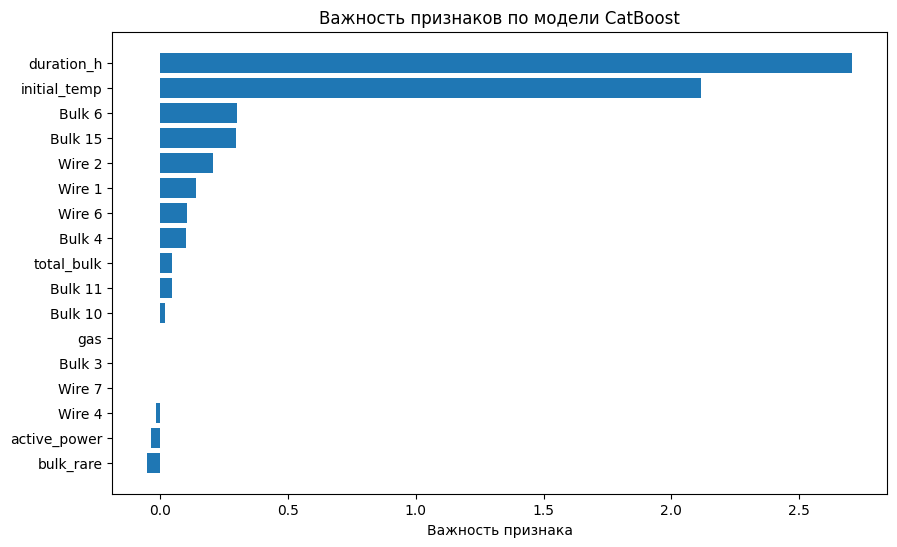

In [60]:
# Используем permutation importance для оценки важности признаков
permutation = permutation_importance(randomized_search.best_estimator_, X_test, y_test, scoring='neg_root_mean_squared_error')
feature_names = X_train.columns
# Создаем DataFrame для важности признаков
feature_importance = pd.DataFrame({
    'Признак': feature_names[:len(permutation.importances_mean)], 
    'Значимость': permutation.importances_mean
})

# Сортируем признаки по значимости
sorted_importance = feature_importance.sort_values(by='Значимость', ascending=True)

# Визуализируем важность признаков
plt.figure(figsize=(10, 6))
plt.barh(sorted_importance['Признак'], sorted_importance['Значимость'])
plt.xlabel('Важность признака')
plt.title('Важность признаков по модели CatBoost')
plt.show()

Самыми важными признаками при анализе с помощью permutation importance для модели CatBoostRegressor оказались:
- длительность нагрева - чем больше времени нагревается ковш, тем выше его конечная температура,
- начальная температура, чем она выше - тем выше и конечная,
- объем сыпучей добавки Bulk 15, Bulk 6.
Возможно, признаки bulk_rare, active_power можно убрать, так как они не оказывают сильного влияния на метрику.

Рассчитаем также значения Шепли для того, чтобы оценить, что повлияло на итоговое значение

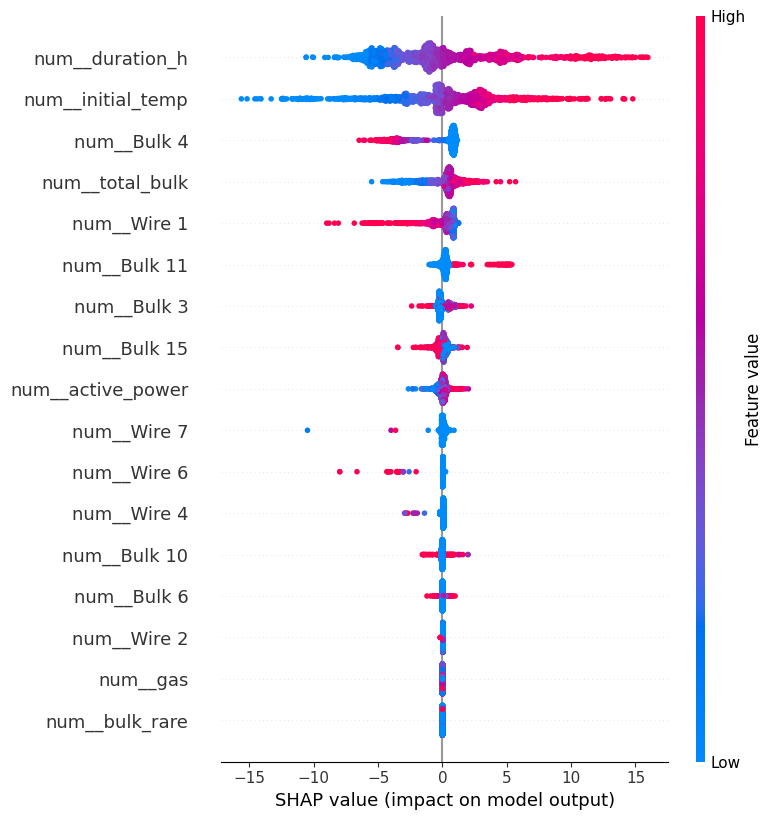

In [61]:
# Получаем предобработанные данные из пайплайна
best_model = randomized_search.best_estimator_.named_steps['model']
X_train_preprocessed = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_train)

explainer = shap.TreeExplainer(best_model)


# Вычисляем SHAP значения
feature_names = randomized_search.best_estimator_['preprocessor'].get_feature_names_out()
test_sample = X_train_preprocessed
test_shap = explainer.shap_values(test_sample)
shap.summary_plot(test_shap, test_sample, feature_names=feature_names)

По Шепли самым важным признаком оказывается также длительность нагрева дугой, начальная температура.   
Также заметен отрицательный вклад total_bulk чем больше суммарное количество сыпучих добавок, тем меньше конечная температура сплава, что выглядит логично.
Признаки большинства добавок, а также объем газа, не оказывают влияния на конечную температуру.

## Общий вывод и рекомендации заказчику

В результате выполнения проекта проведена предобработка данных.  
- Удалены аномальные значения (например, реактивная мощность -715).
- Объединены данные из 5 источников по ключу key с сохранением только полных записей.
- Для нагрева дугой: мощности усреднены, время и энергии суммированы по партиям.
Особенности данных:  
- Температура: оставлены только начальные и конечные замеры.
- Удалены редкие/незначимые добавки (Bulk 8, Wire 5).
- Выявлены и обработаны отсутствующие значения в данных о добавках, газе.
Корреляционный анализ:  
- Устранена мультиколлинеарность (удалены реактивная и полная мощности).
- Сохранены наиболее информативные признаки: активная мощность, длительность нагрева, ключевые добавки.
- Выявлены значимые взаимосвязи (например, между объемом добавок и временем нагрева).

Обучена и протестирована модель **CatBoostRegressor**, которая успешно предсказывает температуру стали с точностью MAE = 5.99 на тестовых данных, что превышает требования заказчика (MAE ≤ 6.8).

**Лучшие параметры модели**:
- learning_rate = 0.1
- iterations = 300
- depth = 4
**Ключевые факторы влияния**:
- Длительность нагрева (duration_h) — главный драйвер температуры (прямая зависимость).
- Начальная температура (initial_temp) — чем выше, тем выше конечная температура.
- Сыпучие добавки (Bulk 15, Bulk 6) — их объем существенно влияет на результат.
- Суммарный объем добавок (total_bulk) — отрицательное влияние: чем больше добавок, тем сильнее охлаждение сплава.  
  
**Рекомендации по оптимизации энергопотребления**

1) Оптимизация длительности нагрева:
Уменьшение времени нагрева для ковшей с высокой начальной температурой (экономия энергии).
Автоматические алерты при аномалиях: если время нагрева дольше среднего, если температура нагрева становится ниже обычного.
1) Управление добавками (если возможно при сохранении качества сплава):
Мониторинг добавления сыпучих добавок: суммарный объем добавок значительно снижает температуру.
Добавление сыпучих добавок в меньших объемах, но чаще, чтобы не перееохлаждать сплав, а также не первысить необходимое содержание добавки во избежание дополнительных корректировок состава.
